## Libraries

In [1]:
import os
import json
import math
from datetime import datetime

import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import nltk
from fuzzywuzzy import process, fuzz
from wordcloud import WordCloud, STOPWORDS

import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Cleaning

### Weather

Converting weather csv to a parquet format

In [2]:
df = pd.read_csv('./weather_NY_2010_2018Nov.csv')

Checking for null values

In [3]:
df.isnull().sum() / len(df)

USAF                0.000000
WBAN                0.000000
StationName         0.000000
State               0.000000
Latitude            0.000000
Longitude           0.000000
MeanTemp            0.000000
MinTemp             0.000330
MaxTemp             0.000330
DewPoint            0.243483
Percipitation       0.010070
WindSpeed           0.083166
MaxSustainedWind    0.169181
Gust                0.522954
Rain                0.000000
SnowDepth           0.966749
SnowIce             0.000000
Year                0.000000
Month               0.000000
Day                 0.000000
dtype: float64

Checking the number of unique values in each column

In [4]:
for i in list(df.columns):
    print(i, ":", len(df[i].unique()))

USAF : 57
WBAN : 40
StationName : 59
State : 1
Latitude : 52
Longitude : 58
MeanTemp : 1033
MinTemp : 603
MaxTemp : 565
DewPoint : 987
Percipitation : 380
WindSpeed : 284
MaxSustainedWind : 73
Gust : 78
Rain : 2
SnowDepth : 36
SnowIce : 2
Year : 9
Month : 12
Day : 31


The number of unique StationName, USAF and WBAN numbers are not the same. There seems to be some noise.

In [5]:
df.groupby(['USAF', 'WBAN']).agg({'StationName': 'unique', 'Latitude': 'nunique', 'Longitude': 'nunique'})

StationName  Latitude  Longitude
USAF   WBAN                                                                
720553 99999  [PORT AUTH DOWNTN MANHATTAN WALL ST HEL]         1          1
722098 64761                    [EAST HAMPTON AIRPORT]         1          1
724988 94704                [DANSVILLE MUNICIPAL ARPT]         1          1
725014 54780                         [MONTAUK AIRPORT]         1          1
725015 4789                    [ORANGE COUNTY AIRPORT]         1          1
...                                                ...       ...        ...
998267 99999                               [ROCHESTER]         1          1
998435 99999                              [OGDENSBURG]         1          1
998436 99999                        [BARCELONA HARBOR]         1          1
999999 64756                           [MILLBROOK 3 W]         1          1
       64758                             [ITHACA 13 E]         1          1

[62 rows x 3 columns]

A WBAN number has >1 StationName's associated

In [6]:
df.groupby('WBAN').agg({'StationName': 'nunique', 'Latitude': 'nunique', 'Longitude': 'nunique'})

StationName  Latitude  Longitude
WBAN                                   
465              1         1          1
4720             1         1          1
4724             1         1          1
4725             1         1          1
4741             1         1          1
4781             2         1          1
4789             1         1          1
14714            1         1          1
14715            1         1          1
14719            1         1          1
14732            1         1          1
14733            1         1          1
14735            1         1          1
14747            1         1          1
14748            1         1          1
14750            2         2          2
14757            1         1          1
14768            1         1          1
14771            1         1          1
54746            1         1          1
54757            1         1          1
54773            1         1          1
54778            1         1          1
54780            1         1          1
54787            1         1          1
54790            1         1          1
64756            1         1          1
64758            1         1          1
64761            1         1          1
64775            1         1          1
64776            1         1          1
94704            1         1          1
94725            1         1          1
94728            3         1          1
94740            1         1          1
94745            1         1          1
94761            1         1          1
94789            1         1          1
94790            1         1          1
99999           18        16         19

The data needs some cleaning

In [7]:
print(df[df['WBAN'] == 4781]['StationName'].unique())
print(df[df['WBAN'] == 94728]['StationName'].unique())
print(df[df['WBAN'] == 99999]['StationName'].unique())

['LONG ISLAND MAC ART' 'LONG ISLAND MAC ARTHUR AIRPORT']
['CENTRAL PARK' 'NEW YORK CENTRAL PARK' 'NYC CENTRAL PARK']
['BARCELONA HARBOR' 'BERGEN POINT' 'CATTARAUGUS CO OLEAN'
 'FLOYD BENNETT MEM' 'HUDSON RIVER RESERVE' 'KINGS POINT'
 'LONG ISLAND MAC ART' 'MONTAUK' 'NEW YORK CITY  CENTRAL PARK'
 'NIAGARA CG STATION' 'NIAGRA INTAKE' 'OGDENSBURG' 'OGDENSBURG INTL'
 'OLCOTT HARBOR' 'PORT AUTH DOWNTN MANHATTAN WALL ST HEL' 'ROCHESTER'
 'STURGEON POINT' 'THE BATTERY']


In [8]:
df[df['StationName'] == 'CENTRAL PARK'].head()

USAF   WBAN   StationName State  Latitude  Longitude  MeanTemp  \
19438  725053  94728  CENTRAL PARK    NY    40.779    -73.969      60.5   
19439  725053  94728  CENTRAL PARK    NY    40.779    -73.969      57.8   
19440  725053  94728  CENTRAL PARK    NY    40.779    -73.969      53.4   
19441  725053  94728  CENTRAL PARK    NY    40.779    -73.969      51.2   
19442  725053  94728  CENTRAL PARK    NY    40.779    -73.969      45.2   

       MinTemp  MaxTemp  DewPoint  Percipitation  WindSpeed  MaxSustainedWind  \
19438     52.0     70.0      46.5           0.00        4.3               8.9   
19439     53.1     64.9      52.8           0.24        4.8               8.9   
19440     46.9     61.0      35.3           0.02        5.5               9.9   
19441     48.0     55.9      35.9           0.00        5.3               8.9   
19442     37.9     53.1      25.9           0.00        3.1               7.0   

       Gust  Rain  SnowDepth  SnowIce  Year  Month  Day  
19438  15.9     0        NaN        0  2012     10    1  
19439  18.1     1        NaN        0  2012     10   10  
19440  20.0     0        NaN        0  2012     10   11  
19441  20.0     0        NaN        0  2012     10   12  
19442   NaN     0        NaN        0  2012     10   13

In [9]:
df[df['StationName'] == 'NEW YORK CITY  CENTRAL PARK'].head()

USAF   WBAN                  StationName State  Latitude  Longitude  \
94492  725033  99999  NEW YORK CITY  CENTRAL PARK    NY    40.767    -73.983   
94493  725033  99999  NEW YORK CITY  CENTRAL PARK    NY    40.767    -73.983   
94494  725033  99999  NEW YORK CITY  CENTRAL PARK    NY    40.767    -73.983   
94495  725033  99999  NEW YORK CITY  CENTRAL PARK    NY    40.767    -73.983   
94496  725033  99999  NEW YORK CITY  CENTRAL PARK    NY    40.767    -73.983   

       MeanTemp  MinTemp  MaxTemp  DewPoint  Percipitation  WindSpeed  \
94492      73.5     69.8     78.8      58.8           0.00        3.6   
94493      83.6     78.1     91.9      65.0           0.00        3.4   
94494      83.4     75.9     93.0      67.0           0.00        4.3   
94495      73.8     69.8     78.8      66.5           0.07        4.4   
94496      72.9     68.0     82.0      60.6           0.02        6.5   

       MaxSustainedWind  Gust  Rain  SnowDepth  SnowIce  Year  Month  Day  
94492               6.0   NaN     0        NaN        0  2010      8    1  
94493               7.0   NaN     0        NaN        0  2010      8   10  
94494               8.9   NaN     0        NaN        0  2010      8   11  
94495               8.0   NaN     1        NaN        0  2010      8   12  
94496              12.0  18.1     0        NaN        0  2010      8   13

Using latitude and longitude to check if a station can be uniquely identified

In [10]:
df.groupby(['Latitude', 'Longitude']).agg({'StationName': 'unique'})

StationName
Latitude Longitude                                                   
40.639   -74.146                                       [BERGEN POINT]
         -73.762               [JOHN F KENNEDY INTERNATIONAL AIRPORT]
40.701   -74.014                                        [THE BATTERY]
         -74.009             [PORT AUTH DOWNTN MANHATTAN WALL ST HEL]
40.734   -73.417                                   [REPUBLIC AIRPORT]
40.767   -73.983                        [NEW YORK CITY  CENTRAL PARK]
40.779   -73.969    [CENTRAL PARK, NEW YORK CENTRAL PARK, NYC CENT...
         -73.880                                 [LA GUARDIA AIRPORT]
40.783   -73.100                                [LONG ISLAND MAC ART]
40.794   -73.102    [LONG ISLAND MAC ART, LONG ISLAND MAC ARTHUR A...
40.800   -73.770                                        [KINGS POINT]
40.822   -72.869                                 [BROOKHAVEN AIRPORT]
40.844   -72.632                              [FRANCIS S GABRESKI AP]
40.960   -72.252                               [EAST HAMPTON AIRPORT]
41.050   -71.970                                            [MONTAUK]
41.067   -73.708                         [WESTCHESTER COUNTY AIRPORT]
41.073   -71.923                                    [MONTAUK AIRPORT]
41.500   -74.100                      [STEWART INTERNATIONAL AIRPORT]
41.509   -74.265                              [ORANGE COUNTY AIRPORT]
41.626   -73.882                            [DUTCHESS COUNTY AIRPORT]
41.701   -74.795                          [SULLIVAN COUNTY INTL ARPT]
41.786   -73.742                                      [MILLBROOK 3 W]
42.017   -73.917                               [HUDSON RIVER RESERVE]
42.109   -77.992                         [MUNI ARPT TARANTINE FLD AP]
42.150   -79.250                         [CHAUTAUQUA CO/JAMESTOWN AP]
42.159   -76.892                           [ELMIRA/CORNING RGNL ARPT]
42.207   -75.980               [GREATER BINGHAMTON/E A LINK FIELD AP]
42.241   -78.371    [CATTARAUGUS CO OLEAN, CATTARAUGUS COUNTY OLEA...
42.346   -79.596                                   [BARCELONA HARBOR]
42.440   -76.246                                        [ITHACA 13 E]
42.483   -76.467                   [ITHACA TOMPKINS REGIONAL AIRPORT]
42.493   -79.272                         [CHAUTAUQUA CO/DUNKIRK ARPT]
42.571   -77.713                           [DANSVILLE MUNICIPAL ARPT]
42.643   -77.056                                   [PENN YAN AIRPORT]
42.683   -79.050                                     [STURGEON POINT]
42.747   -73.799                       [ALBANY INTERNATIONAL AIRPORT]
42.850   -73.950                         [SCHENECTADY COUNTY AIRPORT]
42.941   -78.736                   [BUFFALO NIAGARA INTERNATIONAL AP]
43.067   -79.017                                      [NIAGRA INTAKE]
43.108   -78.938                         [NIAGARA FALLS INTL AIRPORT]
43.111   -76.104                  [SYRACUSE HANCOCK INTERNATIONAL AP]
43.117   -77.677                 [GREATER ROCHESTER INTERNATIONAL AP]
43.234   -75.412                                   [GRIFFIS AIRFIELD]
43.250   -77.583                                          [ROCHESTER]
43.267   -79.067                                 [NIAGARA CG STATION]
         -77.617                                          [ROCHESTER]
43.333   -78.717                                      [OLCOTT HARBOR]
         -73.600                                  [FLOYD BENNETT MEM]
43.338   -73.610                         [FLOYD BENNETT MEMO AIRPORT]
43.350   -76.385                              [OSWEGO COUNTY AIRPORT]
         -73.617                                  [FLOYD BENNETT MEM]
43.992   -76.022                             [WATERTOWN INTL AIRPORT]
44.050   -75.733                           [WHEELER-SACK AAF AIRPORT]
44.385   -74.207                           [ADIRONDACK REGIONAL ARPT]
44.650   -73.467                  [PLATTSBURGH INTERNATIONAL AIRPORT]
44.682   -75.466                                    [OGDENSBURG INTL

Mapping the different names with a standardized name

In [11]:
station_name_mapper = df.groupby('WBAN').agg({'StationName': 'unique', 'Latitude': 'nunique', 'Longitude': 'nunique'}).reset_index()
station_name_mapper['unique_stations'] = station_name_mapper['StationName'].apply(lambda x: len(x))

station_name_mapper = station_name_mapper[(station_name_mapper['Latitude'] == 1) & (station_name_mapper['Longitude'] == 1) & (station_name_mapper['unique_stations'] > 1)]
station_name_mapper

WBAN                                        StationName  Latitude  \
5    4781  [LONG ISLAND MAC ART, LONG ISLAND MAC ARTHUR A...         1   
33  94728  [CENTRAL PARK, NEW YORK CENTRAL PARK, NYC CENT...         1   

    Longitude  unique_stations  
5           1                2  
33          1                3

In [12]:
for index, row in station_name_mapper.iterrows():
    df.loc[df['WBAN'] == row['WBAN'],'StationName'] = row['StationName'][0]

Repeating the same process, but now for USAF

In [13]:
df.groupby('USAF').agg({'StationName': 'nunique', 'Latitude': 'nunique', 'Longitude': 'nunique'}).reset_index()

USAF  StationName  Latitude  Longitude
0   720553            1         1          1
1   722098            1         1          1
2   724988            1         1          1
3   725014            1         1          1
4   725015            1         1          1
5   725016            1         1          1
6   725030            1         1          1
7   725033            2         2          2
8   725035            1         2          2
9   725036            1         1          1
10  725037            1         1          1
11  725038            1         1          1
12  725050            1         1          1
13  725053            1         1          1
14  725060            1         1          1
15  725145            1         1          1
16  725146            1         1          1
17  725150            1         1          1
18  725155            1         1          1
19  725156            1         1          1
20  725157            1         1          1
21  725180            1         1          1
22  725185            1         2          2
23  725186            1         1          1
24  725190            1         1          1
25  725194            1         1          1
26  725196            1         1          1
27  725220            1         1          1
28  725235            1         1          1
29  725280            1         1          1
30  725283            2         1          1
31  725287            1         1          1
32  725290            1         1          1
33  726223            1         1          1
34  726225            1         1          1
35  726227            1         1          1
36  726228            1         1          1
37  743700            1         1          1
38  744860            1         1          1
39  744864            1         1          1
40  744865            1         1          1
41  744989            1         1          1
42  744994            1         1          1
43  997271            1         1          1
44  997272            1         1          1
45  997280            1         1          1
46  997282            1         1          1
47  997989            1         1          1
48  997991            1         1          1
49  998009            1         1          1
50  998168            1         1          1
51  998235            1         1          1
52  998266            1         1          1
53  998267            1         1          1
54  998435            1         1          1
55  998436            1         1          1
56  999999            2         2          2

In [14]:
station_name_mapper = df.groupby('USAF').agg({'StationName': 'unique', 'Latitude': 'nunique', 'Longitude': 'nunique'}).reset_index()
station_name_mapper['unique_stations'] = station_name_mapper['StationName'].apply(lambda x: len(x))

station_name_mapper = station_name_mapper[(station_name_mapper['Latitude'] == 1) & (station_name_mapper['Longitude'] == 1) & (station_name_mapper['unique_stations'] > 1)]
station_name_mapper

USAF                                        StationName  Latitude  \
30  725283  [CATTARAUGUS CO OLEAN, CATTARAUGUS COUNTY OLEA...         1   

    Longitude  unique_stations  
30          1                2

In [15]:
for index, row in station_name_mapper.iterrows():
    df.loc[df['USAF'] == row['USAF'],'StationName'] = row['StationName'][0]

In [16]:
df.groupby('USAF').agg({'StationName': 'nunique', 'Latitude': 'nunique', 'Longitude': 'nunique'}).reset_index()

USAF  StationName  Latitude  Longitude
0   720553            1         1          1
1   722098            1         1          1
2   724988            1         1          1
3   725014            1         1          1
4   725015            1         1          1
5   725016            1         1          1
6   725030            1         1          1
7   725033            2         2          2
8   725035            1         2          2
9   725036            1         1          1
10  725037            1         1          1
11  725038            1         1          1
12  725050            1         1          1
13  725053            1         1          1
14  725060            1         1          1
15  725145            1         1          1
16  725146            1         1          1
17  725150            1         1          1
18  725155            1         1          1
19  725156            1         1          1
20  725157            1         1          1
21  725180            1         1          1
22  725185            1         2          2
23  725186            1         1          1
24  725190            1         1          1
25  725194            1         1          1
26  725196            1         1          1
27  725220            1         1          1
28  725235            1         1          1
29  725280            1         1          1
30  725283            1         1          1
31  725287            1         1          1
32  725290            1         1          1
33  726223            1         1          1
34  726225            1         1          1
35  726227            1         1          1
36  726228            1         1          1
37  743700            1         1          1
38  744860            1         1          1
39  744864            1         1          1
40  744865            1         1          1
41  744989            1         1          1
42  744994            1         1          1
43  997271            1         1          1
44  997272            1         1          1
45  997280            1         1          1
46  997282            1         1          1
47  997989            1         1          1
48  997991            1         1          1
49  998009            1         1          1
50  998168            1         1          1
51  998235            1         1          1
52  998266            1         1          1
53  998267            1         1          1
54  998435            1         1          1
55  998436            1         1          1
56  999999            2         2          2

Can the 2 be used to uniquely identify a station, latitude and longitude ?

In [17]:
df.groupby(['USAF', 'WBAN']).agg({'StationName': 'nunique', 'Latitude': 'nunique', 'Longitude': 'nunique'})

StationName  Latitude  Longitude
USAF   WBAN                                   
720553 99999            1         1          1
722098 64761            1         1          1
724988 94704            1         1          1
725014 54780            1         1          1
725015 4789             1         1          1
...                   ...       ...        ...
998267 99999            1         1          1
998435 99999            1         1          1
998436 99999            1         1          1
999999 64756            1         1          1
       64758            1         1          1

[62 rows x 3 columns]

Creating the new station id and date features

In [18]:
df['SID'] = df['USAF'].astype(str) + '-' + df['WBAN'].astype(str)
df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-' + df['Day'].astype(str)

Saving the file as parquet

In [19]:
df.to_parquet('./weather_NY_2010_2018Nov.parquet')
del df

### NYC 311

Removing columns with more than 80% null values

In [20]:
df_311 = pd.read_csv('311-2016-2018.csv')
null_cols = df_311.columns[df_311.isnull().sum() * 100 / len(df_311) > 80]
df_311 = df_311.loc[:, ~df_311.columns.isin(null_cols)]

/var/folders/nk/2ytyt90n0cvdkfvs9kpqn2_h0000gn/T/ipykernel_76942/3700677112.py:1: DtypeWarning: Columns (8,17,18,20,24,31,32,33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df_311 = pd.read_csv('311-2016-2018.csv')


In [21]:
df_311

Unique Key            Created Date             Closed Date Agency  \
0          38237851  01/17/2018 02:39:00 PM  01/24/2018 12:00:00 AM   DSNY   
1          38237852  01/17/2018 01:40:00 PM  01/21/2018 12:00:00 AM   DSNY   
2          38237855  01/17/2018 10:42:00 PM  01/20/2018 10:02:00 PM   DSNY   
3          38237856  01/17/2018 07:26:00 PM  01/19/2018 12:00:00 AM   DSNY   
4          38237857  01/17/2018 07:13:00 PM  01/20/2018 07:41:00 PM   DSNY   
...             ...                     ...                     ...    ...   
7631716    38237846  01/17/2018 10:10:00 PM  01/18/2018 12:15:00 AM    DOT   
7631717    38237847  01/17/2018 07:46:00 PM  01/19/2018 12:00:00 AM   DSNY   
7631718    38237848  01/17/2018 07:13:00 PM  01/23/2018 12:00:00 AM   DSNY   
7631719    38237849  01/17/2018 04:27:00 PM  01/19/2018 12:00:00 AM   DSNY   
7631720    38237850  01/17/2018 03:13:00 PM  01/19/2018 12:00:00 AM   DSNY   

                          Agency Name                       Complaint Type  \
0            Department of Sanitation  Request Large Bulky Item Collection   
1            Department of Sanitation  Request Large Bulky Item Collection   
2            Department of Sanitation  Request Large Bulky Item Collection   
3            Department of Sanitation  Request Large Bulky Item Collection   
4            Department of Sanitation  Request Large Bulky Item Collection   
...                               ...                                  ...   
7631716  Department of Transportation             Traffic Signal Condition   
7631717      Department of Sanitation  Request Large Bulky Item Collection   
7631718      Department of Sanitation  Request Large Bulky Item Collection   
7631719      Department of Sanitation  Request Large Bulky Item Collection   
7631720      Department of Sanitation  Request Large Bulky Item Collection   

                                  Descriptor Location Type Incident Zip  \
0        Request Large Bulky Item Collection      Sidewalk        11222   
1        Request Large Bulky Item Collection      Sidewalk        10308   
2        Request Large Bulky Item Collection      Sidewalk        11361   
3        Request Large Bulky Item Collection      Sidewalk        10467   
4        Request Large Bulky Item Collection      Sidewalk        11215   
...                                      ...           ...          ...   
7631716                          Underground           NaN        10014   
7631717  Request Large Bulky Item Collection      Sidewalk        10010   
7631718  Request Large Bulky Item Collection      Sidewalk        11105   
7631719  Request Large Bulky Item Collection      Sidewalk        11206   
7631720  Request Large Bulky Item Collection      Sidewalk        11213   

              Incident Address  ...        Borough X Coordinate (State Plane)  \
0         95 GREENPOINT AVENUE  ...       BROOKLYN                   996371.0   
1             40 ASHWOOD COURT  ...  STATEN ISLAND                   944803.0   
2               204-36 47 ROAD  ...         QUEENS                  1046423.0   
3           3851 BARNES AVENUE  ...          BRONX                  1023208.0   
4                 160 7 AVENUE  ...       BROOKLYN                   990563.0   
...                        ...  ...            ...                        ...   
7631716                    NaN  ...      MANHATTAN                   982537.0   
7631717           373 1 AVENUE  ...      MANHATTAN                   990062.0   
7631718        23-80 24 STREET  ...         QUEENS                  1006633.0   
7631719   160 MANHATTAN AVENUE  ...       BROOKLYN                   999482.0   
7631720  686 MONTGOMERY STREET  ...       BROOKLYN                  1000391.0   

        Y Coordinate (State Plane) Open Data Channel Type Park Facility Name  \
0                         205243.0                  PHONE        Unspecified   
1                         142783.0                  PHONE        Unspecified   
2                    

Deleting unnecssary columns - with absolute correlation (1-1 correspondence)

In [22]:
del df_311['Agency Name']
del df_311['Created Year']
del df_311['Location']

In [23]:
df_311['Park Facility Name'].value_counts() * 100 / len(df_311)

Unspecified                                                           99.227147
Central Park                                                           0.022485
Prospect Park                                                          0.012081
Riverside Park                                                         0.011439
Flushing Meadows Corona Park                                           0.010168
                                                                        ...    
Central Park - The Mall and Rumsey Playfield                           0.000013
Williamsburg Bridge Playground                                         0.000013
Spring Creek Park Addition                                             0.000013
Pelham Bay Park - The Meadow                                           0.000013
School - Samuel Gompers Career and Technical Education High School     0.000013
Name: Park Facility Name, Length: 3056, dtype: float64

Deleting columns with street information

In [24]:
del df_311['Park Facility Name']
del df_311['Cross Street 1']
del df_311['Cross Street 2']
del df_311['X Coordinate (State Plane)']
del df_311['Y Coordinate (State Plane)']
del df_311['Address Type']

In [25]:
df_311.columns

Index(['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Complaint Type',
       'Descriptor', 'Location Type', 'Incident Zip', 'Incident Address',
       'Street Name', 'City', 'Facility Type', 'Status', 'Due Date',
       'Resolution Description', 'Resolution Action Updated Date',
       'Community Board', 'BBL', 'Borough', 'Open Data Channel Type',
       'Park Borough', 'Latitude', 'Longitude'],
      dtype='object')

In [26]:
df_311['Created Date'] = pd.to_datetime(df_311['Created Date'], errors = 'coerce')
df_311['Closed Date'] = pd.to_datetime(df_311['Closed Date'], errors = 'coerce')
df_311['Due Date'] = pd.to_datetime(df_311['Due Date'], errors = 'coerce')

Deleting records with Created date for 311 service records on or after Jan 1, 2016

In [27]:
olen = len(df_311)
df_311 = df_311[df_311['Created Date'] >= '2016-01-01']
print(f'Dropped {olen-len(df_311)} records')

Dropped 0 records


Identifying records with Created Date more than Closed Date, technically this is not possible. Owing to the large number of records, I suspect there is something suspicious. We should ask the domain expert for more clarifications on this topic. For now, we can drop them as we still have a lot of data.

In [28]:
olen = len(df_311)
df_311 = df_311.loc[~(df_311['Created Date'] > df_311['Closed Date']), :]
print(f'Dropped {olen-len(df_311)} records')

Dropped 52054 records


Most of the records are labelled closed, as others are very recent. This can also be confirmed once we look at the distribution of time take to complete a service request. The boxplot is further below.

<AxesSubplot:>

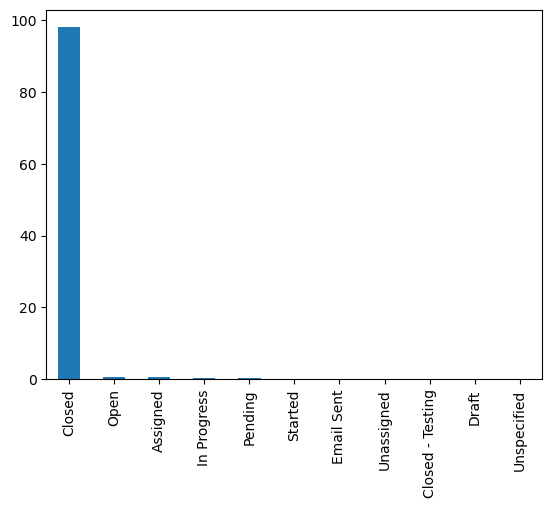

In [29]:
(100 * df_311['Status'].value_counts() / len(df_311)).plot(kind = 'bar')

We can see that the location data has some noise - Residential and Street have been listed twice

<AxesSubplot:>

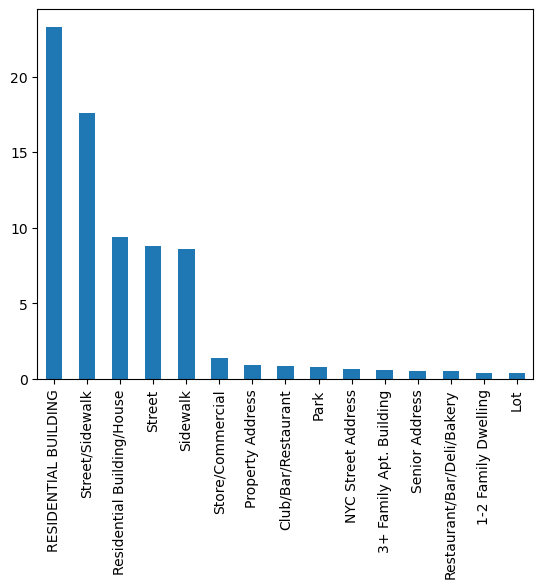

In [30]:
(100 * df_311['Location Type'].value_counts()[:15]/len(df_311)).plot(kind = 'bar')

Deleting Borough Block Numbers, as we will be focussing on a macro level to diagnose call patterns within NYC

In [31]:
del df_311['BBL']

Open Data Channel Type lists the source of the information - Phone / Mobile / Online etc. We will be focussing on Phone and Mobiles only

<AxesSubplot:>

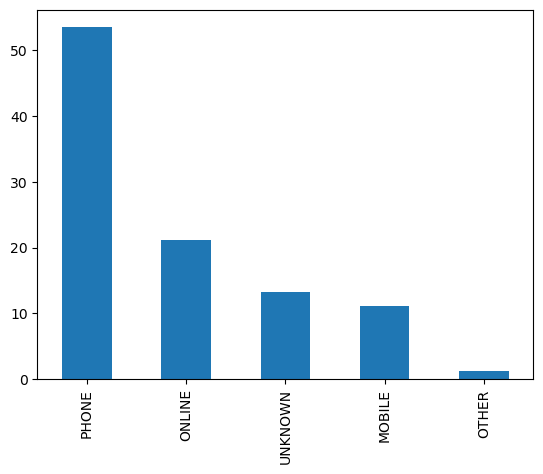

In [32]:
((100 * df_311['Open Data Channel Type'].value_counts()) / len(df_311)).plot(kind = 'bar')

In [33]:
df_311 = df_311[(df_311['Open Data Channel Type'] == 'PHONE') | (df_311['Open Data Channel Type'] == 'MOBILE')]

Checking the distribution of facility type

<AxesSubplot:>

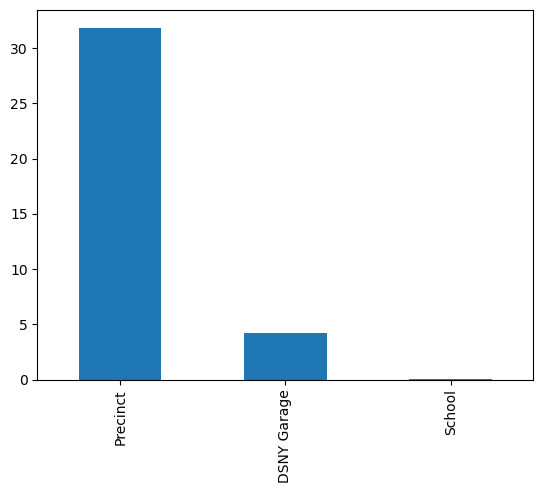

In [34]:
(100 * df_311['Facility Type'].value_counts()/len(df_311)).plot(kind = 'bar')

Checking the distribution of Boroughs

<AxesSubplot:>

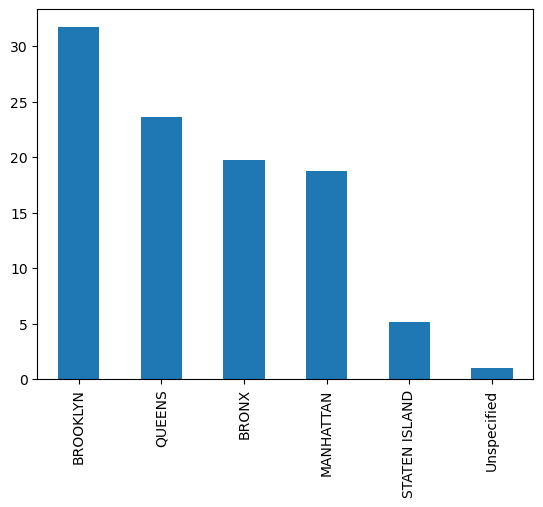

In [35]:
(100 * df_311['Park Borough'].value_counts() / len(df_311)).plot(kind = 'bar')

<AxesSubplot:>

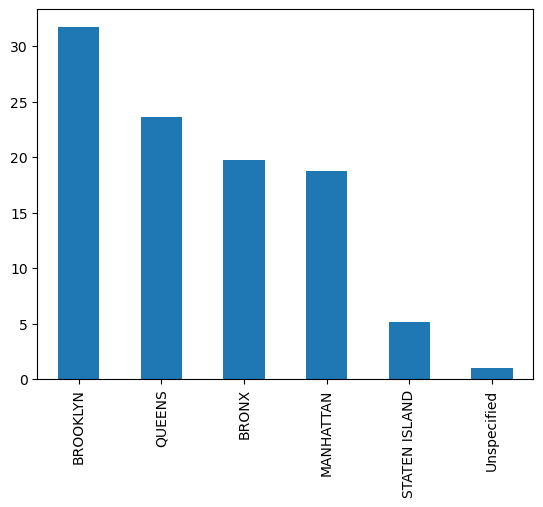

In [36]:
(100 * df_311['Borough'].value_counts() / len(df_311)).plot(kind = 'bar')

Removing one of Park Borough / Borough as it has a 1-1 correspondence. Also removing some other street level information

In [37]:
# Removed some granular unnecessary columns
del df_311['Street Name']
del df_311['Park Borough']
del df_311['Incident Address']
del df_311['Resolution Action Updated Date']
del df_311['Community Board']
del df_311['Open Data Channel Type']
del df_311['Status']

In [38]:
df_311.to_csv('311_calls.csv', index = False)

In [39]:
df_311['Complaint Type'].value_counts()

HEAT/HOT WATER                         499418
Noise - Residential                    415754
Blocked Driveway                       337988
Illegal Parking                        330621
Request Large Bulky Item Collection    226775
                                        ...  
Asbestos/Garbage Nuisance                   1
LinkNYC                                     1
LEAD                                        1
MOLD                                        1
Traffic Signal Condition                    1
Name: Complaint Type, Length: 211, dtype: int64

## Visualizations / EDA

In [40]:
df_311 = pd.read_csv('311_calls.csv')
df_311['Created Date'] = pd.to_datetime(df_311['Created Date'], errors = 'coerce')
df_311['Closed Date'] = pd.to_datetime(df_311['Closed Date'], errors = 'coerce')
df_311['Due Date'] = pd.to_datetime(df_311['Due Date'], errors = 'coerce')

/var/folders/nk/2ytyt90n0cvdkfvs9kpqn2_h0000gn/T/ipykernel_76942/2258785201.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_311 = pd.read_csv('311_calls.csv')


In [41]:
df_311.loc[~df_311['Closed Date'].isnull(), 'Time taken'] = df_311.loc[~df_311['Closed Date'].isnull(), 'Closed Date'] - df_311.loc[~df_311['Closed Date'].isnull(), 'Created Date']
df_311.loc[df_311['Closed Date'].isnull(), 'Time taken'] = df_311.loc[df_311['Closed Date'].isnull(), 'Due Date'] - df_311.loc[df_311['Closed Date'].isnull(), 'Created Date']

The time taken to complete a task is almost miniscule, and right skewed. With each request almost catered on that very day / instant, the chances of a follow-up call is negligible.

<AxesSubplot:>

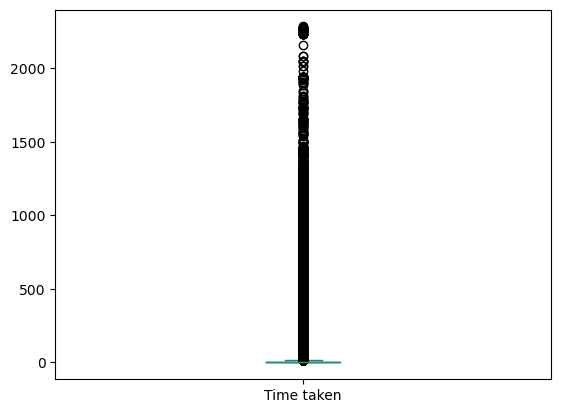

In [42]:
df_311['Time taken'].apply(lambda x: x.days).plot(kind = 'box')

In [43]:
df_311['Year'] = df_311['Created Date'].apply(lambda x: x.year)
df_311['Month'] = df_311['Created Date'].apply(lambda x: x.month)
df_311['Day'] = df_311['Created Date'].apply(lambda x: x.day)
df_311['Hour'] = df_311['Created Date'].apply(lambda x: x.hour)
df_311['Weekday'] = df_311['Created Date'].apply(lambda x: x.weekday())

Check the distribution of calls on a monthly, daily, hourly and yearly basis. Almost consistent throughout. Seasons have no effect.

<AxesSubplot:xlabel='Month'>

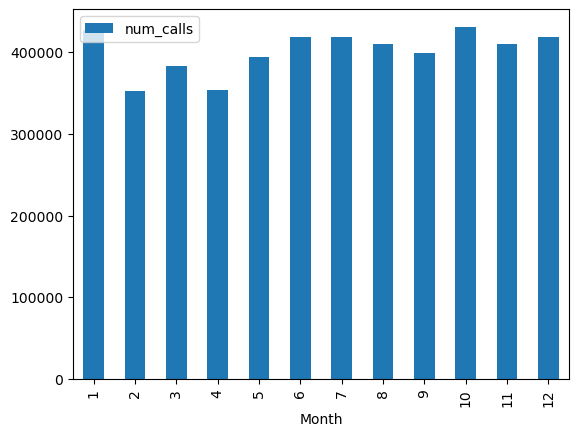

In [44]:
df_311.groupby('Month').agg(num_calls = ('City','count')).plot(kind = 'bar')

Number of calls are least between 1-7AM. But then increases exponentially, peaking at noon

<AxesSubplot:xlabel='Hour'>

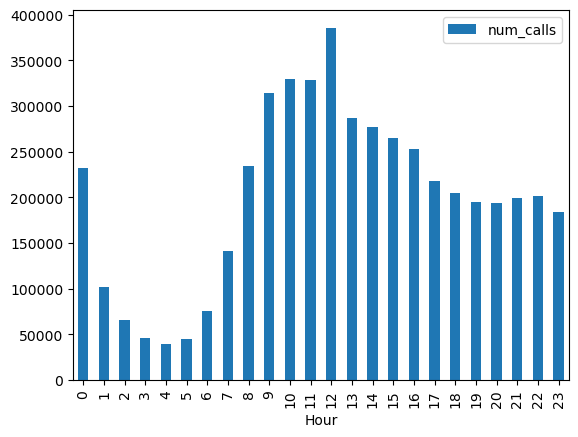

In [45]:
df_311.groupby('Hour').agg(num_calls = ('City','count')).plot(kind = 'bar')

We can see an upward trend in the total number of calls made each year

<AxesSubplot:xlabel='Year'>

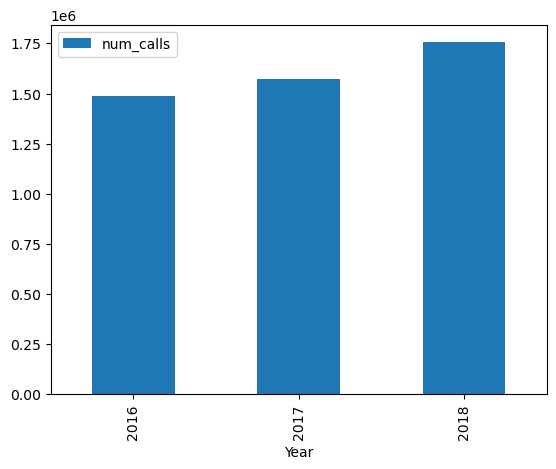

In [46]:
df_311.groupby('Year').agg(num_calls = ('City','count')).plot(kind = 'bar')

Number of calls also do not have an impact on the day of the month. The effect of any monthly events can be ruled out. The number of months with 31 days being half, the average number of calls is also half.

<AxesSubplot:xlabel='Day'>

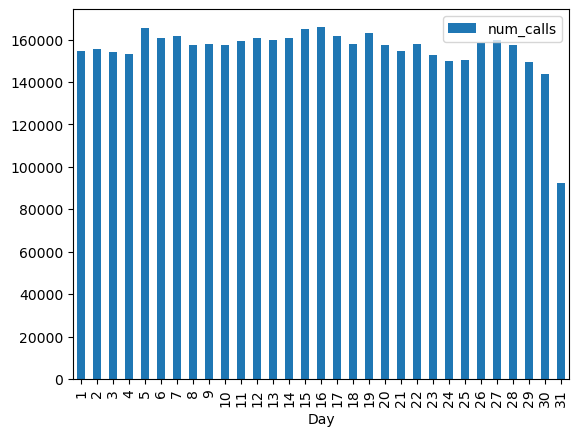

In [47]:
df_311.groupby('Day').agg(num_calls = ('City','count')).plot(kind = 'bar')

Number of calls are typically less in the weekends.

<AxesSubplot:xlabel='Weekday'>

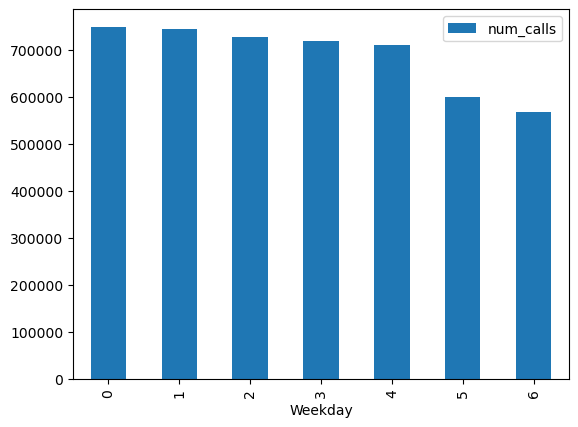

In [48]:
df_311.groupby('Weekday').agg(num_calls = ('City','count')).plot(kind = 'bar')

Loading the geojson files for loading the interactive map - based visualizations

In [49]:
neighbourhoods = gpd.read_file('zip_code_040114.geojson')

neighbourhoods.index = neighbourhoods['ZIPCODE']
neighbourhoods.drop(['BLDGZIP', 'POPULATION', 'AREA', 'STATE', 'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN'], axis=1, inplace=True)

neighbourhoods_json = json.loads(neighbourhoods.to_json())

In [50]:
def makeNYCPlot(df, plot_name, animation_col, location_col, write):
    min_val = df['Count'].min()
    max_val =  df['Count'].mean() + 2 * df['Count'].std()
    fig = px.choropleth_mapbox(data_frame=df,
                            geojson=neighbourhoods_json,
                            locations=df[location_col],
                            color='Count',
                            center={'lat':40.78, 'lon':-73.97},
                            mapbox_style='open-street-map',
                            zoom=9,
                            color_continuous_scale='blues',
                            range_color=(min_val, max_val),
                            animation_frame=animation_col,
                            width=800,
                            height=600)

    if write:
        fig.write_html(f'{plot_name}.html')
    else:
        return fig

Looking at how call frequency changes across zipcodes on an hourly/daily/monthly fashion. We also look at the call frequencies at a weekend level.

Please refer to the following HTML files:
1. Incidents by Hour.html
2. Incidents by Month.html
3. Incidents by Weekday.html

In [51]:
makeNYCPlot(df_311.groupby(['Incident Zip', 'Hour']).agg(Count = ('City', 'count')).reset_index().sort_values('Hour'), 'Incidents by Hour','Hour', 'Incident Zip', True)
makeNYCPlot(df_311.groupby(['Incident Zip', 'Month']).agg(Count = ('City', 'count')).reset_index().sort_values('Month'), 'Incidents by Month','Month', 'Incident Zip', True)
makeNYCPlot(df_311.groupby(['Incident Zip', 'Weekday']).agg(Count = ('City', 'count')).reset_index().sort_values('Weekday'), 'Incidents by Weekday','Weekday', 'Incident Zip', True)

This will help identify neighborhoods which require services at non-peak hours. (Neighborhoods that need special attention and services).

Now, we turn our attention to a broader audience by checking the boroughs

In [52]:
neighbourhoods = gpd.read_file('Borough Boundaries.geojson')
neighbourhoods['boro_name'] = neighbourhoods['boro_name'].apply(lambda x: x.upper())
neighbourhoods.index = neighbourhoods['boro_name']
neighbourhoods.drop(['shape_area', 'shape_leng', 'boro_code'], axis=1, inplace=True)

neighbourhoods_json = json.loads(neighbourhoods.to_json())
neighbourhoods.head()

boro_name  \
boro_name                      
STATEN ISLAND  STATEN ISLAND   
BRONX                  BRONX   
BROOKLYN            BROOKLYN   
MANHATTAN          MANHATTAN   
QUEENS                QUEENS   

                                                        geometry  
boro_name                                                         
STATEN ISLAND  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  
BRONX          MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...  
BROOKLYN       MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...  
MANHATTAN      MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
QUEENS         MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...

In [53]:
df_boro = df_311[df_311['Borough'] != 'Unspecified']

Performing a similar analysis, to:
Look at how call frequency changes across boroughs on an hourly/daily/monthly fashion. We also look at the call frequencies at a weekend level.

Please refer to the following HTML files:
1. Boro - Incidents by Hour.html
2. Boro - Incidents by Month.html
3. Boro - Incidents by Weekday.html

In [54]:
makeNYCPlot(df_boro.groupby(['Borough', 'Hour']).agg(Count = ('City', 'count')).reset_index().sort_values('Hour'), 'Boro - Incidents by Hour','Hour', 'Borough', True)
makeNYCPlot(df_boro.groupby(['Borough', 'Month']).agg(Count = ('City', 'count')).reset_index().sort_values('Month'), 'Boro - Incidents by Month','Month', 'Borough', True)
makeNYCPlot(df_boro.groupby(['Borough', 'Weekday']).agg(Count = ('City', 'count')).reset_index().sort_values('Weekday'), 'Boro - Incidents by Weekday','Weekday', 'Borough', True)

We look at complaint type(s) comprising more than 4% of our dataset. 

In [55]:
complaint = list(df_311['Complaint Type'].value_counts().index[df_311['Complaint Type'].value_counts() * 100 / len(df_311) > 4])
complaint

['HEAT/HOT WATER',
 'Noise - Residential',
 'Blocked Driveway',
 'Illegal Parking',
 'Request Large Bulky Item Collection']

We also identify the top 10 agencies, for which service requests have been lodged

In [56]:
df_boro['Agency'].value_counts().index[:10]

Index(['NYPD', 'HPD', 'DSNY', 'DEP', 'DOT', 'DPR', 'DOHMH', 'DOF', 'DHS',
       'DCA'],
      dtype='object')

<AxesSubplot:>

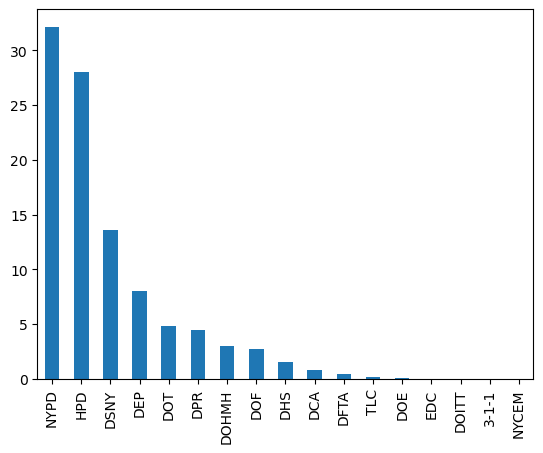

In [57]:
(100 * df_boro['Agency'].value_counts() / len(df_boro)).plot(kind = 'bar')

We now look at the requirements of agencies across NYC in the form of a bar plot. <br>
We perform this analysis on a monthly level across each borough and department.

Key Findings: 
1. 3-1-1 Department calls face almost double traffic in the first 5 months: Jan - May
2. DEP records the most number of calls in the month of July
3. Majority of the calls to DFTA originate from Brooklyn
4. Majority of the calls to DHS originate from Manhattan
5. DOE experiences a huge traffic in September
6. June and Septemeber are rough months for DOF
7. Majority of the calls to DOITT originate from Manhattan
8. Brooklyn and Queens have more service requests lodged to DOT than all other boroughs
9. DPR faces the most number of calls in the middle of the year
10. HPD receives the most number of calls almost in the winter season (Oct - Feb)
11. NYCEM barely receives any calls
12. Number of calls to TLC increase with each passing month.

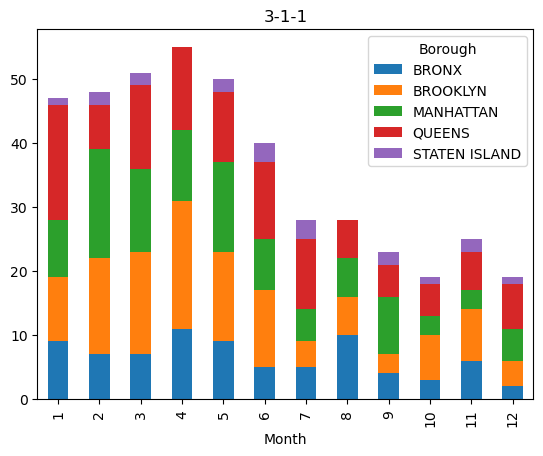

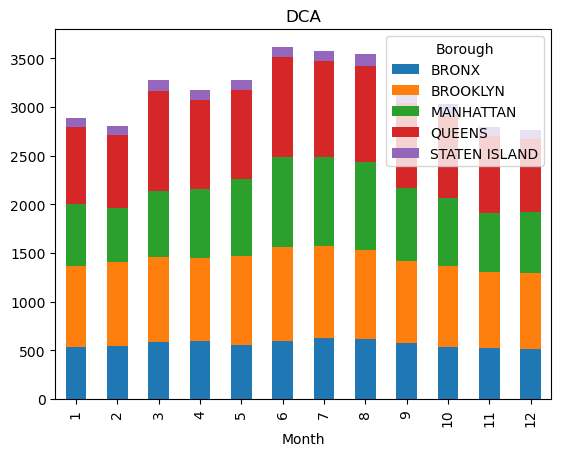

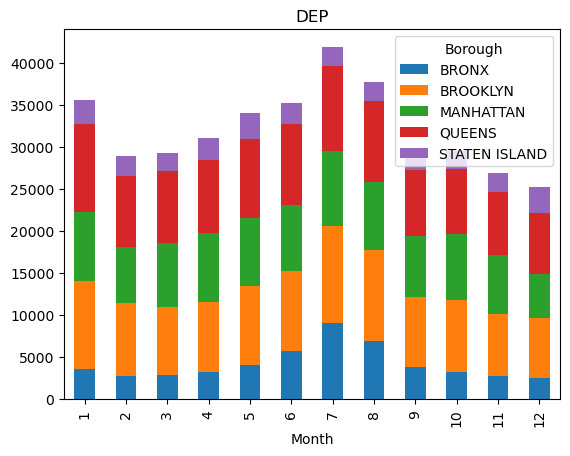

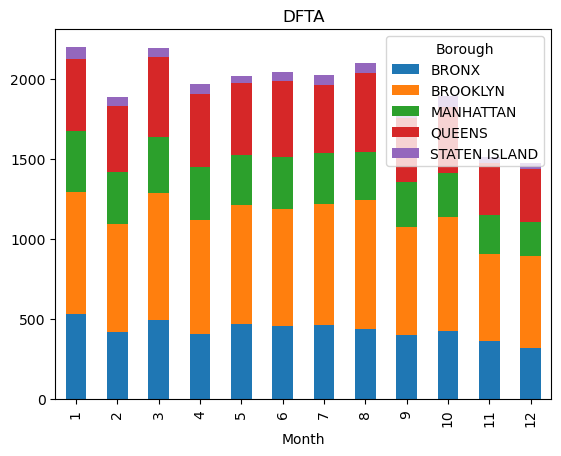

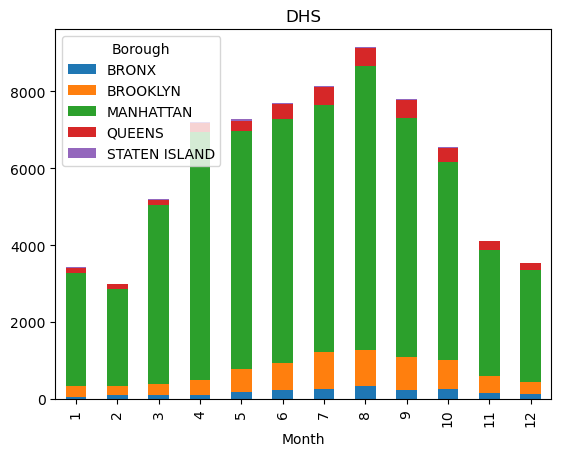

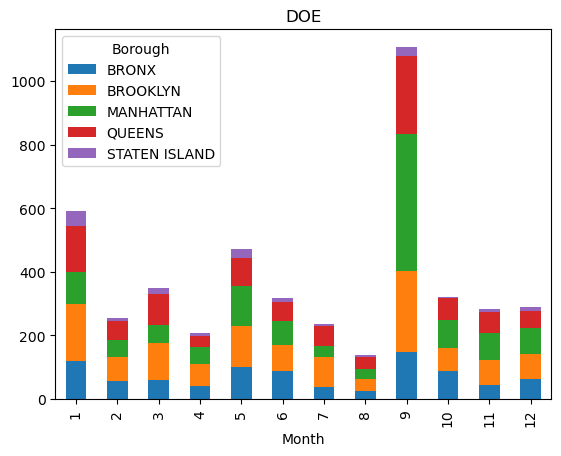

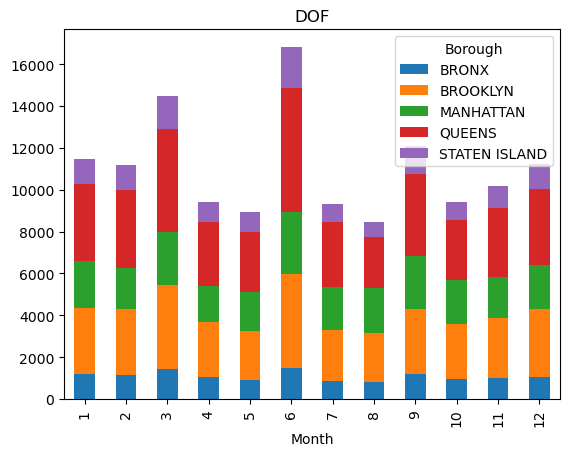

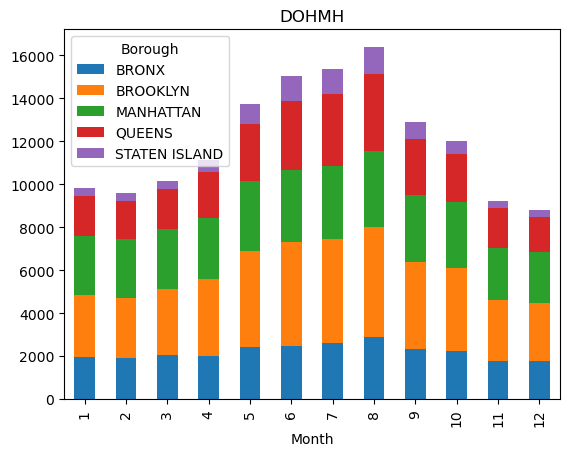

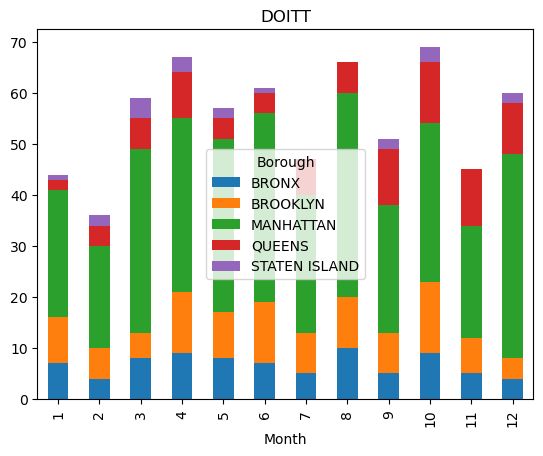

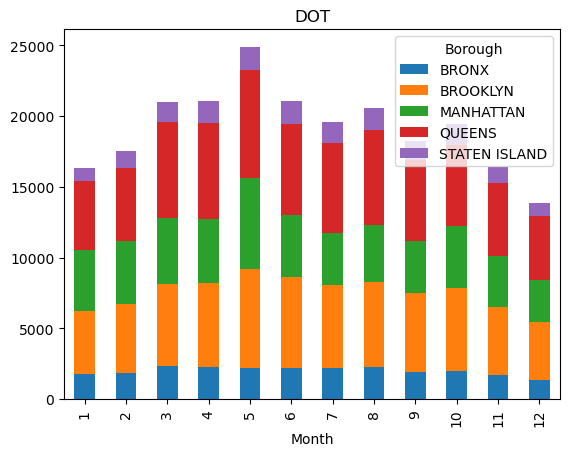

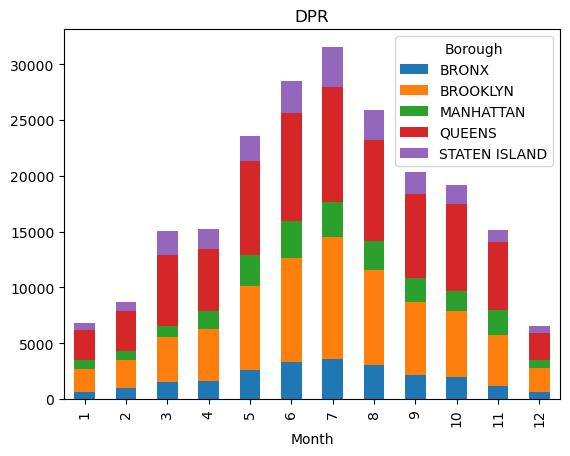

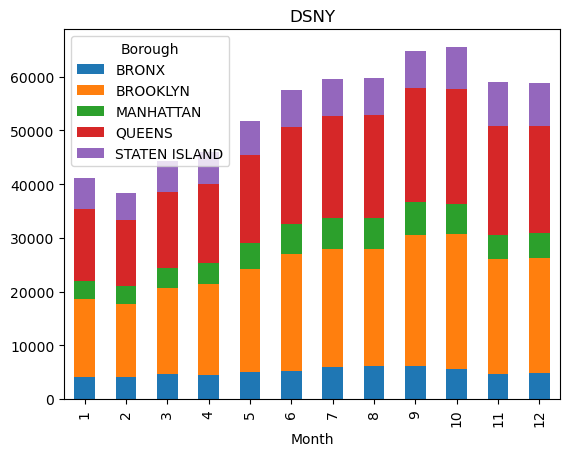

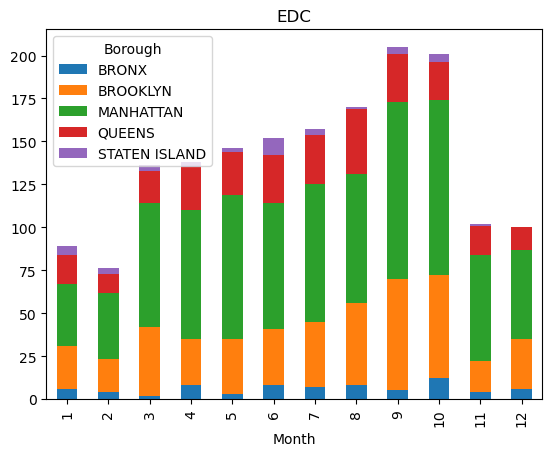

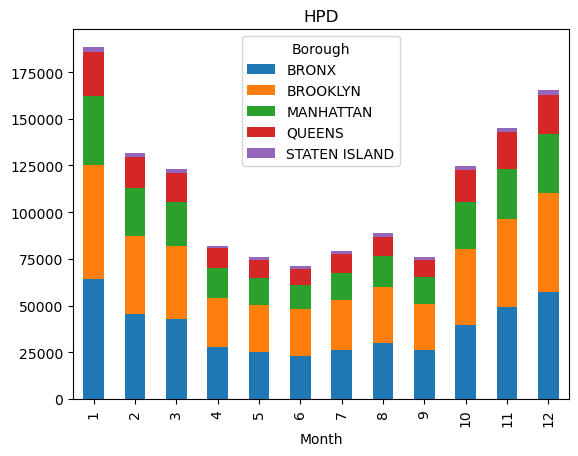

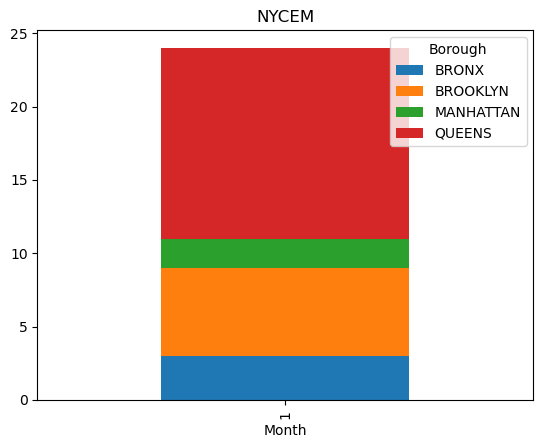

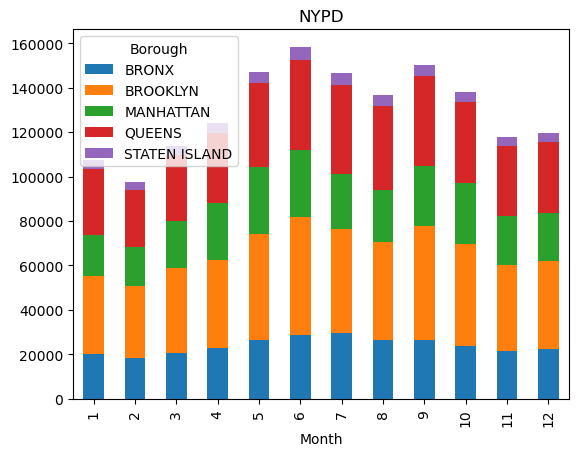

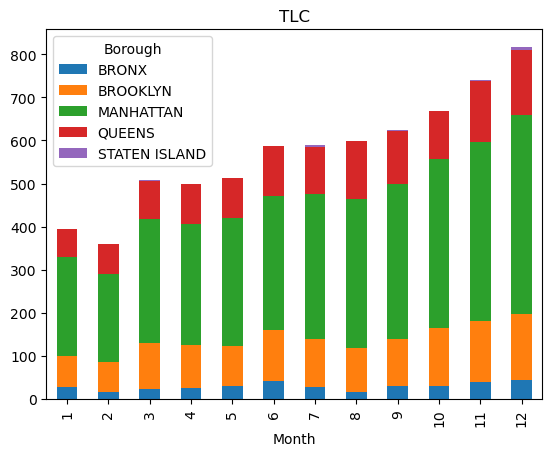

In [58]:
df_agency_per_month = df_boro.groupby(['Agency', 'Month', 'Borough']).agg(Count = ('City','count')).reset_index()
for i in df_agency_per_month['Agency'].unique():
    agency_counts_month = df_agency_per_month[df_agency_per_month['Agency'] == i]
    del agency_counts_month['Agency']
    agency_counts_month = pd.pivot_table(agency_counts_month, index = 'Month', values = 'Count', columns = 'Borough')
    agency_counts_month.plot.bar(stacked = True)
    plt.title(i)

We now look at the requirements of agencies across NYC in the form of a bar plot. <br>
We perform this analysis on a hourly level across each borough and department. (Most of the plots follow the same distribution of calls as above).

Key Findings:

1. 9AM seems to be the peak hour for 3-1-1
2. DEP experiences a good number of calls even in the night (after 9PM)
3. DOF only experiences calls from 8AM - 4PM
4. DOHMH experiences 80000+ calls in just one hour (that too at 12AM). Is it a data collection issue ? (A domain expert must be consulted).
5. DSNY experiences almost double the number of calls at noon.
6. NYPD receives huge traffic in the night (between 11PM - 1PM).
7. No service requests lodged for NYCEM, TLC from Staten Island.

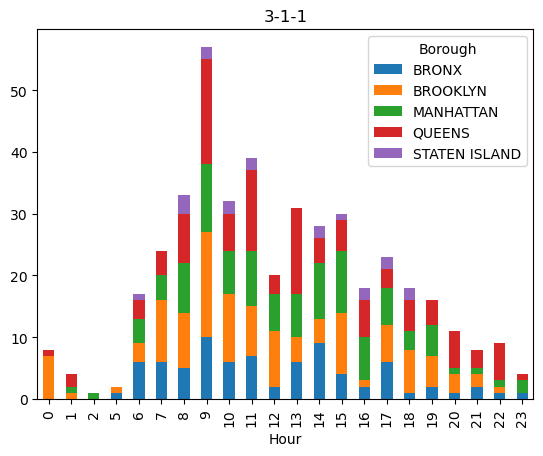

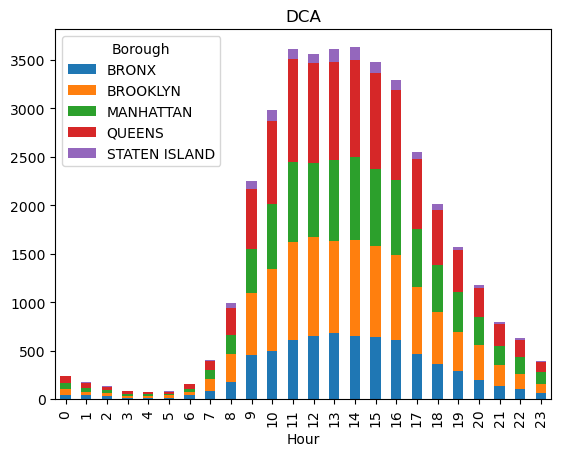

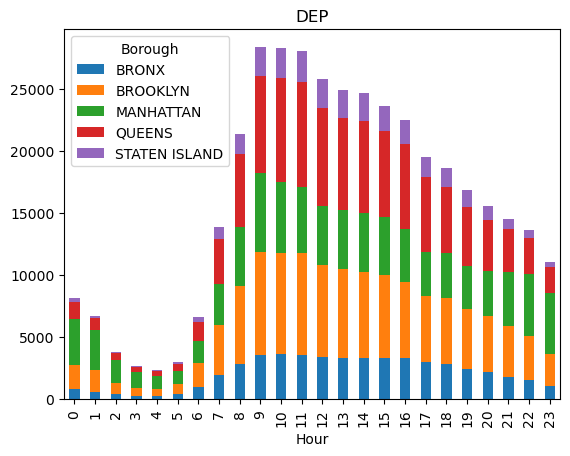

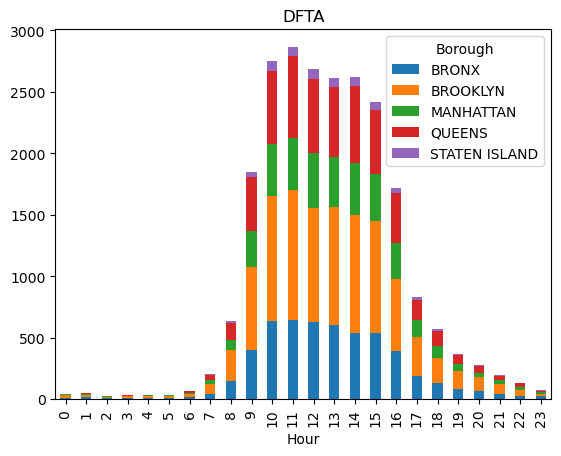

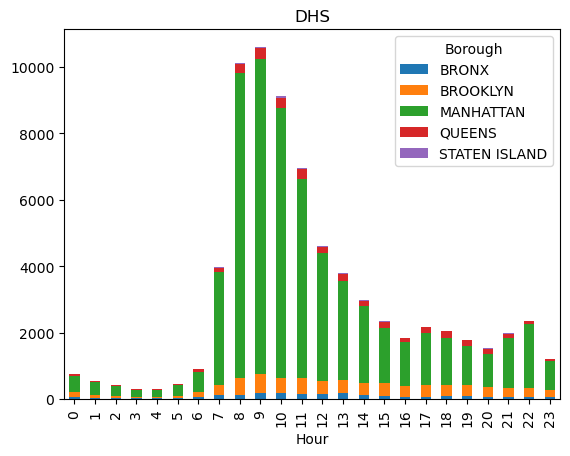

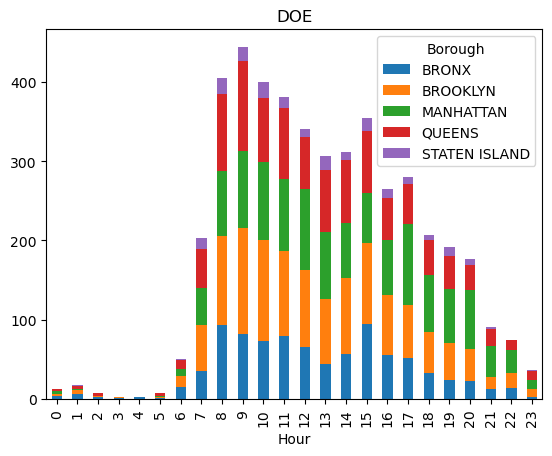

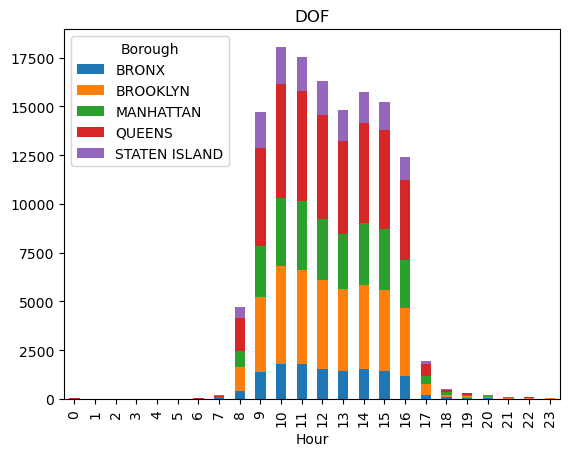

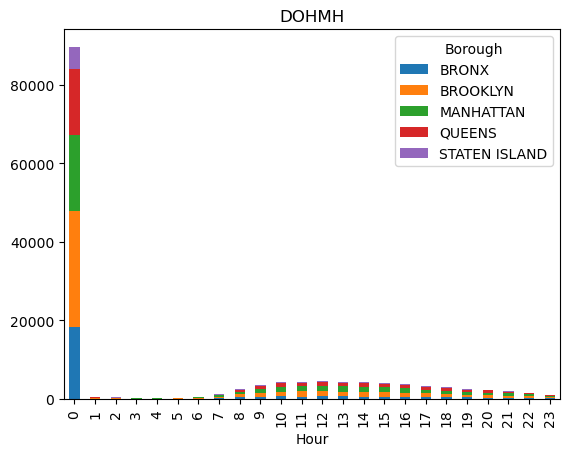

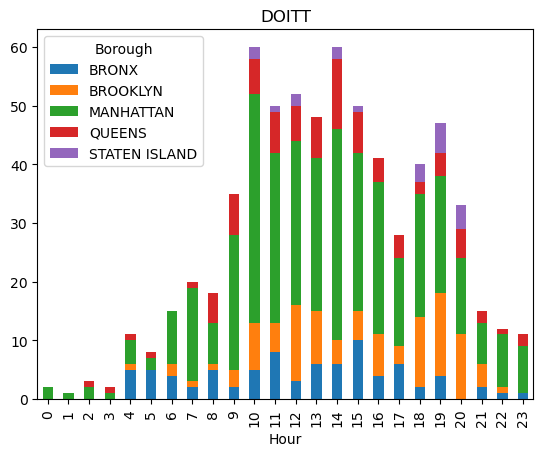

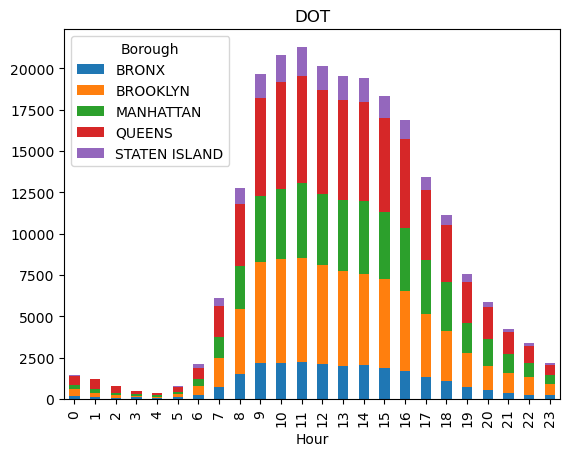

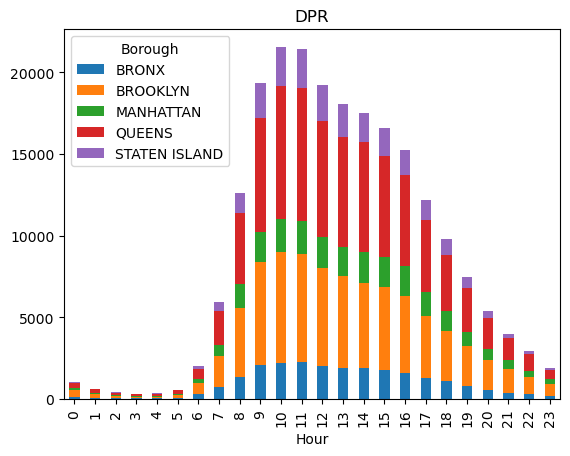

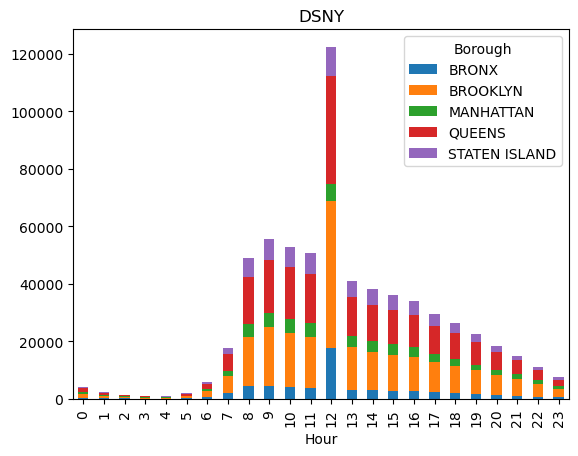

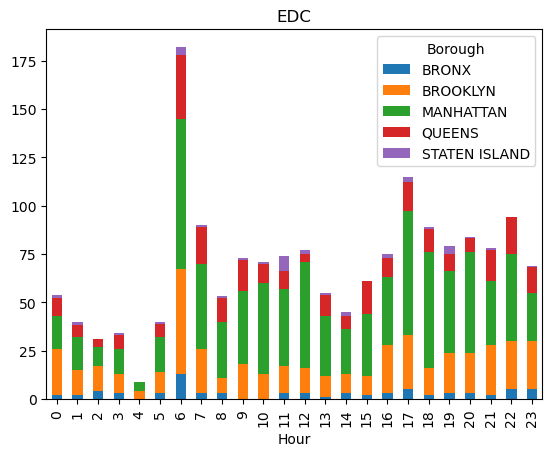

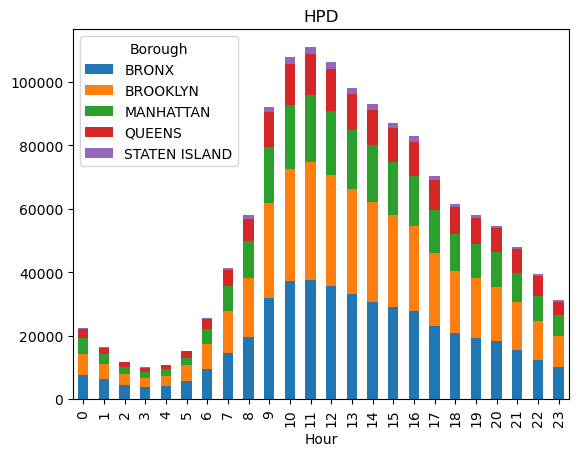

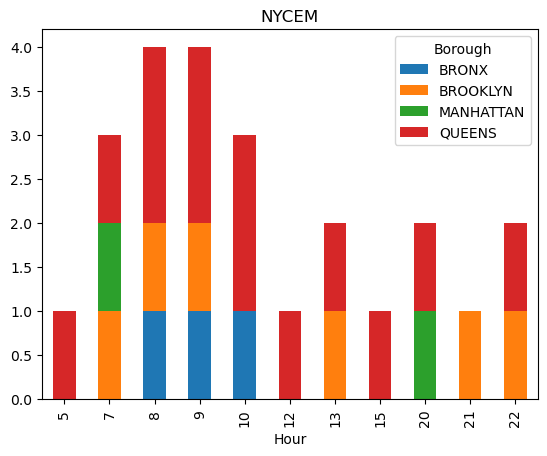

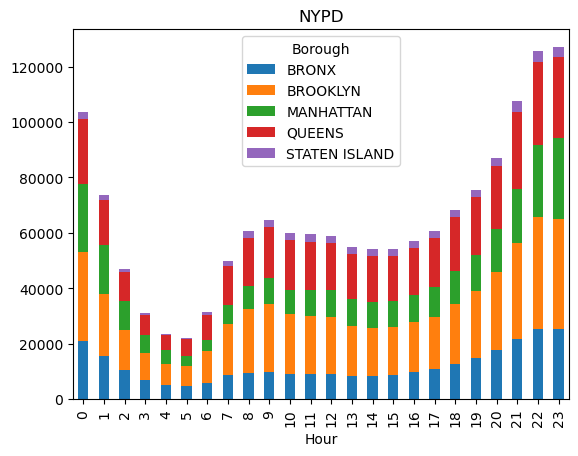

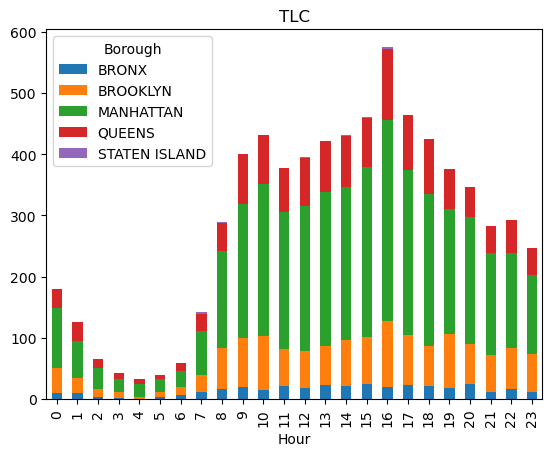

In [59]:
df_agency_per_month = df_boro.groupby(['Agency', 'Hour', 'Borough']).agg(Count = ('City','count')).reset_index()
for i in df_agency_per_month['Agency'].unique():
    agency_counts_month = df_agency_per_month[df_agency_per_month['Agency'] == i]
    del agency_counts_month['Agency']
    agency_counts_month = pd.pivot_table(agency_counts_month, index = 'Hour', values = 'Count', columns = 'Borough')
    agency_counts_month.plot.bar(stacked = True)
    plt.title(i)

We now look at the requirements of agencies across NYC in a similar fashion, but on a map <br>
We perform this analysis on a monthly level across each borough and for some select departments.

In [60]:
agency_subset = ['HPD', 'DHS', 'TLC']
for i in agency_subset:
    df_1 = df_boro[df_boro['Agency'] == i]
    makeNYCPlot(df_1.groupby(['Borough', 'Month']).agg(Count = ('City', 'count')).reset_index().sort_values('Month'), f'Boro - Incidents by Month - {i}','Month', 'Borough', True)

Removing facility type

In [61]:
del df_311['Facility Type']
df_311 = df_311.sort_values(['Complaint Type', 'Year']).reset_index(drop=True)

Check the distribution and number of different complaint types

In [62]:
df_311['Complaint Type'].value_counts()

HEAT/HOT WATER                         499418
Noise - Residential                    415754
Blocked Driveway                       337988
Illegal Parking                        330621
Request Large Bulky Item Collection    226775
                                        ...  
LEAD                                        1
Highway Sign - Damaged                      1
Highway Sign - Missing                      1
Traffic Signal Condition                    1
Illegal Animal - Sold/Kept                  1
Name: Complaint Type, Length: 211, dtype: int64

Changing the case reduces the number of distinct complaint types from 211 to 206. This also suggests that there is some noise.

In [63]:
df_311['Complaint Type'] = df_311['Complaint Type'].apply(lambda x: x.lower().strip())

In [64]:
df_311['Complaint Type'].value_counts()

heat/hot water                         499418
noise - residential                    415754
blocked driveway                       337988
illegal parking                        330621
request large bulky item collection    226775
                                        ...  
highway sign - damaged                      1
highway sign - missing                      1
illegal animal - sold/kept                  1
linknyc                                     1
taxi licensee complaint                     1
Name: Complaint Type, Length: 206, dtype: int64

We group columns with similar tokens into the same bucket using fuzzywuzzy and partial token ration

In [65]:
complaint_types = df_311['Complaint Type'].unique()
mapper = {}
value_set = set()
key_set = set()

for i in complaint_types:
    for j in complaint_types:
        value = fuzz.partial_ratio(i, j)

        if value > 80 and i != j:
            if i in key_set or i in value_set or j in key_set or j in value_set:
                if i in key_set:
                    mapper[i] = j
                if j in key_set:
                    mapper[j] = i
                if i in value_set:
                    mapper[j] = i
                if j in value_set:
                    mapper[i] = j

            else:
                mapper[i] = j
                key_set.add(i)
                value_set.add(j)

In [66]:
for k,v in mapper.items():
    df_311['Complaint Type'] = df_311['Complaint Type'].replace(k, v)

Interestingly enough, the number of distinct complaints go further down to 168 and we see that noise based service requests stand at the top, above heat/hot water in actuality.

In [67]:
df_311['Complaint Type'].value_counts()

noise                     823833
heat/hot water            499418
unsanitary condition      360490
blocked driveway          337988
illegal parking           330621
                           ...  
ztestint                       2
linknyc                        1
highway sign - damaged         1
highway sign - missing         1
vacant apartment               1
Name: Complaint Type, Length: 168, dtype: int64

We now analyze the top 2 complaints for each department

In [68]:
agency_complaints = df_311.groupby(['Agency', 'Complaint Type']).agg(Count = ('City', 'count')).reset_index()
agency_complaints.sort_values('Count', ascending = False, inplace = True)
top2 = agency_complaints.groupby('Agency').head(2).reset_index(drop=True)

In [69]:
top2.sort_values('Agency', inplace = True)
top2

Agency                             Complaint Type   Count
27  3-1-1                 homeless person assistance       2
25  3-1-1             city vehicle placard complaint     430
28    DCA  dca / doh new license application request       0
14    DCA                     fhv licensee complaint   38831
5     DEP                               water system  171595
7     DEP                                      noise   91719
18   DFTA                housing - low income senior   15609
20   DFTA                            housing options    4314
9     DHS                 homeless person assistance   73075
19    DOE                         school maintenance    4571
16    DOF               dof property - payment issue   21720
13    DOF             dof property - reduction issue   40396
8   DOHMH                                     rodent   78747
17  DOHMH                         food establishment   19102
24  DOITT                  public payphone complaint     662
30  DORIS                     hpd literature request       0
11    DOT                           street condition   64920
12    DOT                         sidewalk condition   63916
15    DPR                    maintenance or facility   37699
10    DPR                               damaged tree   66899
6    DSNY                       unsanitary condition  169404
3    DSNY        request large bulky item collection  225562
23    EDC                                      noise    1672
4     HPD                       unsanitary condition  183696
1     HPD                             heat/hot water  494286
26  NYCEM                       oem disabled vehicle      24
29  NYCEM                     hpd literature request       0
2    NYPD                           blocked driveway  336734
0    NYPD                                      noise  727284
21    TLC                             taxi complaint    4134
22    TLC                 for hire vehicle complaint    2733

Removing complaints with less 100 calls in the last 2 years

In [70]:
top2 = top2[top2['Count'] > 100]
df_311['Y-M'] = df_311['Year'].astype(str) + '-' + df_311['Month'].astype(str)

In [71]:
subset_complaints = top2['Complaint Type']
df_top2 = df_311[df_311['Complaint Type'].isin(subset_complaints)]

We now look at how the frequency of the top-2 complaints for each department on a yearly basis, across each borough.

Key Findings:

1. Blocked driveways complaints have increased from 2016 by ~20% (least in Manhattan)
2. No city vehicle placcard complaints observed in 2018
3. Damaged tree requests have increased in 2018, proportionately across each borough
4. DOF - Payment Issue based complaints have increased consistently across years.
5. For hire vehicle complaints have increased exponentially across years (most in Manhattan)
6. Homeless person assistance complaints have decreased dramatically from 2016.
7. Housing low income - senior complaints, along with overall housing option based complaints are seeing a decreasing trend
8. Maintenance and Facility complaints have a lot of unspecified boroughs for 2018, could be a possible data leakage issue
9. Public payphone complaints have decreased overall, but have somewhat increased in Staten Island
10. Large bulky item based requests have increased exponentially and did not exist in 2016.
11. School maintenance issues and taxi complaints have increased.


/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



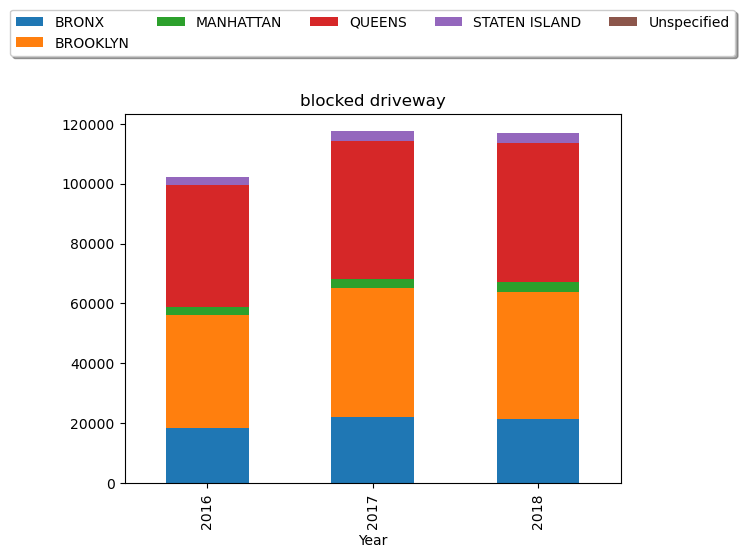

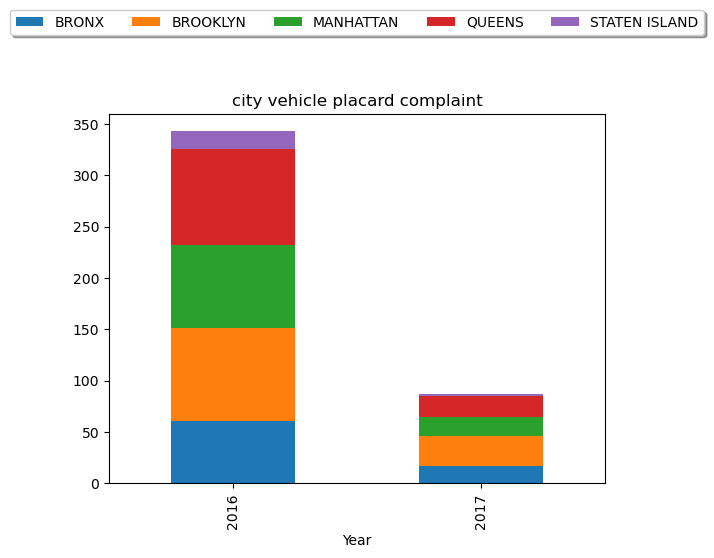

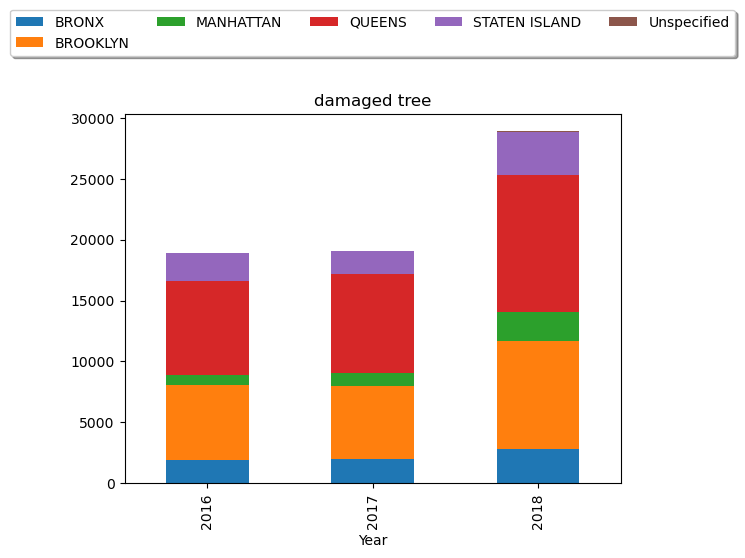

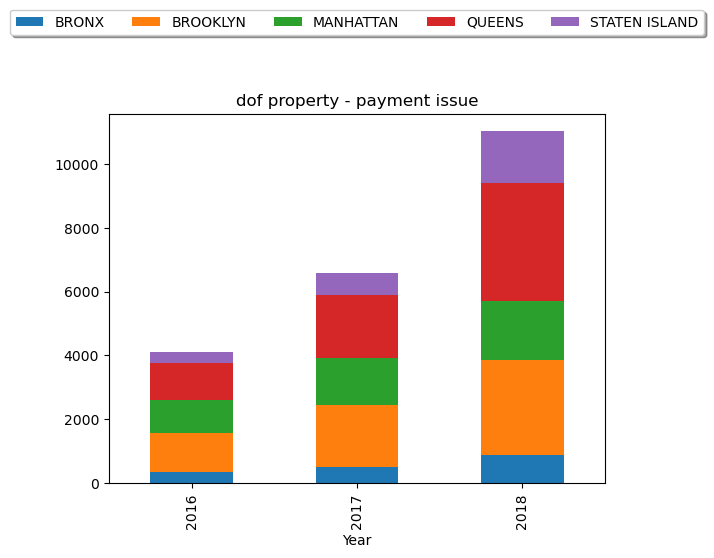

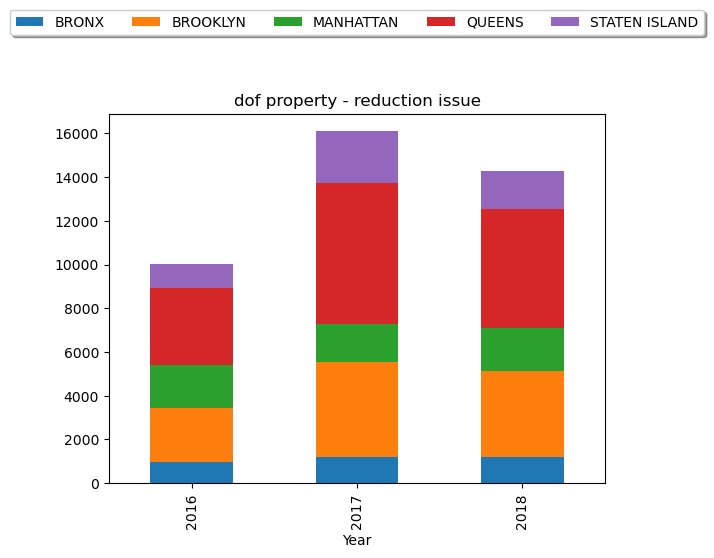

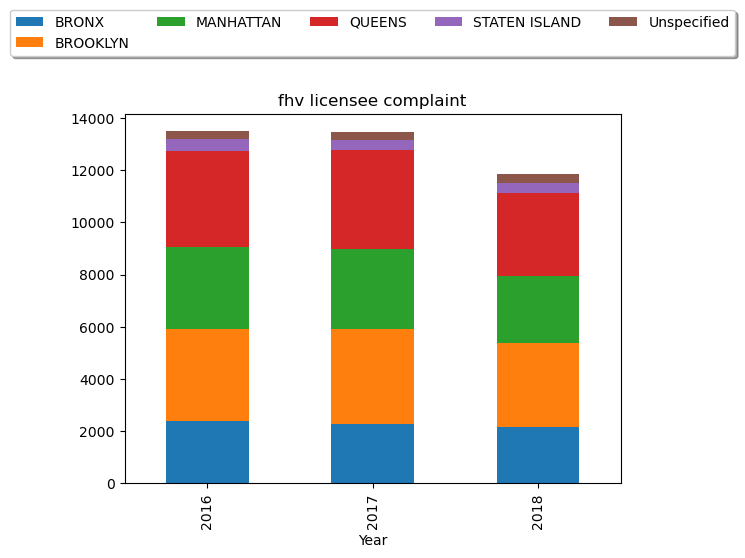

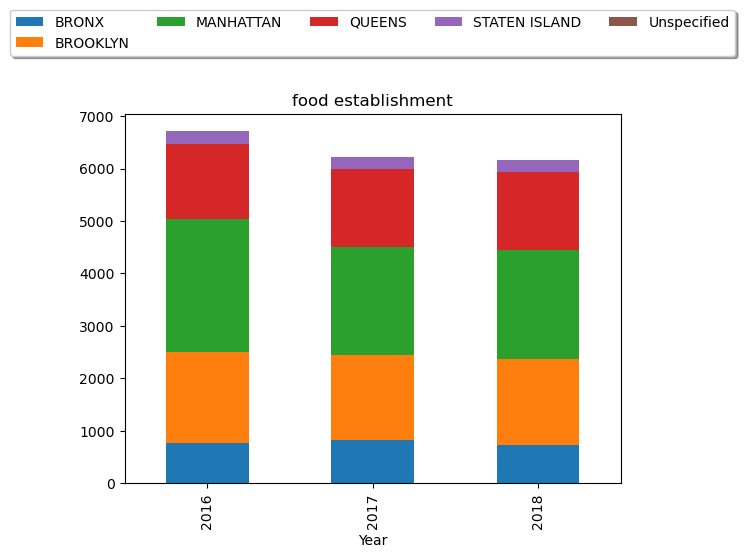

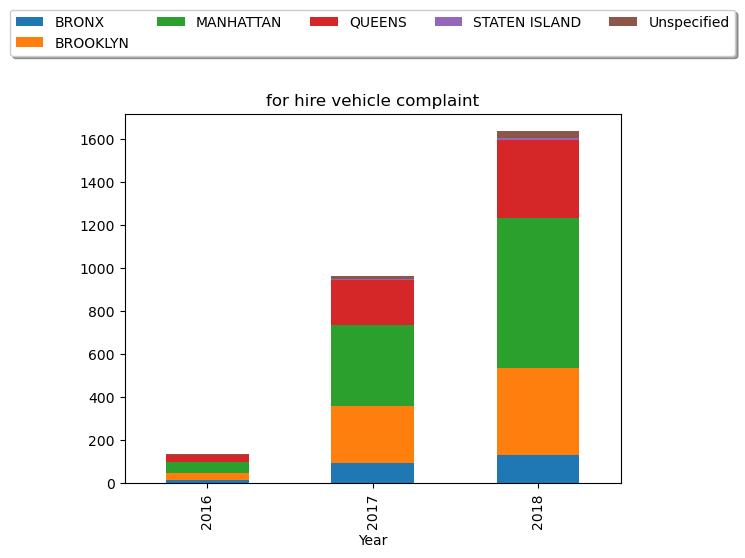

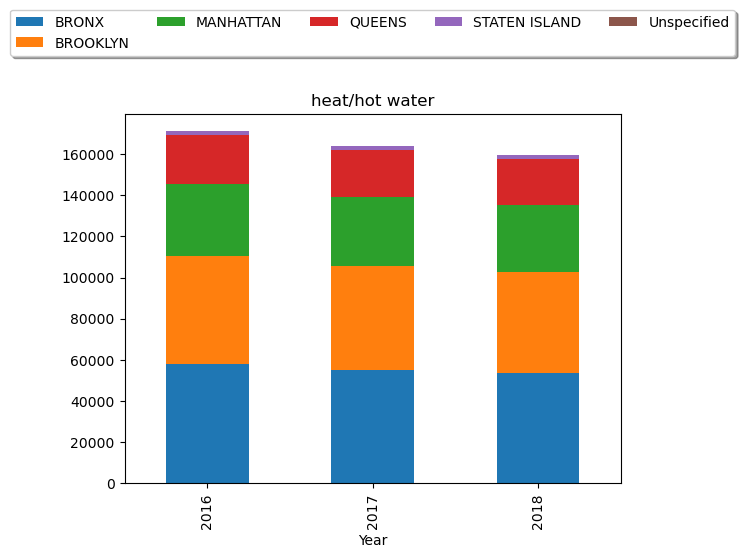

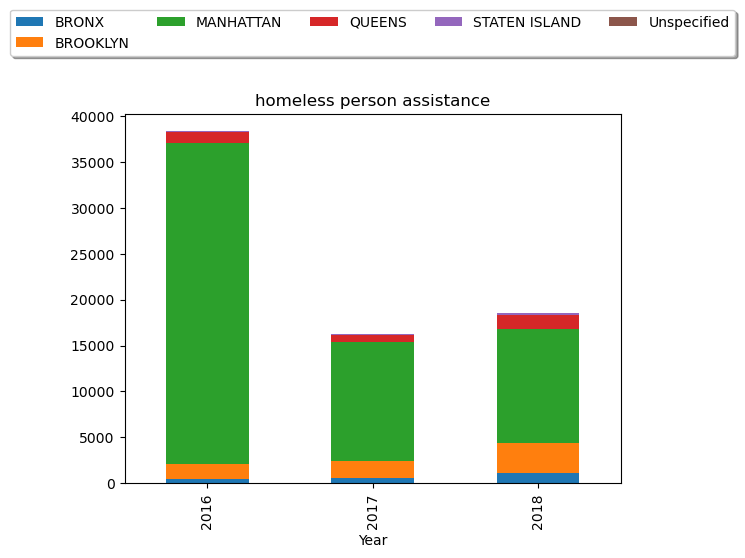

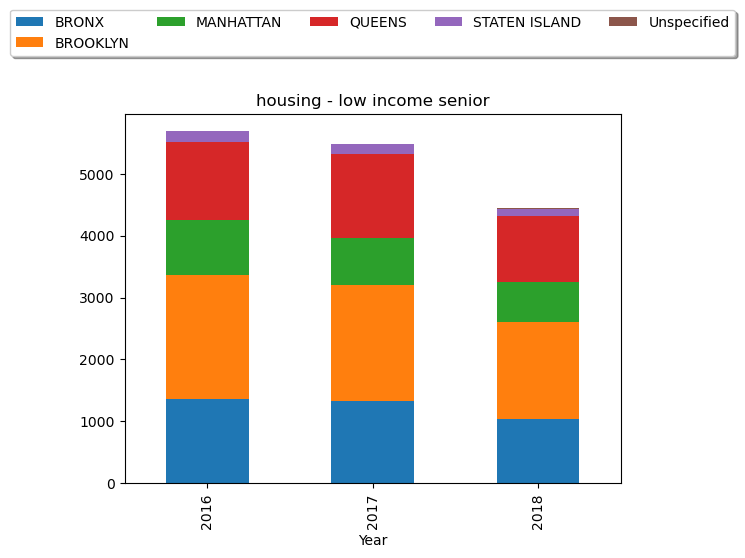

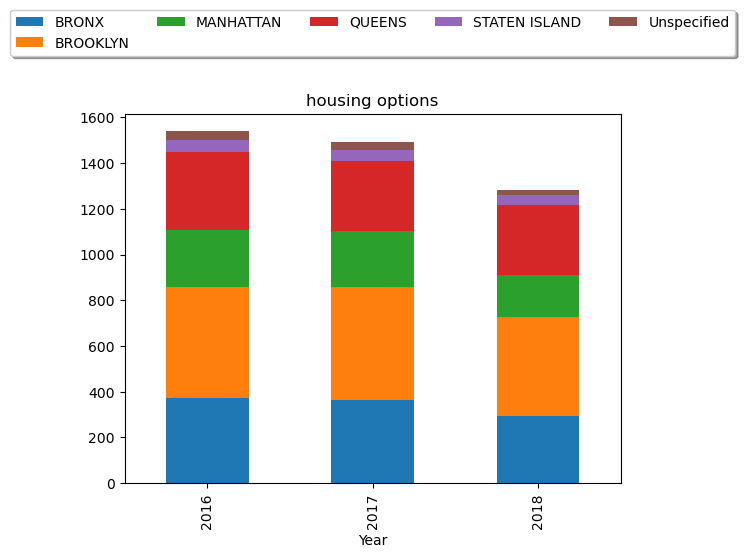

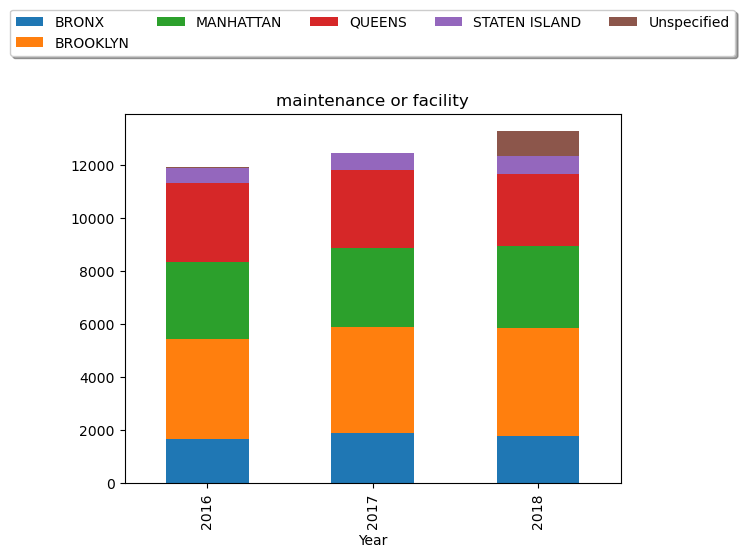

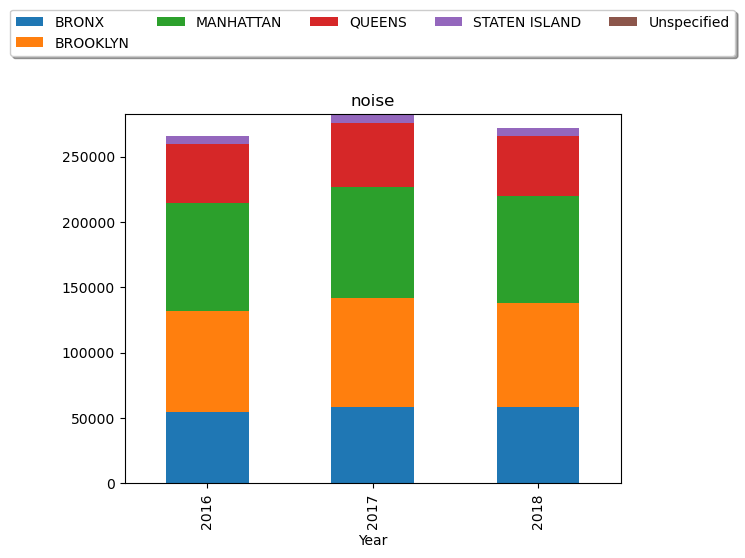

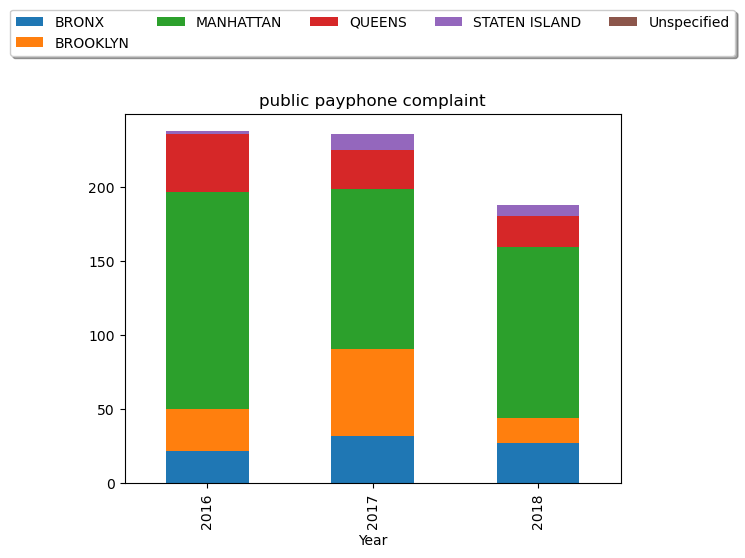

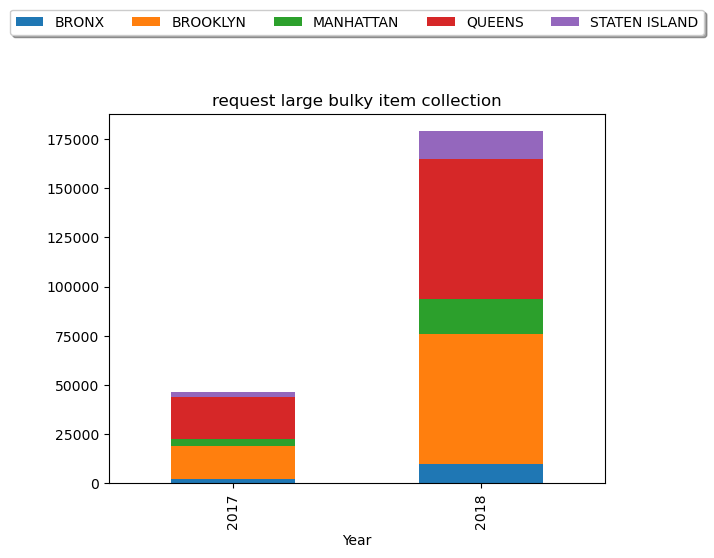

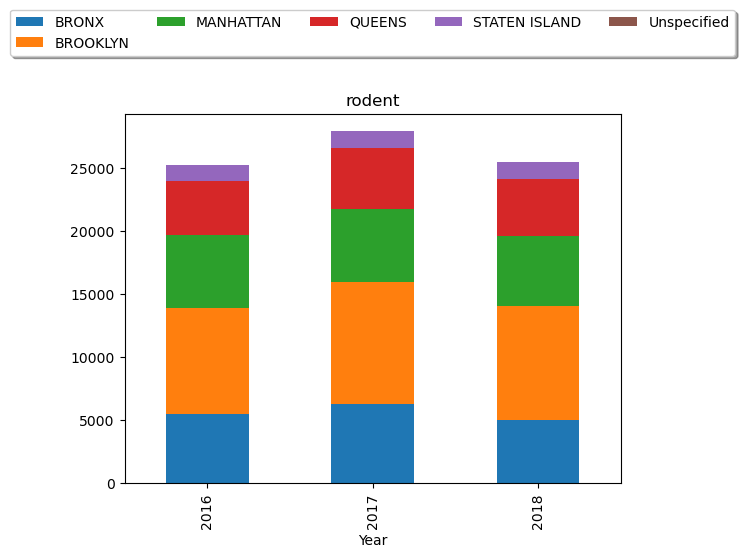

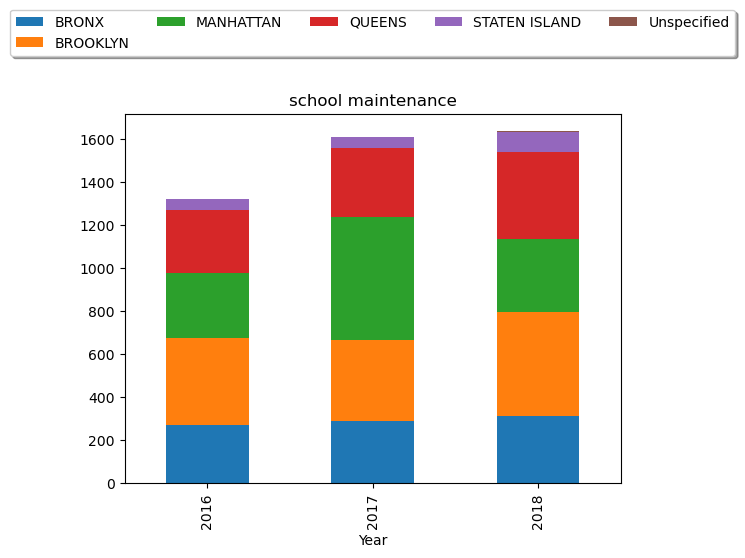

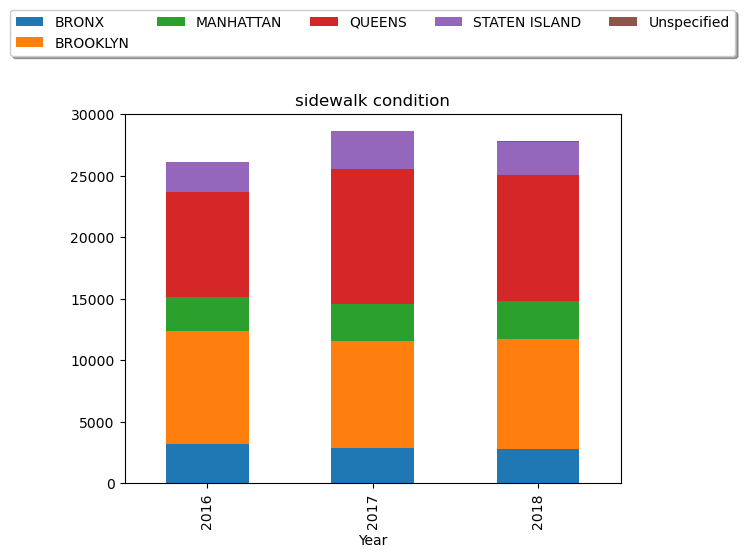

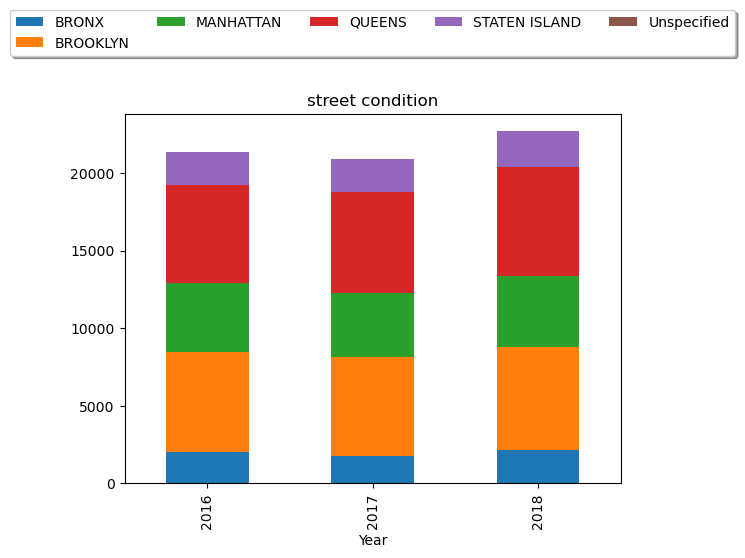

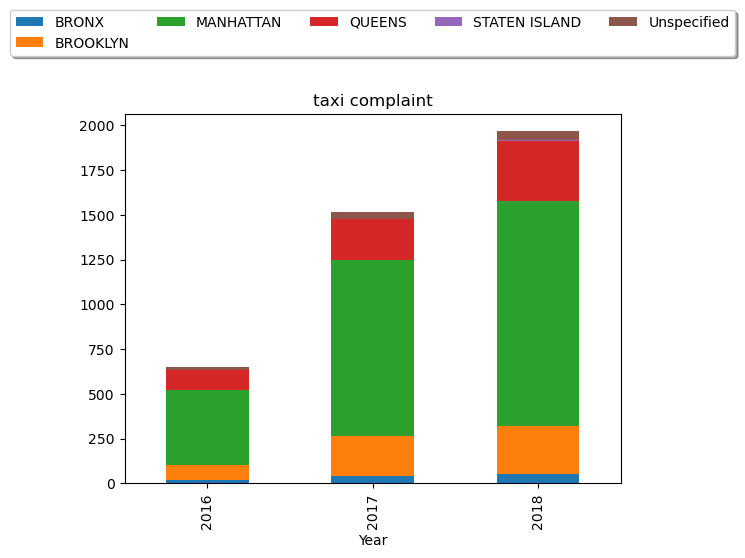

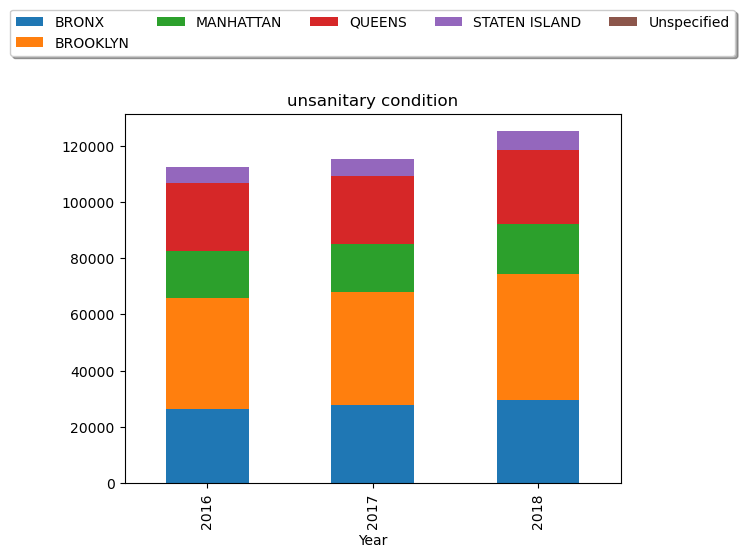

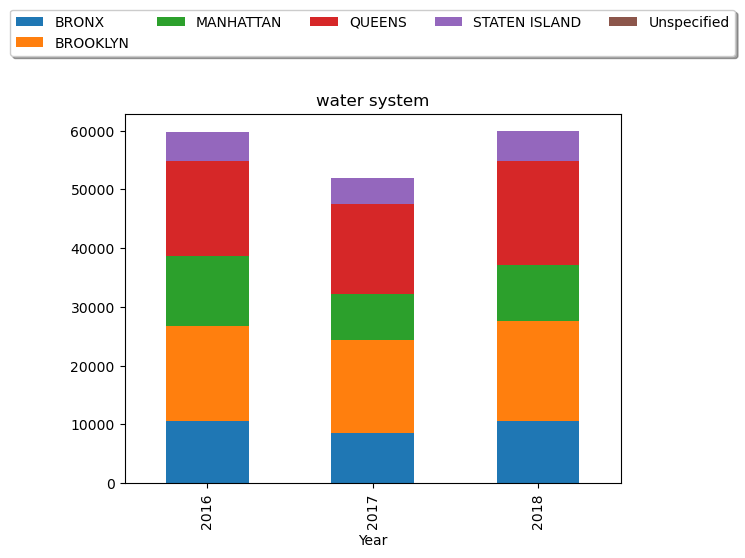

In [72]:
df_complaint_per_year = df_top2.groupby(['Complaint Type', 'Year', 'Borough']).agg(Count = ('City','count')).reset_index()
for i in df_complaint_per_year['Complaint Type'].unique():
    agency_counts_month = df_complaint_per_year[df_complaint_per_year['Complaint Type'] == i]
    del agency_counts_month['Complaint Type']
    agency_counts_month = pd.pivot_table(agency_counts_month, index = 'Year', values = 'Count', columns = 'Borough')
    agency_counts_month.plot.bar(stacked = True)
    plt.title(i)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fancybox=True, shadow=True, ncol=5)

Word cloud for large bulky item collection requests

In [73]:
df_311[df_311['Complaint Type'] == 'request large bulky item collection']

Unique Key        Created Date         Closed Date Agency  \
3661430    37324160 2017-10-01 14:30:00 2017-10-04 00:00:00   DSNY   
3661431    37533406 2017-10-27 10:55:00 2017-12-01 11:51:00   DSNY   
3661432    37629335 2017-11-07 16:44:00 2017-12-01 00:00:00   DSNY   
3661433    37666550 2017-11-12 18:37:00 2017-12-01 00:00:00   DSNY   
3661434    37676365 2017-11-12 12:46:00 2017-12-01 23:14:00   DSNY   
...             ...                 ...                 ...    ...   
3888200    38237845 2018-01-17 22:25:00 2018-01-20 00:00:00   DSNY   
3888201    38237847 2018-01-17 19:46:00 2018-01-19 00:00:00   DSNY   
3888202    38237848 2018-01-17 19:13:00 2018-01-23 00:00:00   DSNY   
3888203    38237849 2018-01-17 16:27:00 2018-01-19 00:00:00   DSNY   
3888204    38237850 2018-01-17 15:13:00 2018-01-19 00:00:00   DSNY   

                              Complaint Type  \
3661430  request large bulky item collection   
3661431  request large bulky item collection   
3661432  request large bulky item collection   
3661433  request large bulky item collection   
3661434  request large bulky item collection   
...                                      ...   
3888200  request large bulky item collection   
3888201  request large bulky item collection   
3888202  request large bulky item collection   
3888203  request large bulky item collection   
3888204  request large bulky item collection   

                                  Descriptor Location Type Incident Zip  \
3661430  Request Large Bulky Item Collection      Sidewalk      11226.0   
3661431  Request Large Bulky Item Collection      Sidewalk      11428.0   
3661432  Request Large Bulky Item Collection      Sidewalk      10014.0   
3661433  Request Large Bulky Item Collection      Sidewalk      11249.0   
3661434  Request Large Bulky Item Collection      Sidewalk      11385.0   
...                                      ...           ...          ...   
3888200  Request Large Bulky Item Collection      Sidewalk        11211   
3888201  Request Large Bulky Item Collection      Sidewalk        10010   
3888202  Request Large Bulky Item Collection      Sidewalk        11105   
3888203  Request Large Bulky Item Collection      Sidewalk        11206   
3888204  Request Large Bulky Item Collection      Sidewalk        11213   

                   City Due Date  ...    Borough   Latitude  Longitude  \
3661430        BROOKLYN      NaT  ...   BROOKLYN  40.652010 -73.965410   
3661431  Queens Village      NaT  ...     QUEENS  40.719406 -73.744448   
3661432        NEW YORK      NaT  ...  MANHATTAN  40.732198 -74.002031   
3661433        BROOKLYN      NaT  ...   BROOKLYN  40.712211 -73.964632   
3661434       Ridgewood      NaT  ...     QUEENS  40.702109 -73.889639   
...                 ...      ...  ...        ...        ...        ...   
3888200        BROOKLYN      NaT  ...   BROOKLYN  40.711138 -73.952286   
3888201        NEW YORK      NaT  ...  MANHATTAN  40.736017 -73.979028   
3888202         Astoria      NaT  ...     QUEENS  40.775951 -73.919185   
3888203        BROOKLYN      NaT  ...   BROOKLYN  40.708303 -73.945060   
3888204        BROOKLYN      NaT  ...   BROOKLYN  40.664895 -73.941819   

              Time taken  Year  Month  Day  Hour  Weekday      Y-M  
3661430  2 days 09:30:00  2017     10    1    14        6  2017-10  
3661431 35 days 00:56:00  2017     10   27    10        4  2017-10  
3661432 23 days 07:16:00  2017     11    7    16        1  2017-11  
3661433 18 days 05:23:00  2017     11   12    18        6  2017-11  
3661434 19 days 10:28:00  2017     11   12    12        6  2017-11  
...                  ...   ...    ...  ...   ...      ...      ...  
3888200  2 days 01:35:00  2018      1   17    22        2   2018-1  
3888201  1 days 04:14:00  2018      1   17    19        2   2018-1  
3888202  5 days 04:47:00  2018      1   17    19        2   2018-1  
3888203  1 days 07:33:00  2018      1   17    16        2   2018-1  
3888204  1 days 08:47:00  2018      1   17

In [74]:
df_311[df_311['Complaint Type'] == 'request large bulky item collection']['Resolution Description']

3661430    NaN
3661431    NaN
3661432    NaN
3661433    NaN
3661434    NaN
          ... 
3888200    NaN
3888201    NaN
3888202    NaN
3888203    NaN
3888204    NaN
Name: Resolution Description, Length: 226775, dtype: object

In [75]:
df_311_large_items = list(df_311[df_311['Complaint Type'] == 'request large bulky item collection']['Resolution Description'].dropna())
print(len(df_311_large_items))

0


A similar analysis, but looking for seasonalities and outliers on a year-month level for the top-2 complaints across agencies.

Key Findings:

1. City placcard complaints stopped from May 2017
2. March, Nov of 2018 had a suspiciously high number of damaged tree complaints. Was there a storm ?
3. We can also see that damaged tree requests increase steadily from Jan - July and then reduces at the same rate. The same can be said for maintenance/facility, noise, rodent and food establishment
3. March, June of 2018 had a suspiciously high number of dof-property payment issues
4. The school facilities have a lot of complaints in the month of September.

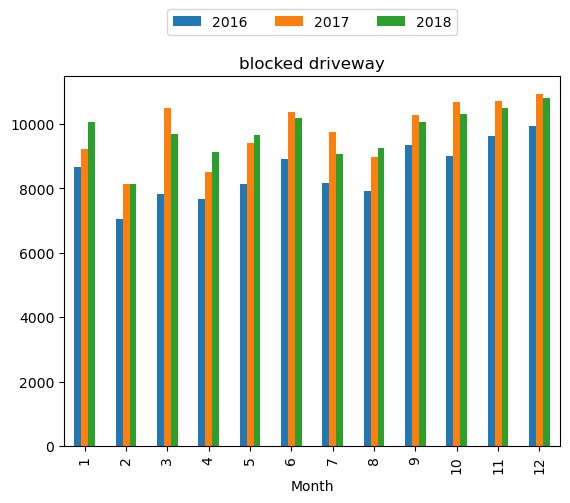

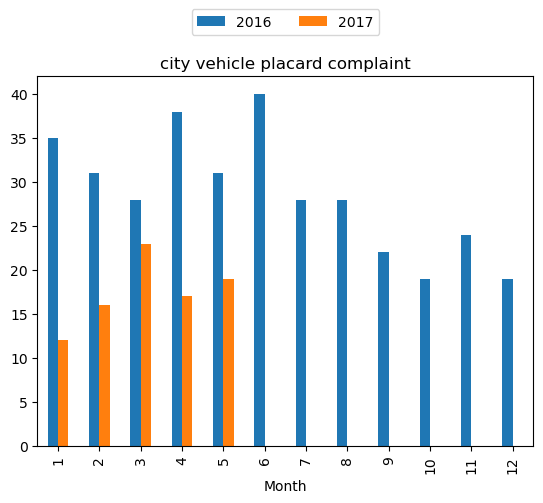

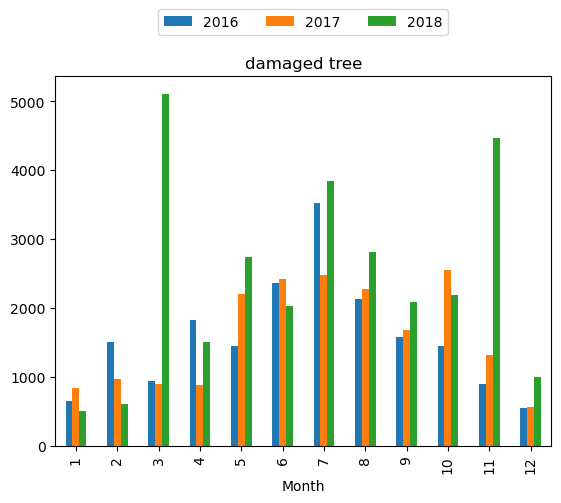

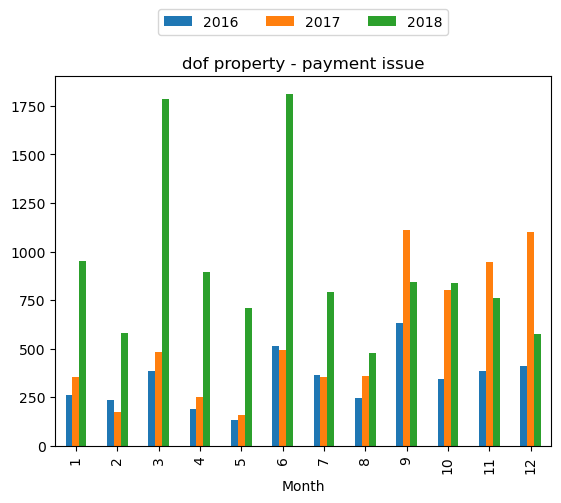

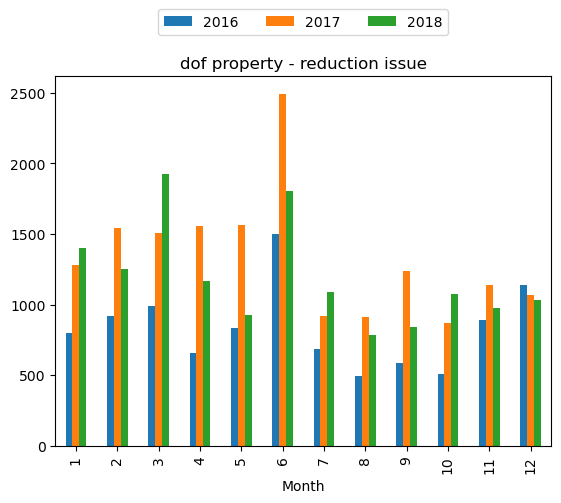

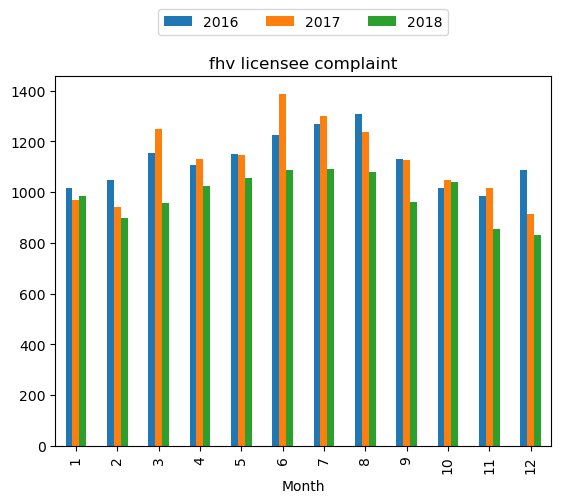

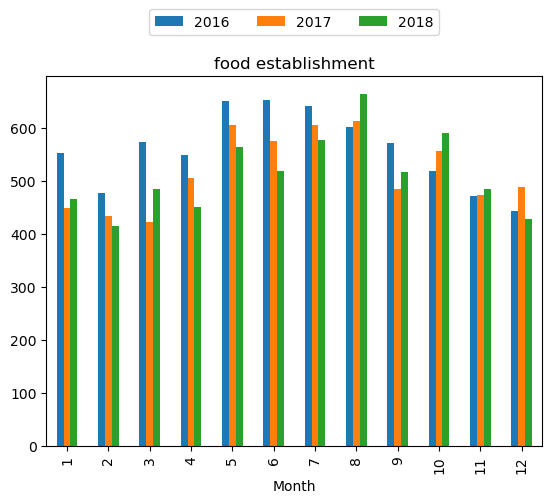

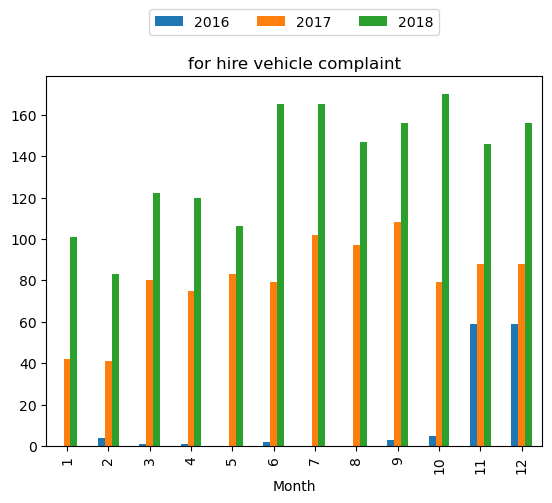

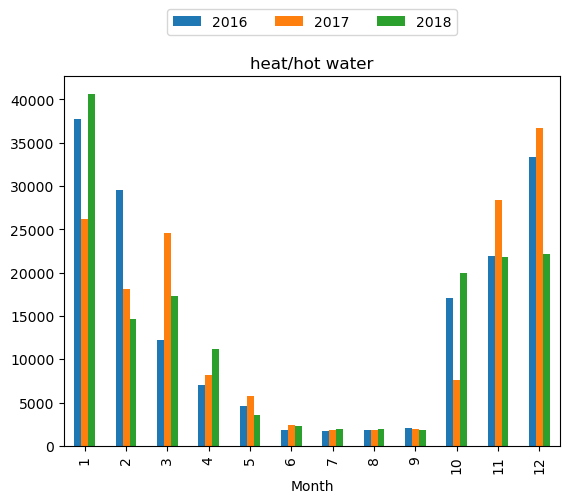

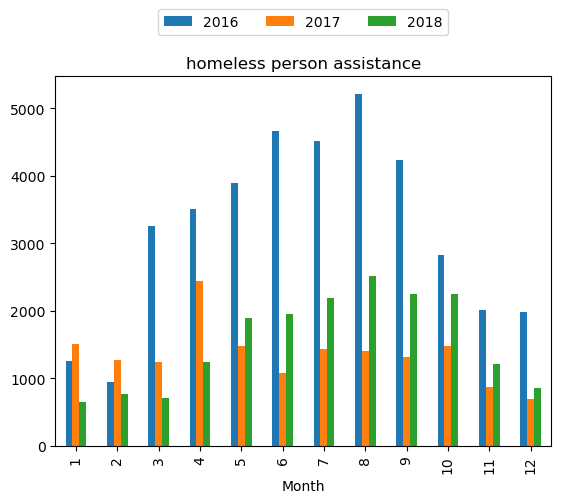

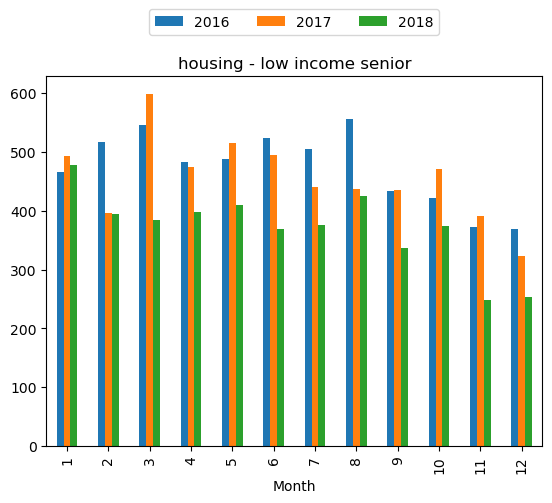

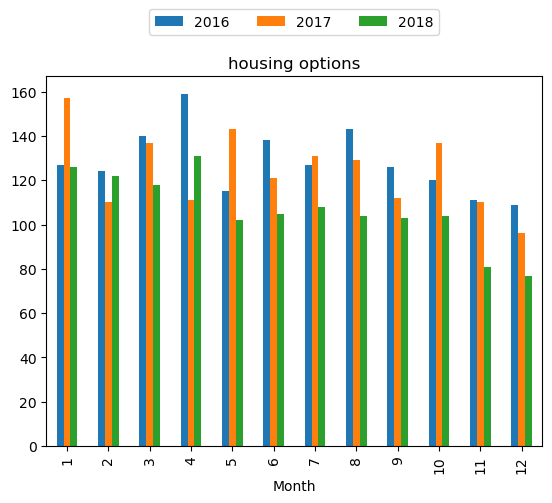

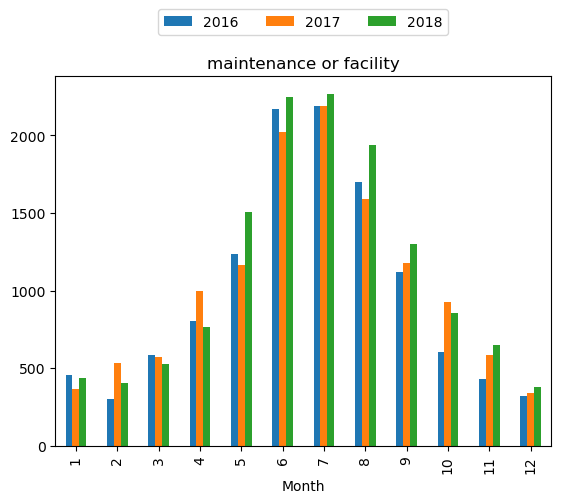

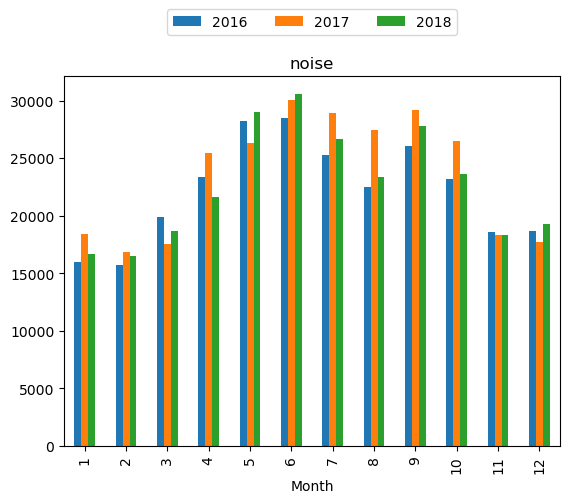

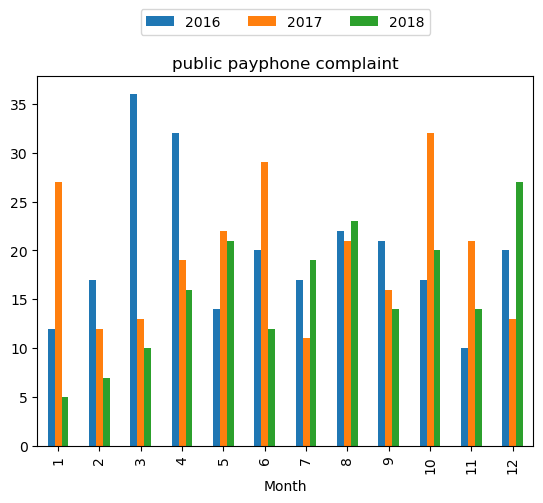

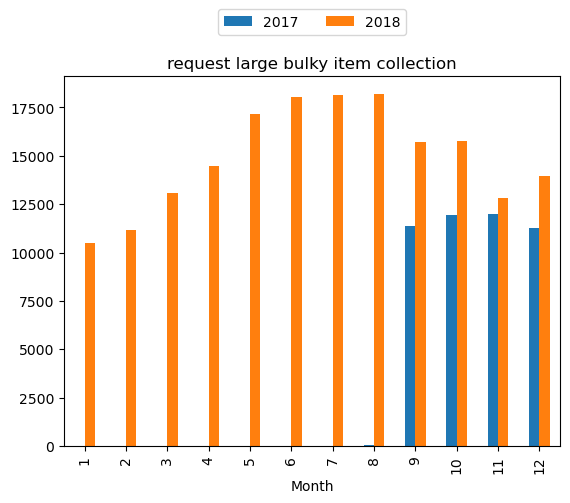

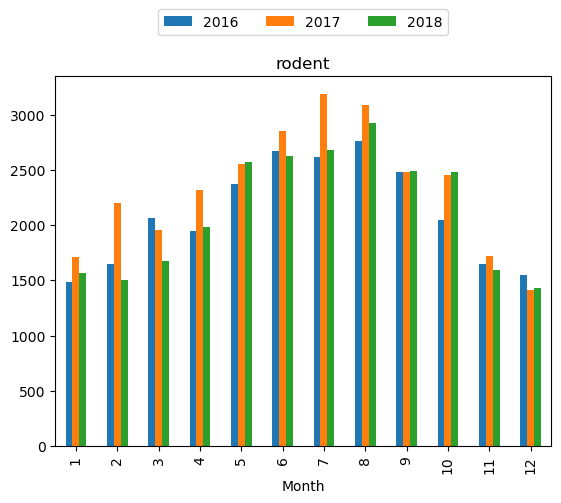

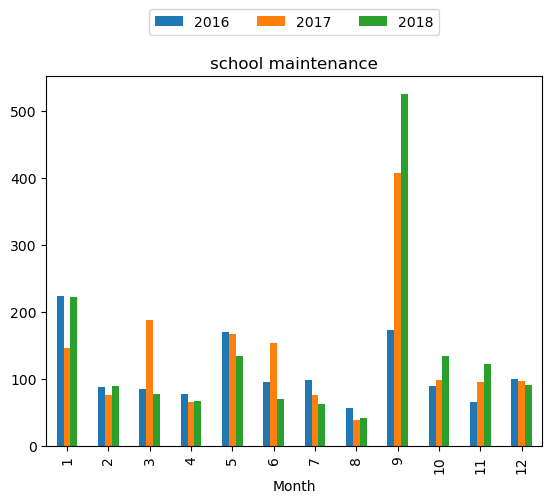

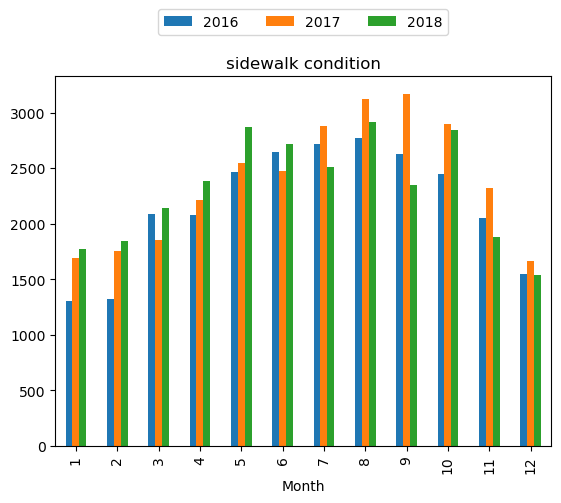

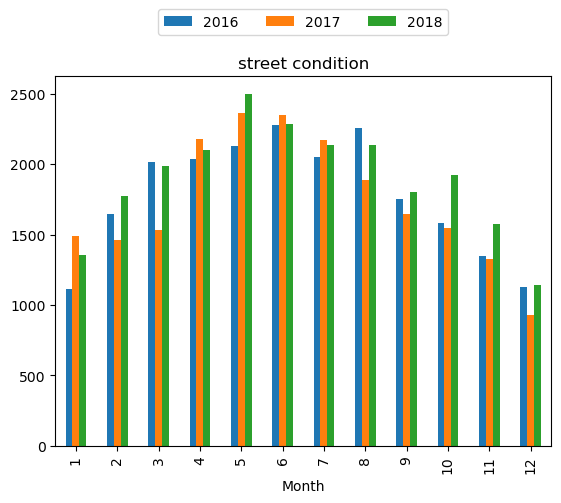

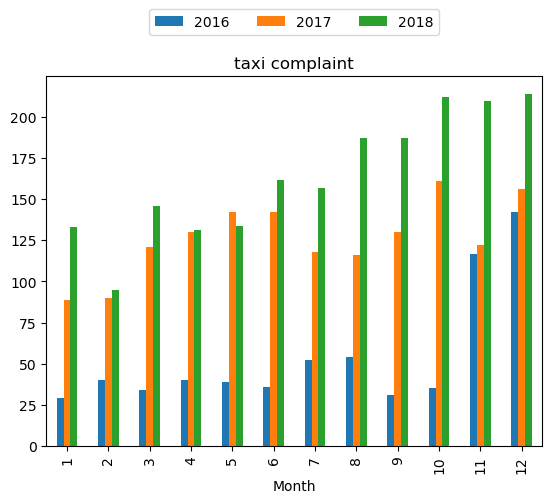

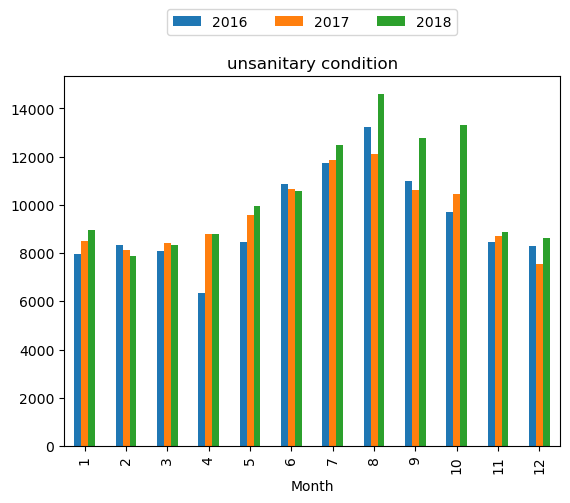

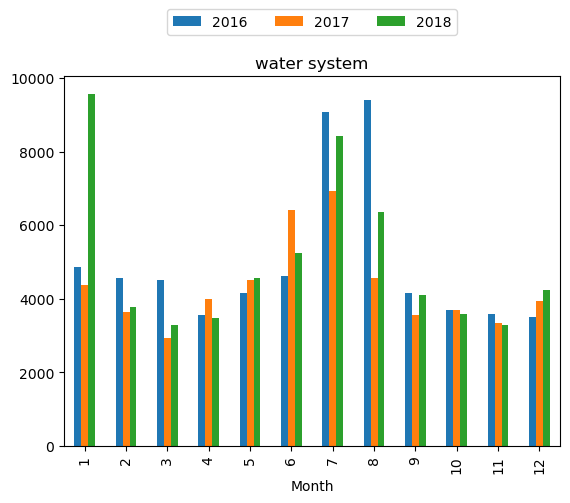

In [76]:
df_complaint_per_year = df_top2.groupby(['Complaint Type', 'Year', 'Month']).agg(Count = ('City','count')).reset_index()
for i in df_complaint_per_year['Complaint Type'].unique():
    agency_counts_month = df_complaint_per_year[df_complaint_per_year['Complaint Type'] == i]
    del agency_counts_month['Complaint Type']
    agency_counts_month = pd.pivot_table(agency_counts_month, values = 'Count', columns = 'Year', fill_value = 0, index = 'Month')
    agency_counts_month.plot.bar()
    plt.title(i)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, shadow=False, ncol=5)
    plt.xticks(rotation=90)
    plt.show()

Visualizing a subset of these complaints on the map

In [77]:
subset_complaints = ['maintenance or facility', 'homeless person', 'heat/hot water', 'damaged tree']

for idx, i in enumerate(tqdm(subset_complaints)):
    df_comp = df_311[df_311['Complaint Type'] == i]
    df_comp = df_comp.groupby(['Borough', 'Y-M']).agg(Count = ('City', 'count')).reset_index().sort_values('Y-M')
    i = i.replace('/', '')
    makeNYCPlot(df_comp, f'Boro - {i}', 'Y-M', 'Borough', True)

100%|██████████| 4/4 [01:12<00:00, 18.05s/it]


In [78]:
df_311['Location Type'].value_counts()

RESIDENTIAL BUILDING             1357909
Street/Sidewalk                  1041154
Sidewalk                          548795
Street                            464479
Residential Building/House        445023
                                  ...   
Government Building - Foreign          2
Correctional Facility - State          2
Health Club                            1
Cemetery                               1
Veterinarian's Office                  1
Name: Location Type, Length: 152, dtype: int64

We perform a similar analysis, but now on location types and see that the number of distinct location drop from 152 to 100

In [79]:
location_types = df_311['Location Type'].dropna().unique()

location_types = [i.lower() for i in location_types] 

mapper = {}
value_set = set()
key_set = set()

for i in location_types:
    for j in location_types:

        value = fuzz.partial_ratio(i, j)

        if value > 80 and i != j:
            if i in key_set or i in value_set or j in key_set or j in value_set:
                if i in key_set:
                    mapper[i] = j
                if j in key_set:
                    mapper[j] = i
                if i in value_set:
                    mapper[j] = i
                if j in value_set:
                    mapper[i] = j

            else:
                mapper[i] = j
                key_set.add(i)
                value_set.add(j)



In [80]:
for k,v in mapper.items():
    df_311['Location Type'] = df_311['Location Type'].replace(k, v)

In [81]:
df_311['Location Type'].value_counts()

RESIDENTIAL BUILDING             1357909
Street/Sidewalk                  1041154
Sidewalk                          548795
Street                            464479
Residential Building/House        445023
                                  ...   
Government Building - Foreign          2
Correctional Facility - State          2
Health Club                            1
Cemetery                               1
Veterinarian's Office                  1
Name: Location Type, Length: 152, dtype: int64

In [82]:
top10 = list(df_311['Location Type'].value_counts().index)[:10]
df_top10 = df_311[df_311['Location Type'].isin(top10)]

A word cloud of the most common complaints from the top 10 location types

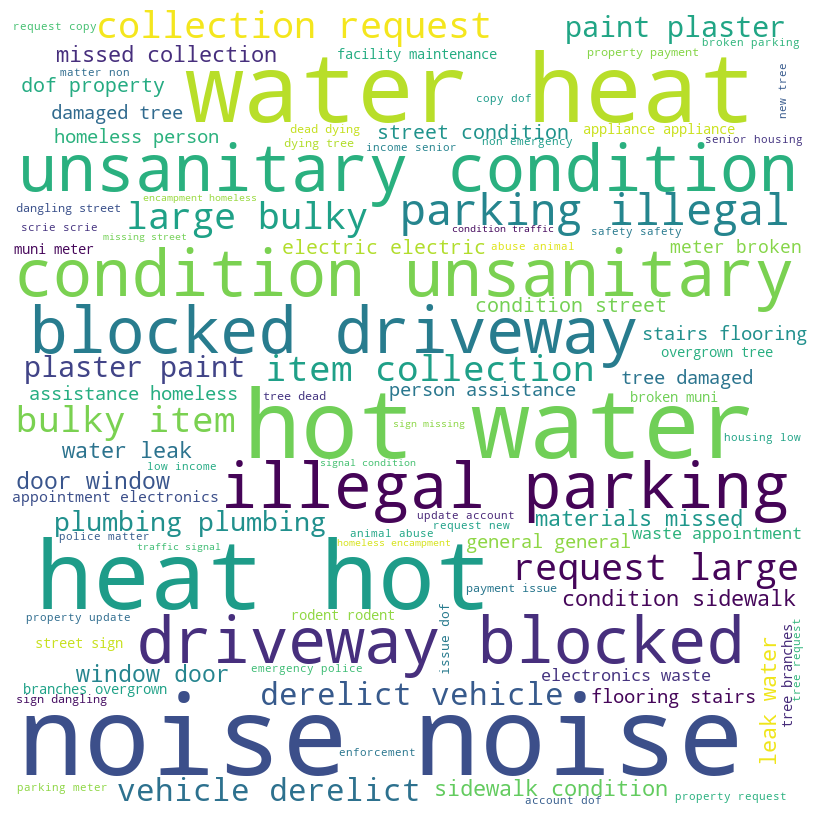

In [83]:
words = ""

stopwords = set(STOPWORDS)
for val in df_top10['Complaint Type']:
     
    val = str(val)
    val = val.lower()
    tokens = val.split()
     
    words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(words)
                 
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Plotting the trends based on location type across each borough and year

Key Findings:

1. Family home problems are most dominant in Queens and least in Manhattan
2. Address based location problems are seeing an increasing trend
3. Public Garden/Park based problems now have an unspecified borough only for 2018. Is there something wrong while collecting the data
4. Restaurant based problems are decreasing
5. Problems on the sidewalk have increased dramatically in 2018
6. Store based problems are decreasing and Manhattan seems to be the dominant borough for such problems

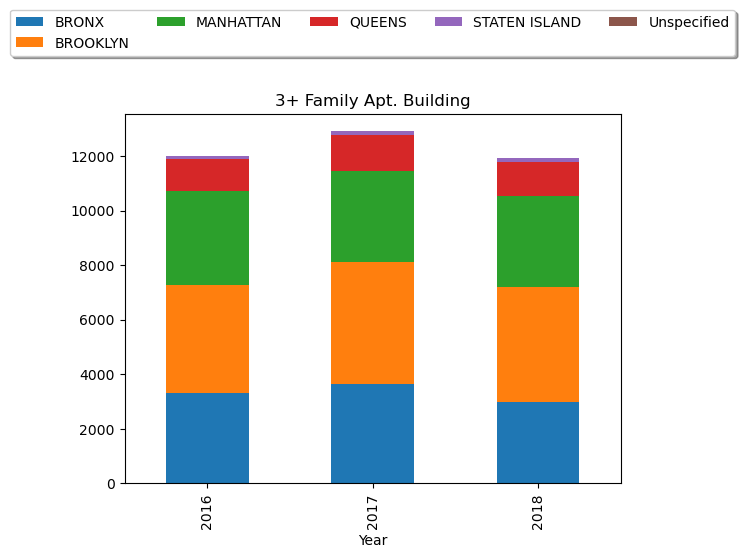

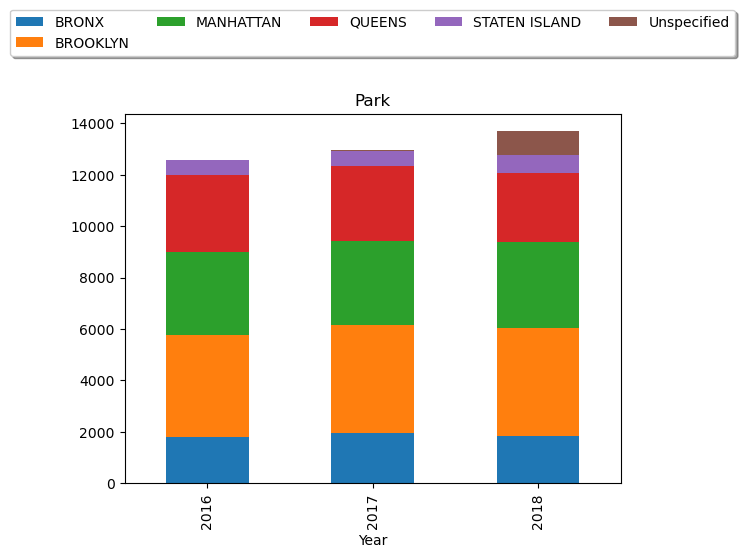

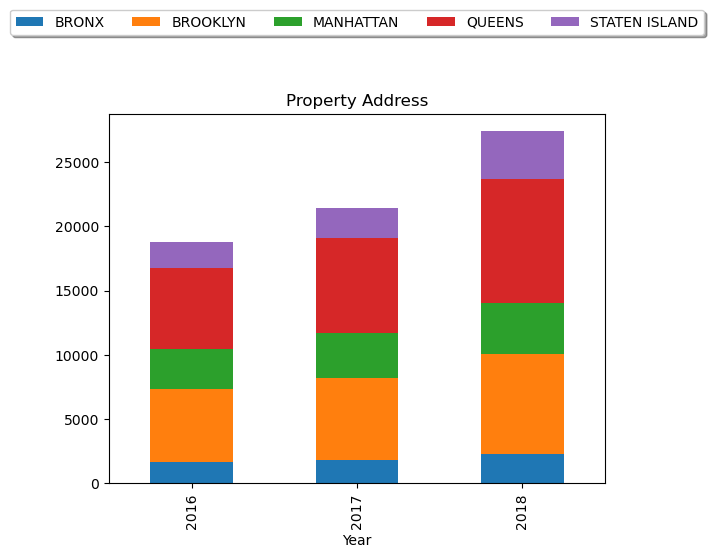

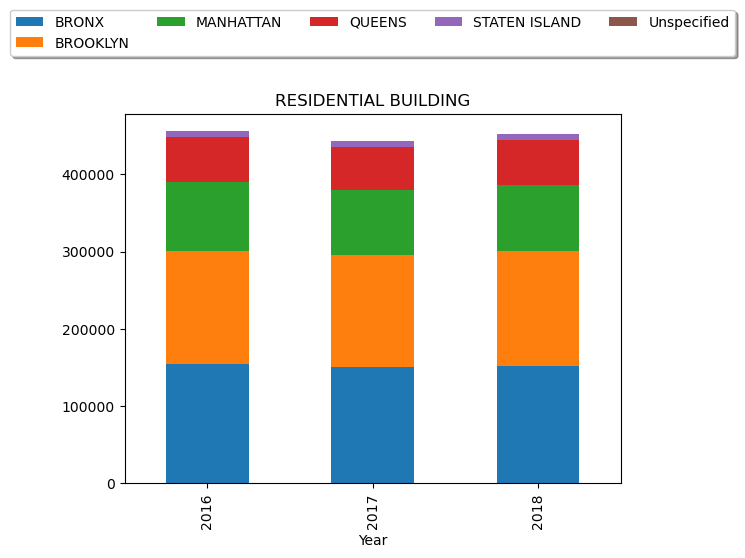

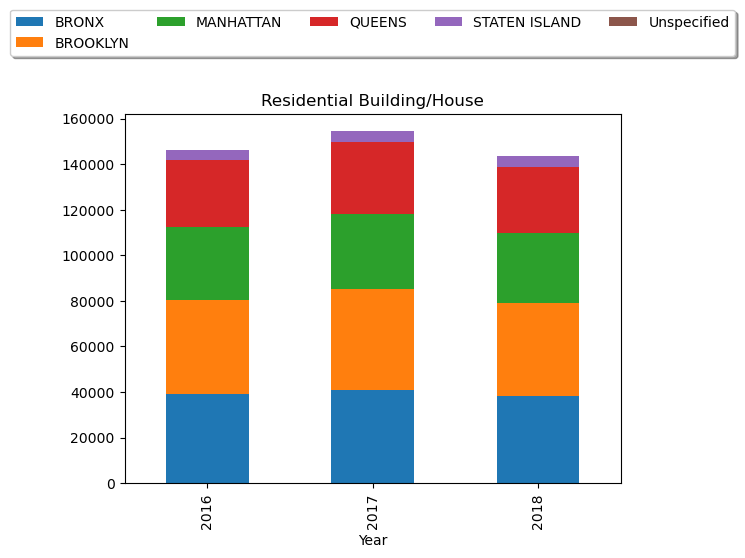

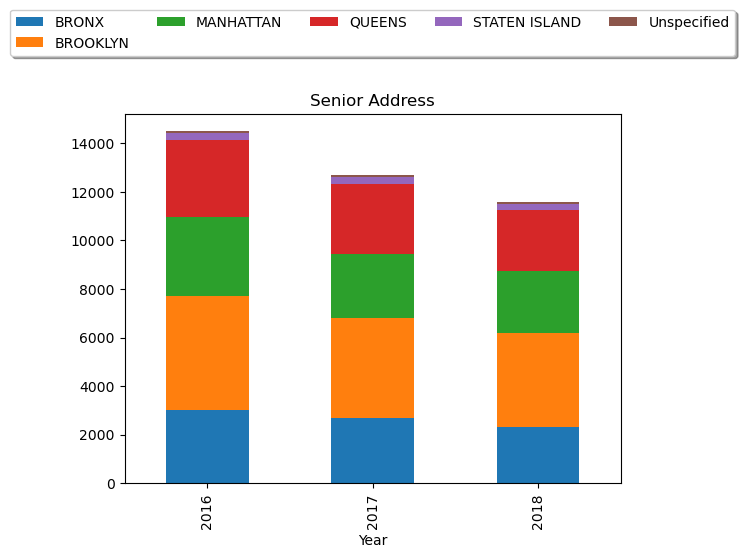

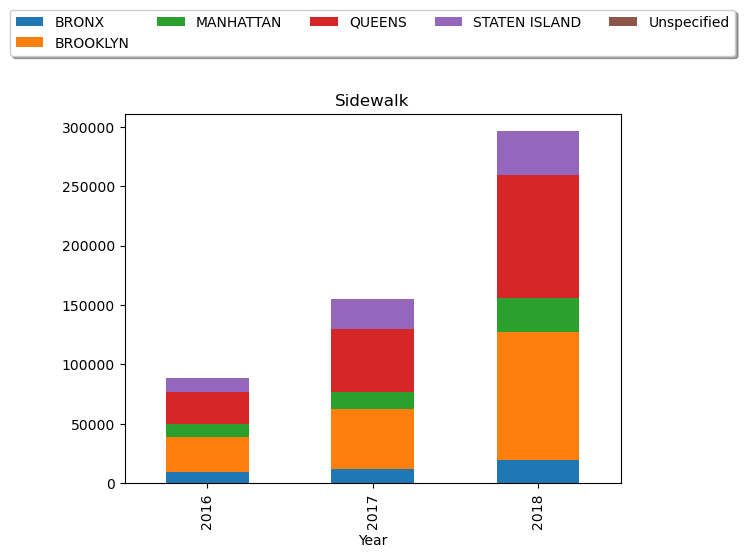

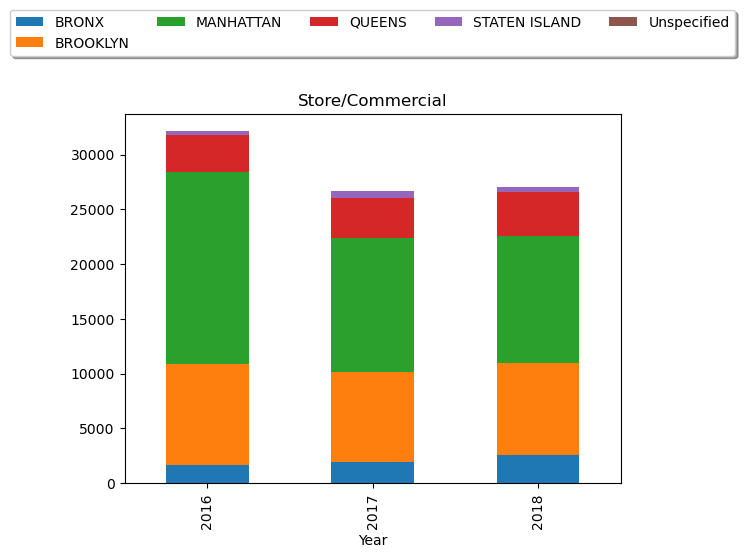

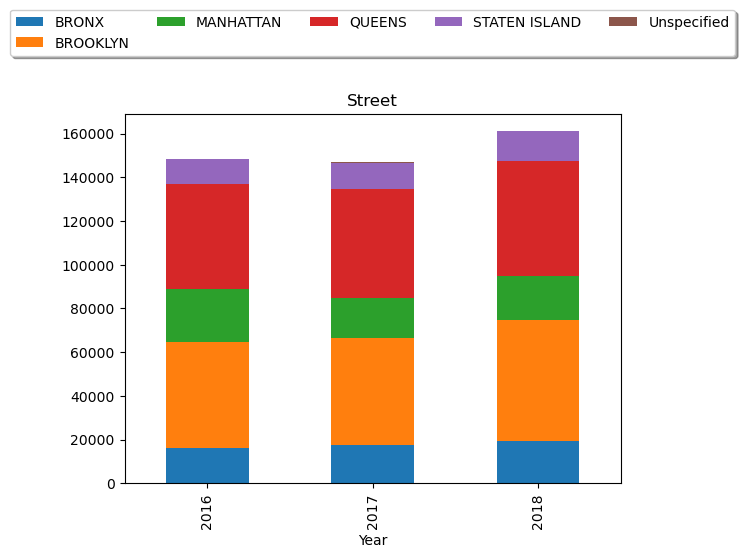

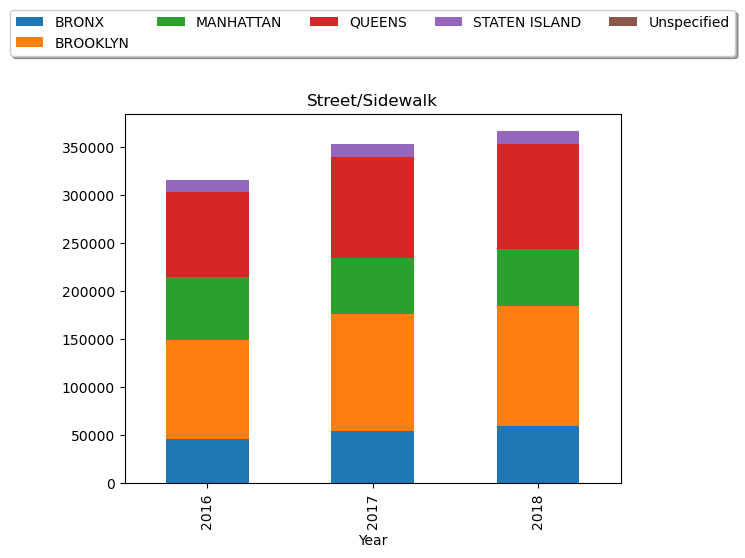

In [84]:
df_complaint_per_year = df_top10.groupby(['Location Type', 'Year', 'Borough']).agg(Count = ('City','count')).reset_index()
for i in df_complaint_per_year['Location Type'].unique():
    agency_counts_month = df_complaint_per_year[df_complaint_per_year['Location Type'] == i]
    del agency_counts_month['Location Type']
    agency_counts_month = pd.pivot_table(agency_counts_month, index = 'Year', values = 'Count', columns = 'Borough')
    agency_counts_month.plot.bar(stacked = True)
    plt.title(i)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fancybox=True, shadow=True, ncol=5)

In [85]:
df_calls_daily = df_311.groupby(['Year', 'Month', 'Day']).agg(Count = ('City', 'count')).reset_index()
df_311['Y-M-d'] = df_311['Year'].astype(str) + '-' + df_311['Month'].astype(str) + '-' + df_311['Day'].astype(str)
df_311['Y-M-d'] = pd.to_datetime(df_311['Y-M-d'])

In [86]:
df_calls_daily['Y-M-d'] = df_calls_daily['Year'].astype(str) + '-' + df_calls_daily['Month'].astype(str) + '-' + df_calls_daily['Day'].astype(str)
df_calls_daily['Y-M-d'] = pd.to_datetime(df_calls_daily['Y-M-d'])
df_calls_daily

Year  Month  Day  Count      Y-M-d
0     2016      1    1   2780 2016-01-01
1     2016      1    2   3060 2016-01-02
2     2016      1    3   3095 2016-01-03
3     2016      1    4   5963 2016-01-04
4     2016      1    5   8111 2016-01-05
...    ...    ...  ...    ...        ...
1091  2018     12   27   4733 2018-12-27
1092  2018     12   28   4294 2018-12-28
1093  2018     12   29   3492 2018-12-29
1094  2018     12   30   3500 2018-12-30
1095  2018     12   31   4029 2018-12-31

[1096 rows x 5 columns]

Removing unncessary columns and also visualizing the number of calls made on a daily basis. We can see somewhat of an increasing trend.

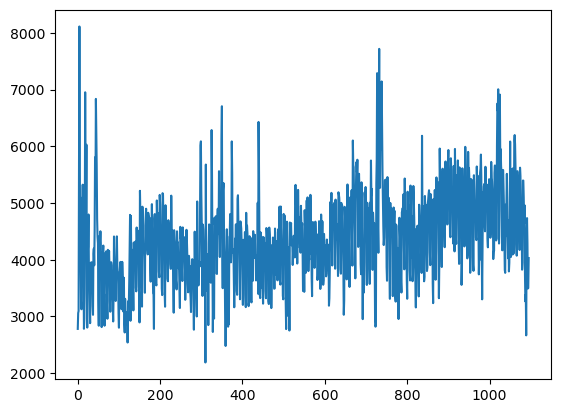

In [87]:
del df_calls_daily['Year']
del df_calls_daily['Month']
del df_calls_daily['Day']

plt.plot(range(len(df_calls_daily)), df_calls_daily['Count'])

In [88]:
df_311.to_csv('311_calls.csv', index = False)

## Analysing weather data

In [89]:
df_weather = pd.read_parquet('weather_NY_2010_2018Nov.parquet')
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather.groupby(['SID']).agg({'Latitude': 'nunique', 'Longitude': 'nunique', 'MeanTemp': 'count', 'MinTemp': 'count'
                                                        , 'MaxTemp': 'count'}).reset_index()

SID  Latitude  Longitude  MeanTemp  MinTemp  MaxTemp
0   720553-99999         1          1       781      780      781
1   722098-64761         1          1      2396     2372     2372
2   724988-94704         1          1      3231     3231     3231
3   725014-54780         1          1      3229     3228     3229
4    725015-4789         1          1      3221     3221     3221
..           ...       ...        ...       ...      ...      ...
57  998267-99999         1          1      2717     2717     2717
58  998435-99999         1          1      2707     2707     2707
59  998436-99999         1          1      1210     1210     1210
60  999999-64756         1          1      2911     2911     2911
61  999999-64758         1          1      2911     2911     2911

[62 rows x 6 columns]

Finding the Min, Max and Mean Latitude, Longitude values for each borough. This would help us computing the boundaries

In [90]:
borough_locations = df_311.groupby('Borough').agg({'Latitude': ['min', 'max', 'mean'], 'Longitude': ['min', 'max', 'mean']})
borough_locations.columns = ["_".join(i) for i in borough_locations.columns]
borough_locations = borough_locations.reset_index()

borough_locations

Borough  Latitude_min  Latitude_max  Latitude_mean  Longitude_min  \
0          BRONX     40.750011     40.912869      40.849796     -73.948186   
1       BROOKLYN     40.571521     40.739275      40.655095     -74.041484   
2      MANHATTAN     40.687978     40.878413      40.785081     -74.044540   
3         QUEENS     40.552626     40.799836      40.717548     -74.032674   
4  STATEN ISLAND     40.498807     40.648357      40.593252     -74.255211   
5    Unspecified     40.516237     40.905915      40.730391     -74.233422   

   Longitude_max  Longitude_mean  
0     -73.782051      -73.886372  
1     -73.853413      -73.952215  
2     -73.827351      -73.964240  
3     -73.700597      -73.835234  
4     -74.053569      -74.133452  
5     -73.713308      -73.918450

We now find the north-most, south-most, east-most and west-most points for each of the 5 boroughs.

In [91]:
borough_locations['North'] = borough_locations.apply(lambda row: (row['Latitude_max'], (row['Longitude_min'] + row['Longitude_max'])/2), axis = 1)
borough_locations['South'] = borough_locations.apply(lambda row: (row['Latitude_min'], (row['Longitude_min'] + row['Longitude_max'])/2), axis = 1)
borough_locations['East'] = borough_locations.apply(lambda row: ((row['Latitude_min'] + row['Latitude_max'])/2 , row['Longitude_max']), axis = 1)
borough_locations['West'] = borough_locations.apply(lambda row: ((row['Latitude_min'] + row['Latitude_max'])/2 , row['Longitude_min']), axis = 1)
borough_locations['Centre'] = borough_locations.apply(lambda row: ((row['Latitude_min'] + row['Latitude_max'])/2, (row['Longitude_min'] + row['Longitude_max'])/2), axis = 1)

borough_locations

Borough  Latitude_min  Latitude_max  Latitude_mean  Longitude_min  \
0          BRONX     40.750011     40.912869      40.849796     -73.948186   
1       BROOKLYN     40.571521     40.739275      40.655095     -74.041484   
2      MANHATTAN     40.687978     40.878413      40.785081     -74.044540   
3         QUEENS     40.552626     40.799836      40.717548     -74.032674   
4  STATEN ISLAND     40.498807     40.648357      40.593252     -74.255211   
5    Unspecified     40.516237     40.905915      40.730391     -74.233422   

   Longitude_max  Longitude_mean                                     North  \
0     -73.782051      -73.886372  (40.912868795316655, -73.86511878717843)   
1     -73.853413      -73.952215   (40.73927508774351, -73.94744860842475)   
2     -73.827351      -73.964240   (40.87841265638778, -73.93594512195091)   
3     -73.700597      -73.835234   (40.79983555742468, -73.86663537141713)   
4     -74.053569      -74.133452   (40.64835717185496, -74.15438971071731)   
5     -73.713308      -73.918450   (40.90591524819519, -73.97336488740099)   

                                      South  \
0   (40.75001112292069, -73.86511878717843)   
1   (40.57152101432205, -73.94744860842475)   
2    (40.6879784818372, -73.93594512195091)   
3  (40.552625521844114, -73.86663537141713)   
4    (40.4988067008969, -74.15438971071731)   
5   (40.51623730536225, -73.97336488740099)   

                                       East  \
0    (40.83143995911867, -73.7820513284126)   
1  (40.655398051032776, -73.85341332896515)   
2   (40.78319556911249, -73.82735053033966)   
3  (40.676230539634396, -73.70059684703173)   
4   (40.57358193637593, -74.05356859637075)   
5  (40.711076276778726, -73.71330753068295)   

                                       West  \
0   (40.83143995911867, -73.94818624594427)   
1  (40.655398051032776, -74.04148388788435)   
2   (40.78319556911249, -74.04453971356214)   
3  (40.676230539634396, -74.03267389580253)   
4   (40.57358193637593, -74.25521082506387)   
5  (40.711076276778726, -74.23342224411903)   

                                     Centre  
0   (40.83143995911867, -73.86511878717843)  
1  (40.655398051032776, -73.94744860842475)  
2   (40.78319556911249, -73.93594512195091)  
3  (40.676230539634396, -73.86663537141713)  
4   (40.57358193637593, -74.15438971071731)  
5  (40.711076276778726, -73.97336488740099)

Helper function to calculate the geodesic distance between two points

In [92]:
from math import cos, asin, sqrt, pi

def calculate_distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))

weather_station_location = df_weather.groupby(['SID']).agg({'Latitude': 'unique', 'Longitude': 'unique'}).reset_index()
weather_station_location['Latitude'] = weather_station_location['Latitude'].apply(lambda x: x[0])
weather_station_location['Longitude'] = weather_station_location['Longitude'].apply(lambda x: x[0])

Calculating the average distance between 2 weather stations in NY state

In [93]:
distances = [np.zeros(shape = len(weather_station_location))]

for i in range(0, len(weather_station_location)):
    w1 = weather_station_location.loc[i, :]
    for j in range(0, len(weather_station_location)):
        w2 = weather_station_location.loc[j, :]
        distances[i][j] = calculate_distance(w1['Latitude'], w1['Longitude'], w2['Latitude'], w2['Longitude'])

    distances.append(np.zeros(shape = len(weather_station_location)))

distances = np.array(distances)

In [94]:
tot = 0
for i in range(len(distances)):
    for j in range(0, i):
        tot += distances[i][j]

print('Average distance between 2 stations:', round(2 * tot / (len(distances) * (len(distances)-1)), 2))

Average distance between 2 stations: 273.6


Given the high distance we must find the neighboring subset of stations

In [95]:
borough_station_distance_north = []
borough_station_distance_south = []
borough_station_distance_east = []
borough_station_distance_west = []
borough_station_distance_centre = []

for i in range(0, len(borough_locations)):
    w1 = borough_locations.loc[i, :]
    
    borough_station_distance_north.append(np.zeros(shape = len(weather_station_location)))
    borough_station_distance_south.append(np.zeros(shape = len(weather_station_location)))
    borough_station_distance_east.append(np.zeros(shape = len(weather_station_location)))
    borough_station_distance_west.append(np.zeros(shape = len(weather_station_location)))
    borough_station_distance_centre.append(np.zeros(shape = len(weather_station_location)))

    for j in range(0, len(weather_station_location)):
        w2 = weather_station_location.loc[j, :]
        borough_station_distance_north[i][j] = (calculate_distance(w1['North'][0], w1['North'][1], w2['Latitude'], w2['Longitude']))
        borough_station_distance_south[i][j] = (calculate_distance(w1['South'][0], w1['South'][1], w2['Latitude'], w2['Longitude']))
        borough_station_distance_east[i][j] = (calculate_distance(w1['East'][0], w1['East'][1], w2['Latitude'], w2['Longitude']))
        borough_station_distance_west[i][j] = (calculate_distance(w1['West'][0], w1['West'][1], w2['Latitude'], w2['Longitude']))
        borough_station_distance_centre[i][j] = (calculate_distance(w1['Centre'][0], w1['Centre'][1], w2['Latitude'], w2['Longitude']))

borough_station_distance_north = np.array(borough_station_distance_north)
borough_station_distance_south = np.array(borough_station_distance_south)
borough_station_distance_east = np.array(borough_station_distance_east)
borough_station_distance_west = np.array(borough_station_distance_west)
borough_station_distance_centre = np.array(borough_station_distance_centre)

north_centres = set(borough_station_distance_north.argsort(axis = 1)[:, 0:5].flatten())
south_centres = set(borough_station_distance_south.argsort(axis = 1)[:, 0:5].flatten())
east_centres = set(borough_station_distance_east.argsort(axis = 1)[:, 0:5].flatten())
west_centres = set(borough_station_distance_west.argsort(axis = 1)[:, 0:5].flatten())
centres = set(borough_station_distance_centre.argsort(axis = 1)[:, 0:5].flatten())

Find the 5 nearest stations (neighbors) to each borough

In [96]:
all_stations = list(north_centres.union(south_centres).union(east_centres).union(west_centres).union(centres))
stations_NYC = weather_station_location.loc[all_stations, :]
stations_NYC

SID  Latitude  Longitude
0   720553-99999    40.701    -74.009
6   725030-14732    40.779    -73.880
7   725033-94728    40.779    -73.969
8   725033-99999    40.767    -73.983
15  725053-94728    40.779    -73.969
16  725060-94728    40.779    -73.969
42  744860-94789    40.639    -73.762
43  744864-54787    40.734    -73.417
47  997271-99999    40.701    -74.014
48  997272-99999    40.639    -74.146
49  997280-99999    40.800    -73.770

Plotting these station coordinates on a map to ensure we are looking at the correct ones.

In [97]:
fig = px.scatter_geo(stations_NYC,lat='Latitude',lon='Longitude', hover_name="SID")
fig.update_layout(title = 'NYC', title_x=0.5)

fig.update_layout(
        geo = dict(
            projection_scale=10,
            center=dict(lat=40.78, lon=-73.97),
        ))

fig.show()

Checking for null values in the dataset

In [98]:
df_weather = df_weather[df_weather['SID'].isin(stations_NYC['SID'])]
df_weather.isnull().sum()

USAF                    0
WBAN                    0
StationName             0
State                   0
Latitude                0
Longitude               0
MeanTemp                0
MinTemp                 3
MaxTemp                 2
DewPoint             8692
Percipitation          35
WindSpeed            1209
MaxSustainedWind     4250
Gust                12879
Rain                    0
SnowDepth           21602
SnowIce                 0
Year                    0
Month                   0
Day                     0
SID                     0
Date                    0
dtype: int64

Explainability being a key factor in our dowstream application, we remove the collinear variables by looking at the correlation table below

In [99]:
corr = df_weather.corr()
corr.style.background_gradient(cmap='coolwarm')

Understanding and verifying the relationships between variables

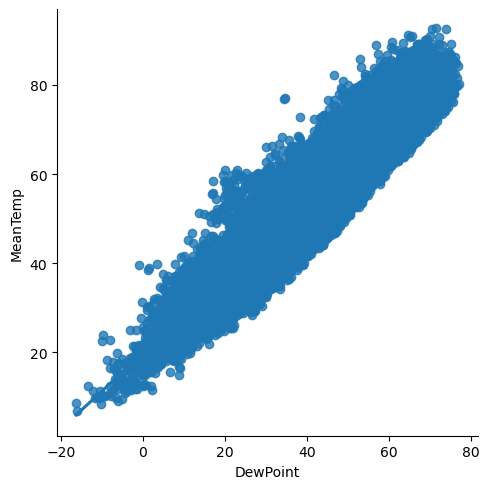

In [100]:
sns.lmplot(data = df_weather, x = 'DewPoint', y = 'MeanTemp')

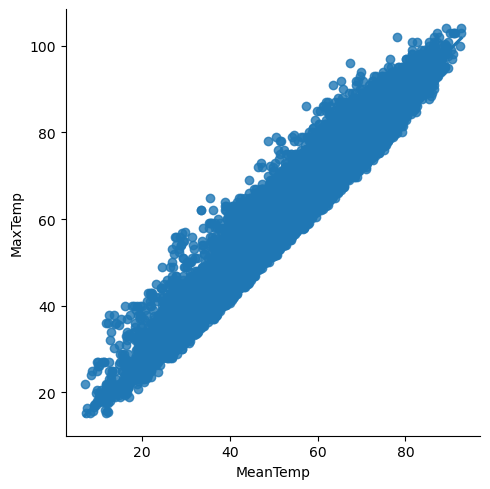

In [101]:
sns.lmplot(data = df_weather, x = 'MeanTemp', y = 'MaxTemp')

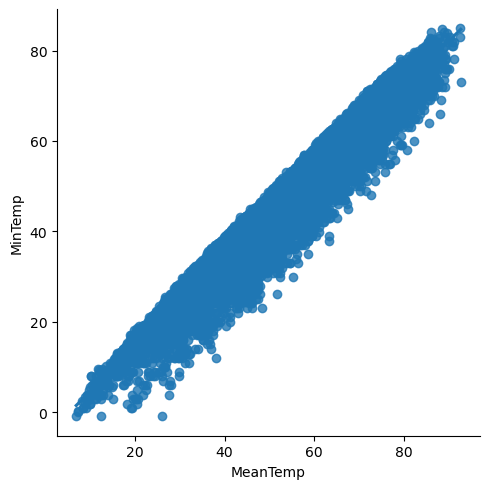

In [102]:
sns.lmplot(data = df_weather, x = 'MeanTemp', y = 'MinTemp')

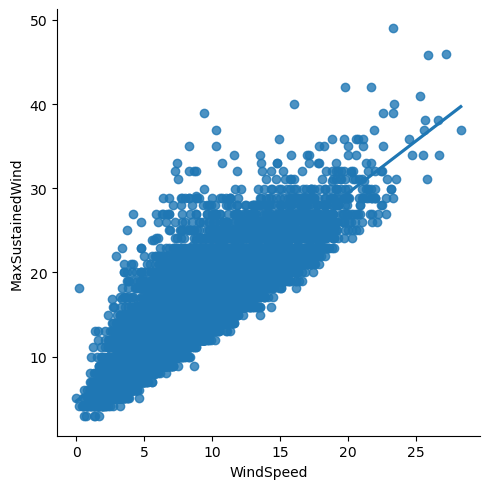

In [103]:
sns.lmplot(data = df_weather, x = 'WindSpeed', y = 'MaxSustainedWind')

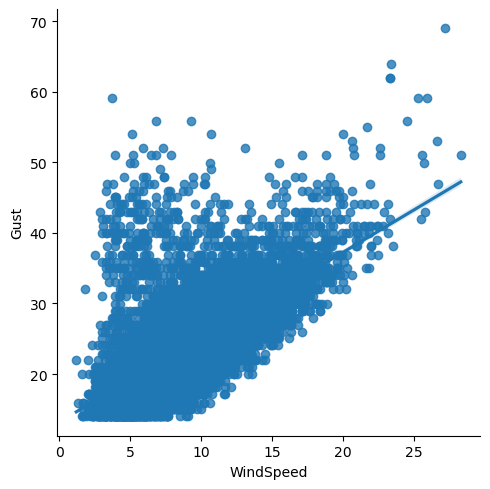

In [104]:
sns.lmplot(data = df_weather, x = 'WindSpeed', y = 'Gust')

In [105]:
del df_weather['DewPoint']
del df_weather['MaxTemp']
del df_weather['MinTemp']
del df_weather['MaxSustainedWind']
del df_weather['Gust']

Owing to the huge number of null values in Snow Depth, we impute 0 to records by inferring from historical data.

In [106]:
weather_station_location = weather_station_location[weather_station_location['SID'].isin(df_weather['SID'])]
df_weather.groupby('Month').agg({'SnowDepth': 'sum'}).reset_index()

Month  SnowDepth
0       1     1324.5
1       2     1885.6
2       3      540.2
3       4       13.5
4       5        0.0
5       6        0.0
6       7        0.0
7       8        0.0
8       9        0.0
9      10        7.2
10     11       15.8
11     12      285.2

Ways to impute:

1. Months 5-9 did not receive any snowfall based on historical data
2. Since weather highly depends on the month, we impute the null values in wind speed and precipitation using the mean, grouped on month.

In [107]:
df_weather.loc[(df_weather['Month'] >= 5) & (df_weather['Month'] < 10), ['SnowDepth', 'SnowIce']] = 0
df_weather["Percipitation"] = df_weather[["Date", "Percipitation"]].groupby("Date").transform(lambda x: x.fillna(x.mean()))
df_weather["WindSpeed"] = df_weather[["Date", "WindSpeed"]].groupby("Date").transform(lambda x: x.fillna(x.mean()))
df_weather.isnull().sum()

USAF                 0
WBAN                 0
StationName          0
State                0
Latitude             0
Longitude            0
MeanTemp             0
Percipitation        0
WindSpeed            0
Rain                 0
SnowDepth        12229
SnowIce              0
Year                 0
Month                0
Day                  0
SID                  0
Date                 0
dtype: int64

We also impute the values for snow depth using the following assumptions:

1. If more than 50% of the stations record any snow depth we impute the value with their median
2. If more than 80% of the stations mention it is not snowing, we impute SnowDepth as 0

In [108]:
def imputeOtherStations(value):
    if value.isnull().sum() <= len(stations_NYC)/2:
        return value.fillna(value.median())
    else:
        return value

df_weather["SnowDepth"] = df_weather[["Date", "SnowDepth"]].groupby("Date").transform(imputeOtherStations)
df_weather_temp = df_weather[["Date", "SnowDepth", "SnowIce"]].groupby("Date").agg({"SnowIce": "sum", "SnowDepth": "mean"}).reset_index()
df_weather.loc[df_weather["Date"].isin(df_weather_temp[df_weather_temp["SnowIce"] <= math.floor(len(stations_NYC) * 0.2)]["Date"]), "SnowDepth"] = 0
df_weather['SnowDepth'].isnull().sum()

659

Looks like Snow Ice and Snow Depth are noisy features. 
When Snow Ice is 0, Snow Depth > 0 and vice versa

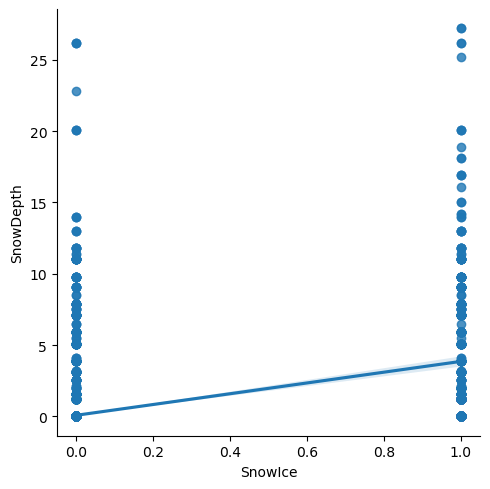

In [109]:
sns.lmplot(data = df_weather, x = 'SnowIce', y = 'SnowDepth')

Checking for the boxplot of Snow Depth

<AxesSubplot:>

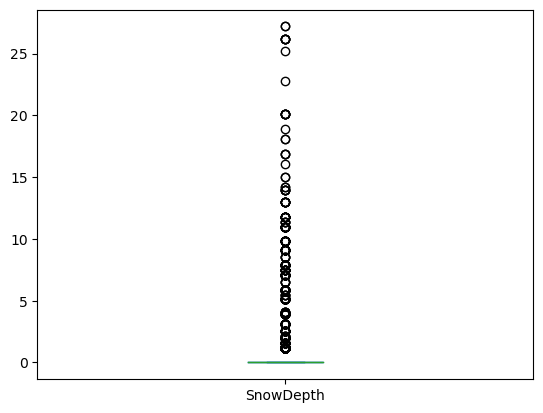

In [110]:
df_weather['SnowDepth'].plot(kind = 'box')

In [111]:
df_weather['SnowDepth'].describe()

count    21778.000000
mean         0.174238
std          1.246196
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         27.200000
Name: SnowDepth, dtype: float64

Correcting records based on flag by reversing the points:

When Snow Ice = 0 and Snow Depth > 0, Snow Ice is flipped to 1 <br>
When Snow Ice = 1 and Snow Depth = 0, Snow Ice is flipped to 0

In [112]:
df_weather.loc[df_weather['SnowDepth'] > 0, 'SnowIce'] = 1
df_weather.loc[df_weather['SnowDepth'] == 0, 'SnowIce'] = 0

The data looks much cleaner now

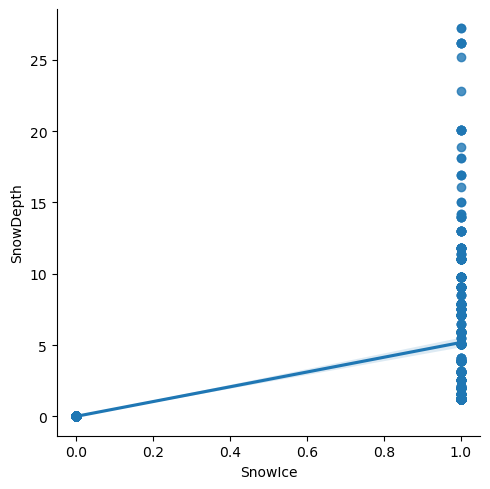

In [113]:
sns.lmplot(data = df_weather, x = 'SnowIce', y = 'SnowDepth')

In [114]:
X = df_weather.loc[:, ['Month', 'MeanTemp', 'SnowIce', 'Percipitation', 'SnowDepth']]
X.isnull().sum()

Month              0
MeanTemp           0
SnowIce            0
Percipitation      0
SnowDepth        659
dtype: int64

Imputing the remaining records with a KNN Imputer

In [115]:
imputer = KNNImputer(n_neighbors=5)
X = df_weather.loc[:, ['Month', 'MeanTemp', 'SnowIce', 'Percipitation', 'SnowDepth']]
df_weather.loc[:, ['Month', 'MeanTemp', 'SnowIce', 'Percipitation', 'SnowDepth']] = imputer.fit_transform(X)

We perform an A/B Test using the daily calls data and weather data to check for causation. More on it later.

In [116]:
df_weather.to_csv('weather_data_cleaned.csv', index = False)

In [117]:
df_311_daily_calls = df_311.groupby(['Y-M-d', 'Borough']).agg(Count = ('City', 'count')).reset_index()
df_calls_daily_weather = pd.merge(df_311_daily_calls, df_weather.loc[:, ['Date', 'MeanTemp']], how = 'left', left_on = 'Y-M-d', right_on = 'Date')
df_calls_daily_weather.to_csv('daily_calls_with_weather.csv', index = False)

Checking the distribution for all the weather columns on a daily level

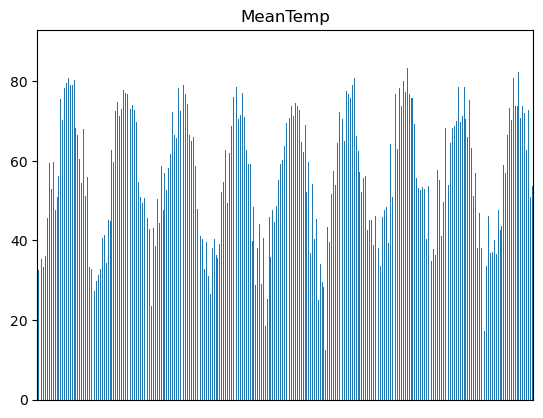

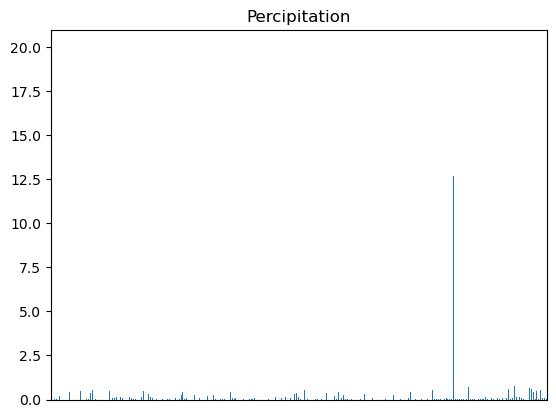

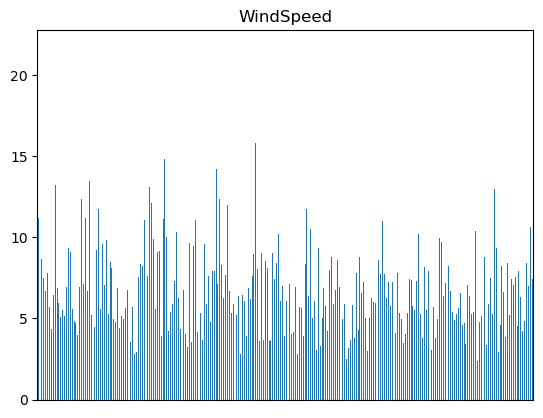

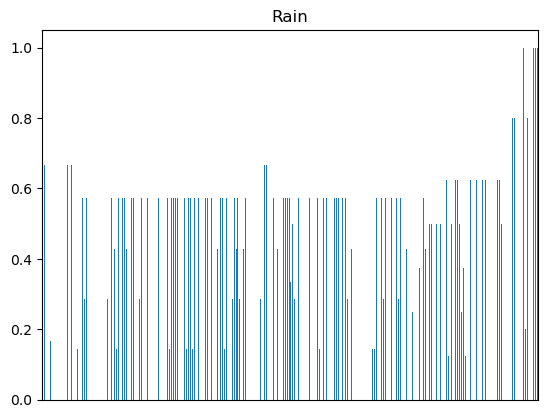

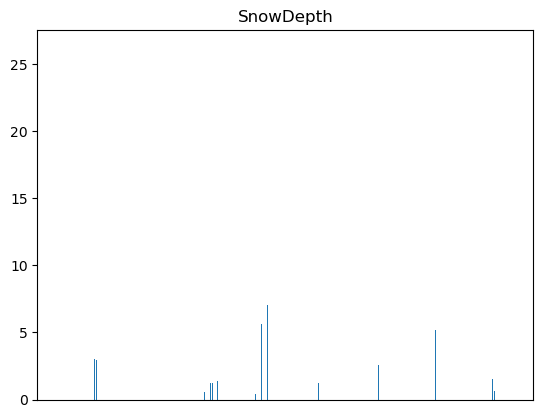

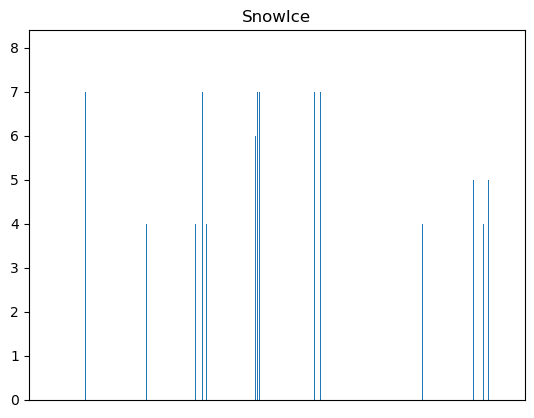

In [118]:
weather_cols = ['MeanTemp', 'Percipitation', 'WindSpeed', 'Rain', 'SnowDepth', 'SnowIce']
for i in weather_cols:
    if i == 'SnowIce':
        df_weather_temp = df_weather.groupby(['Date']).agg({i: 'sum'}).reset_index()
    else:
        df_weather_temp = df_weather.groupby(['Date']).agg({i: 'mean'}).reset_index()

    df_weather_temp.sort_values(['Date'], inplace = True)
    df_weather_temp[i].plot(kind = 'bar')
    plt.xticks(np.arange(len(df_weather_temp), 12.0))
    plt.title(i)
    plt.show()

Most columns, except for Temperature and Wind do not show any seasonality or trend

In [119]:
agg_cols = {
    'MeanTemp' : ['median', 'std'],
    'Percipitation' : ['median', 'std'],
    'WindSpeed' : ['median', 'std'],
    'Rain' : ['median', 'std'],
    'SnowDepth' : ['median', 'std'],
    'SnowIce' : ['sum']
}

df_weather = df_weather.groupby(['Date']).agg(agg_cols)
df_weather.columns = ["_".join(i) for i in df_weather.columns]
df_weather = df_weather.reset_index()

Aggregating the weather information on a daily level and by using Median and Standard deviation as key features

## Merging datasets (Daily Level)

In [120]:
final = pd.merge(df_calls_daily, df_weather, left_on = 'Y-M-d', right_on = 'Date', how = 'left')
final

Count      Y-M-d       Date  MeanTemp_median  MeanTemp_std  \
0      2780 2016-01-01 2016-01-01            41.25      0.758068   
1      3060 2016-01-02 2016-01-02            36.70      0.700476   
2      3095 2016-01-03 2016-01-03            38.85      1.294218   
3      5963 2016-01-04 2016-01-04            32.20      1.141490   
4      8111 2016-01-05 2016-01-05            19.00      0.430891   
...     ...        ...        ...              ...           ...   
1091   4733 2018-12-27        NaT              NaN           NaN   
1092   4294 2018-12-28        NaT              NaN           NaN   
1093   3492 2018-12-29        NaT              NaN           NaN   
1094   3500 2018-12-30        NaT              NaN           NaN   
1095   4029 2018-12-31        NaT              NaN           NaN   

      Percipitation_median  Percipitation_std  WindSpeed_median  \
0                     0.03           0.029269              6.95   
1                     0.00           0.000000              7.35   
2                     0.00           0.000000              6.95   
3                     0.00           0.000000              8.65   
4                     0.00           0.000000              8.85   
...                    ...                ...               ...   
1091                   NaN                NaN               NaN   
1092                   NaN                NaN               NaN   
1093                   NaN                NaN               NaN   
1094                   NaN                NaN               NaN   
1095                   NaN                NaN               NaN   

      WindSpeed_std  Rain_median  Rain_std  SnowDepth_median  SnowDepth_std  \
0          5.291755          0.0       0.0               0.0            0.0   
1          5.628736          0.0       0.0               0.0            0.0   
2          5.036434          0.0       0.0               0.0            0.0   
3          6.466838          0.0       0.0               0.0            0.0   
4          6.807178          0.0       0.0               0.0            0.0   
...             ...          ...       ...               ...            ...   
1091            NaN          NaN       NaN               NaN            NaN   
1092            NaN          NaN       NaN               NaN            NaN   
1093            NaN          NaN       NaN               NaN            NaN   
1094            NaN          NaN       NaN               NaN            NaN   
1095            NaN          NaN       NaN               NaN            NaN   

      SnowIce_sum  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
1091          NaN  
1092          NaN  
1093          NaN  
1094          NaN  
1095          NaN  

[1096 rows x 14 columns]

Checking for null values after merging the 2 datasets

In [121]:
null_dates = final[final['MeanTemp_median'].isnull()]['Y-M-d'].unique()
print(len(null_dates))

49


We can see that we do not have weather information for the last 7 weeks. But we have weather information from 2010.

Based on that we perform a time series analysis to predict the temperature for the 7 missing weeks. <br>

Before we do so, we perform the Augmented Dickey Fuller test to check for stationarity and unit roots in the data. <br>
We check and note the p-values for the same before and after first order differening

MeanTemp_median
ADF Statistic on the entire dataset: -3.2296084874213506
p-value: 0.018333532418986283
Critical Values:
	1%: -3.4323805665026175
	5%: -2.8624371819849372
	10%: -2.5672475896829807
ADF Statistic on the entire dataset: -21.742914289677728
p-value: 0.0
Critical Values:
	1%: -3.4323805665026175
	5%: -2.8624371819849372
	10%: -2.5672475896829807


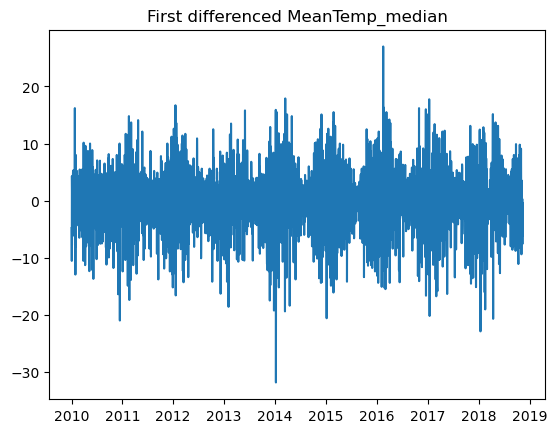

Percipitation_median
ADF Statistic on the entire dataset: -13.553994679874807
p-value: 2.3793592925794895e-25
Critical Values:
	1%: -3.4323805665026175
	5%: -2.8624371819849372
	10%: -2.5672475896829807
ADF Statistic on the entire dataset: -17.828401643886806
p-value: 3.1405138552140396e-30
Critical Values:
	1%: -3.4323907053004503
	5%: -2.8624416601590545
	10%: -2.567249973775016


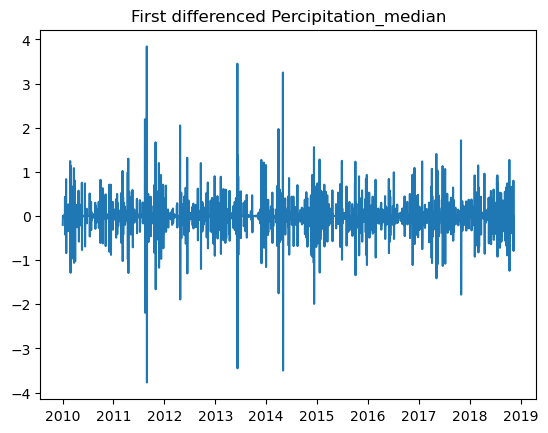

WindSpeed_median
ADF Statistic on the entire dataset: -6.43001856746155
p-value: 1.706557121445084e-08
Critical Values:
	1%: -3.432388161120837
	5%: -2.862440536429695
	10%: -2.5672493755233123
ADF Statistic on the entire dataset: -19.23308983355487
p-value: 0.0
Critical Values:
	1%: -3.432388161120837
	5%: -2.862440536429695
	10%: -2.5672493755233123


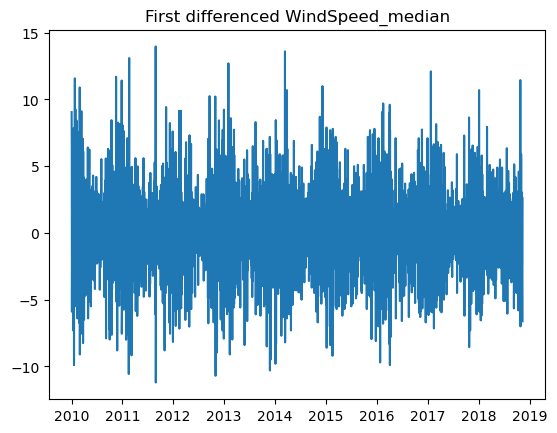

Rain_median
ADF Statistic on the entire dataset: -38.55458320545401
p-value: 0.0
Critical Values:
	1%: -3.4323724026124003
	5%: -2.8624335760905684
	10%: -2.5672456699774324
ADF Statistic on the entire dataset: -18.95148951748799
p-value: 0.0
Critical Values:
	1%: -3.4323894324171813
	5%: -2.8624410979440333
	10%: -2.567249674462629


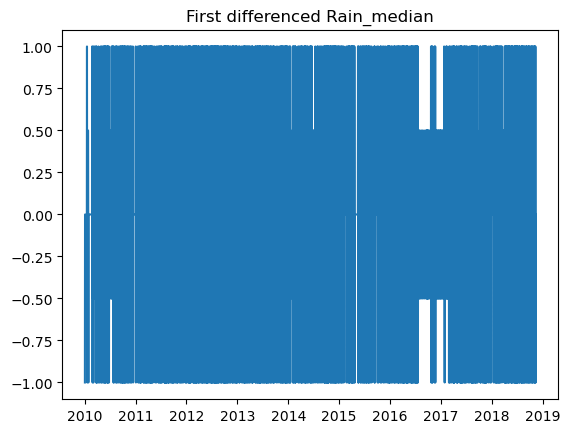

SnowDepth_median
ADF Statistic on the entire dataset: -7.778417616759189
p-value: 8.545393121316517e-12
Critical Values:
	1%: -3.432388161120837
	5%: -2.862440536429695
	10%: -2.5672493755233123
ADF Statistic on the entire dataset: -15.601715771776343
p-value: 1.82571403430851e-28
Critical Values:
	1%: -3.4323907053004503
	5%: -2.8624416601590545
	10%: -2.567249973775016


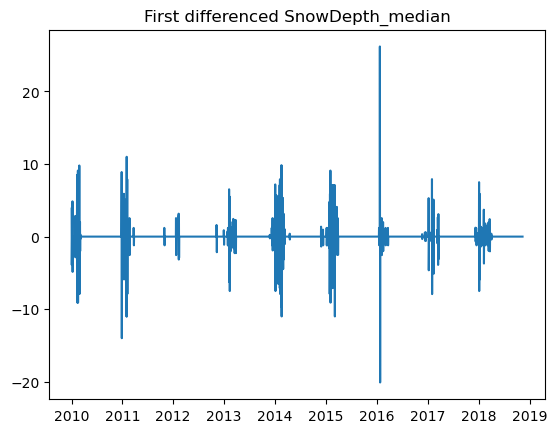

SnowIce_sum
ADF Statistic on the entire dataset: -6.115763544788138
p-value: 9.103028333149834e-08
Critical Values:
	1%: -3.4323875260668344
	5%: -2.862440255934873
	10%: -2.5672492261933377
ADF Statistic on the entire dataset: -18.435495191458042
p-value: 2.1651999885234883e-30
Critical Values:
	1%: -3.4323875260668344
	5%: -2.862440255934873
	10%: -2.5672492261933377


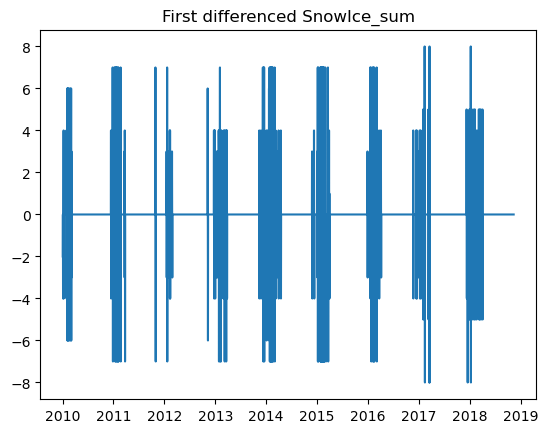

In [122]:
cols = ['MeanTemp_median', 'Percipitation_median', 'WindSpeed_median', 'Rain_median', 'SnowDepth_median', 'SnowIce_sum']

train_portion = df_weather[~df_weather['Date'].isin(null_dates)]
train_portion.set_index('Date', inplace = True)

for i in cols:
    
    first_diff = train_portion[i].diff()[1:]

    print(i)
    result = adfuller(train_portion[i])
    print('ADF Statistic on the entire dataset: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


    result_diff = adfuller(first_diff)
    print('ADF Statistic on the entire dataset: {}'.format(result_diff[0]))
    print('p-value: {}'.format(result_diff[1]))
    print('Critical Values:')
    for key, value in result_diff[4].items():
        print('\t{}: {}'.format(key, value))


    if result_diff[1] > result[1]:
        plt.plot(train_portion[i])
        plt.title(i)
        plt.show()
    else:
        plt.plot(first_diff)
        plt.title(f'First differenced {i}')
        plt.show()
        


Since differencing gives a better p-value, we use differencing for all the columns and check their ACF and PACF plots to interpret values for MA and AR respectively.

/Users/pranavkarnani/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



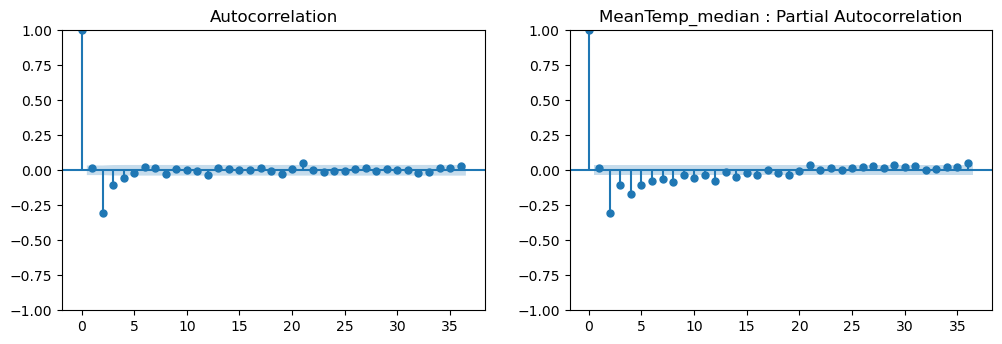

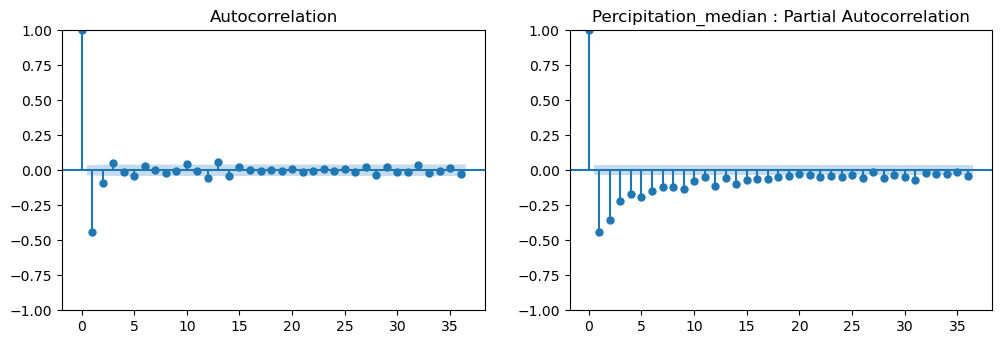

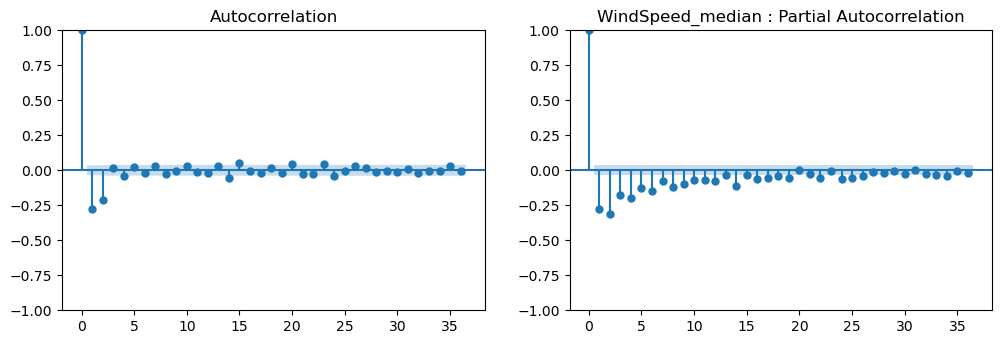

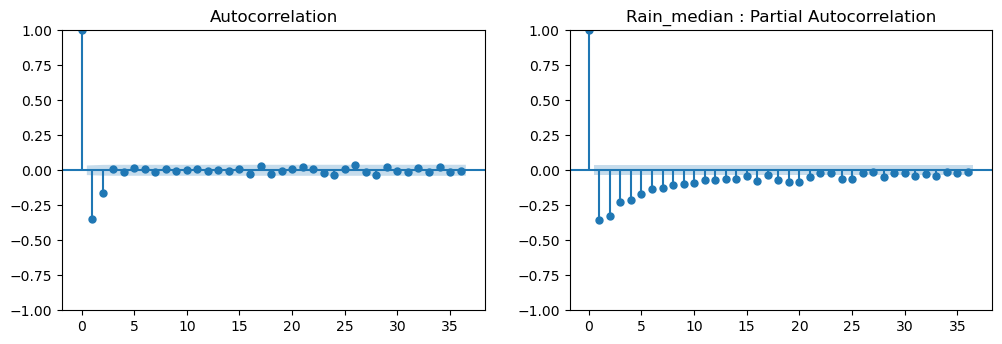

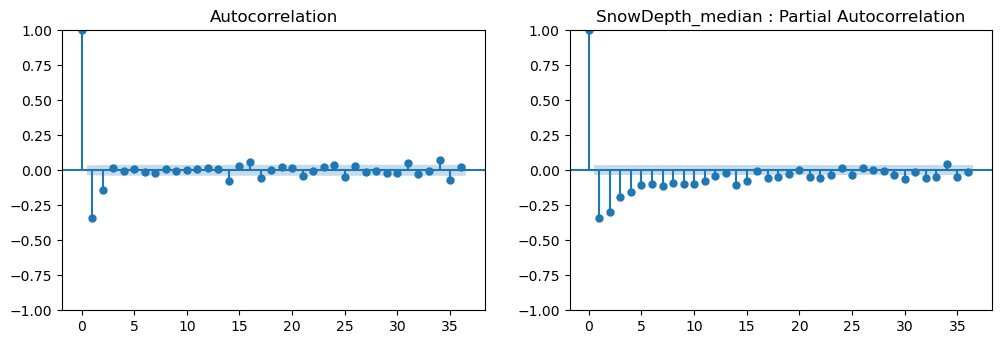

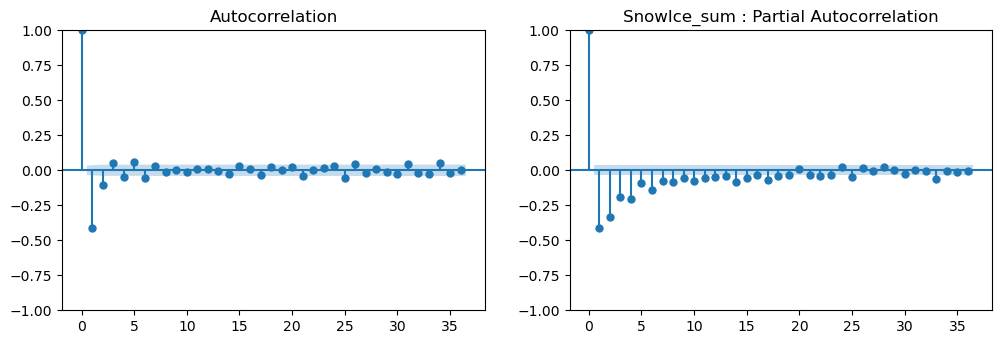

In [123]:
differencing = ['MeanTemp_median', 'Percipitation_median', 'WindSpeed_median', 'Rain_median', 'SnowDepth_median' ,'SnowIce_sum']

for i in cols:

    if i in differencing:
        first_diff = train_portion[i].diff()[1:]
    else:
        first_diff = train_portion[i]

    fig = plt.figure(figsize=(12,8))
    ax1 = plt.subplot(2, 2, 1)
    ax1.set_title(f'{i} : Autocorrelation')
    fig = sm.graphics.tsa.plot_acf(first_diff, ax=ax1)
    ax2 = plt.subplot(2, 2, 2)
    fig = sm.graphics.tsa.plot_pacf(first_diff, ax=ax2)
    ax2.set_title(f'{i} : Partial Autocorrelation')

In [124]:
order = {
    'MeanTemp_median': (7,1,3),
    'Percipitation_median': (10,1,2),
    'WindSpeed_median': (8,1,2),
    'Rain_median': (10,1,2),
    'SnowDepth_median': (10,1,2),
    'SnowIce_sum': (6,1,2)
}

Checking the VIF scores for each column

In [125]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = cols
  
vif_train_portion = train_portion.loc[:, cols]

vif_data["VIF"] = [variance_inflation_factor(vif_train_portion.values, i)
                          for i in range(len(cols))]
  
print(vif_data)

                feature       VIF
0       MeanTemp_median  3.966231
1  Percipitation_median  1.302943
2      WindSpeed_median  4.231979
3           Rain_median  1.593564
4      SnowDepth_median  2.231460
5           SnowIce_sum  2.350782


Checking the VIF scores after we remove all columns other than Temperature and WindSpeed

In [126]:
vif_data = pd.DataFrame()
subset_cols = ['MeanTemp_median', 'WindSpeed_median']
vif_data["feature"] = subset_cols
vif_train_portion = vif_train_portion.loc[:, subset_cols]

vif_data["VIF"] = [variance_inflation_factor(vif_train_portion.values, i)
                          for i in range(len(subset_cols))]

print(vif_data)                          

            feature      VIF
0   MeanTemp_median  3.65209
1  WindSpeed_median  3.65209


In [127]:
import warnings
warnings.simplefilter("ignore")

Due to high multicollinearity, we will be using temperature and wind speed as our weather features, but we still go ahead and check the fit for each weather based feature

=======================================MeanTemp_median=======================================
Average RMSE: 123.93045140478492
Average MAPE: 0.15250268601371353
Average Absolute error: 0.15250268601371353

=======================================Percipitation_median=======================================
Average RMSE: 0.056122374132140176
Average MAPE: 1.9296107720796059
Average Absolute error: 1.9296107720796059

=======================================WindSpeed_median=======================================
Average RMSE: 6.157106648745159
Average MAPE: 0.2646169363271128
Average Absolute error: 0.2646169363271128

=======================================Rain_median=======================================
Average RMSE: 0.24995337191530947
Average MAPE: 1.4664615533857004
Average Absolute error: 1.4664615533857004

=======================================SnowDepth_median=======================================
Average RMSE: 0.06189014128056384
Average MAPE: 1.1228784860526924
Average Absolute

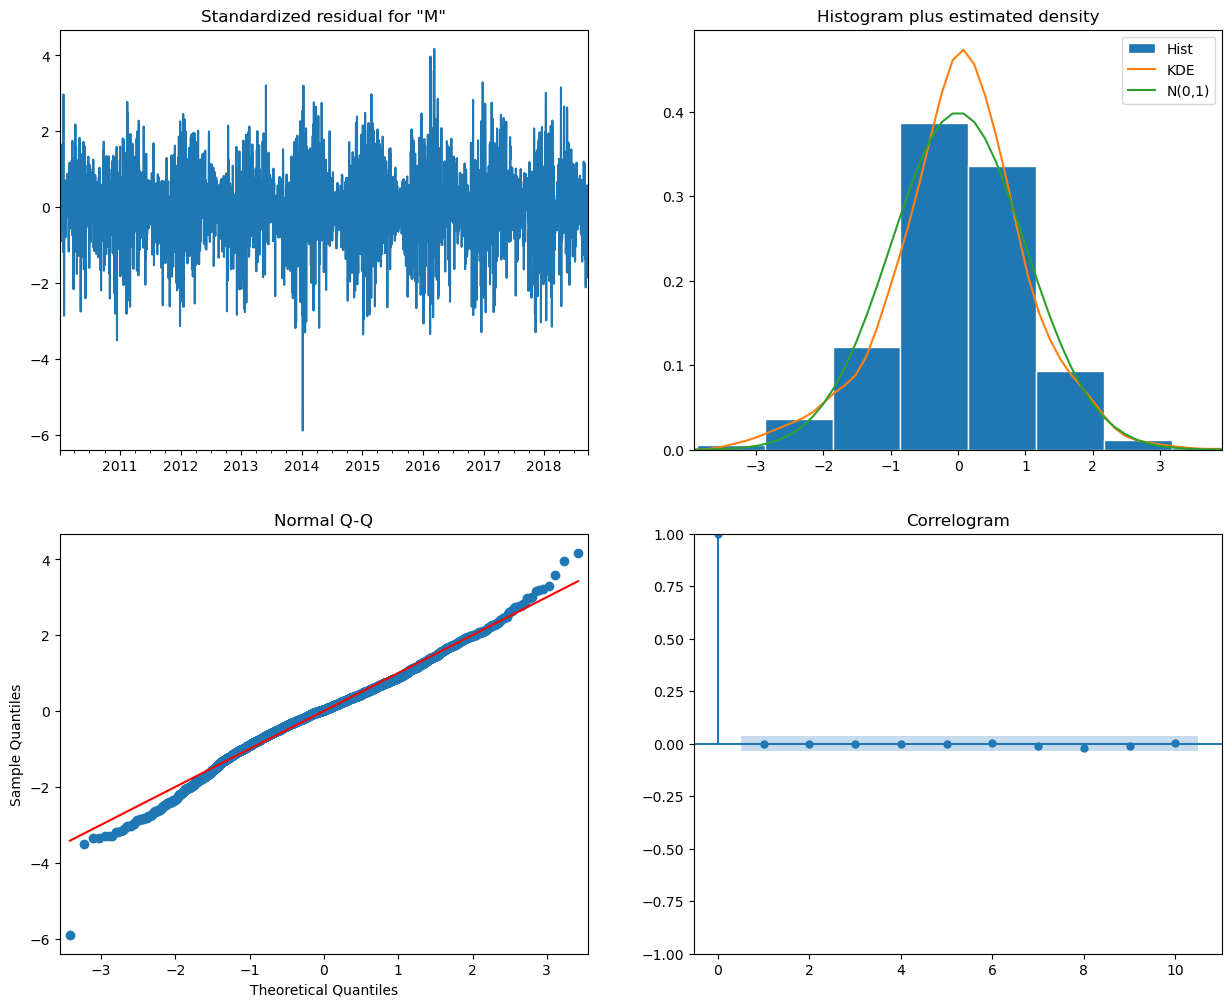

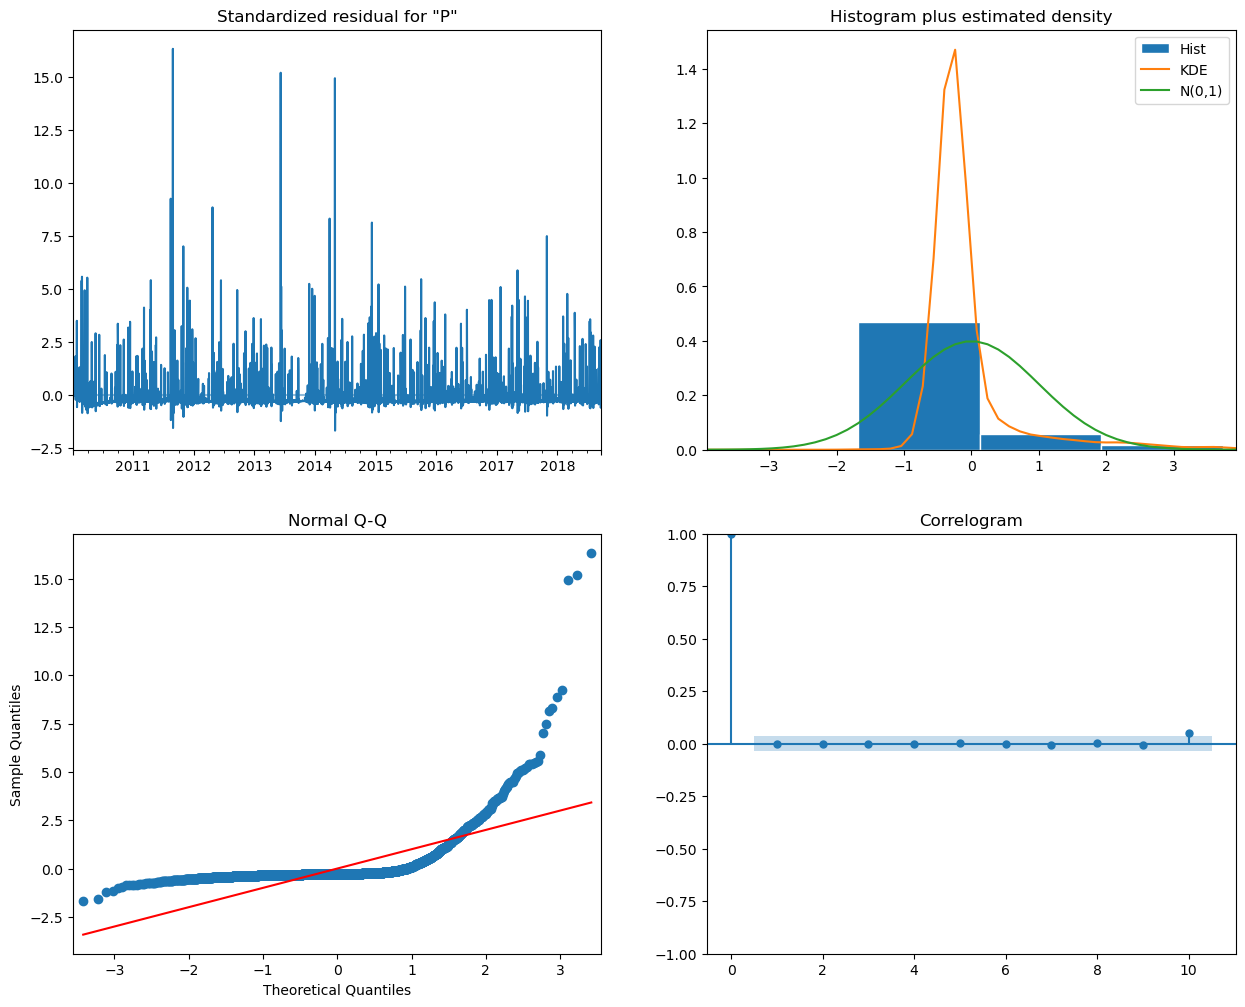

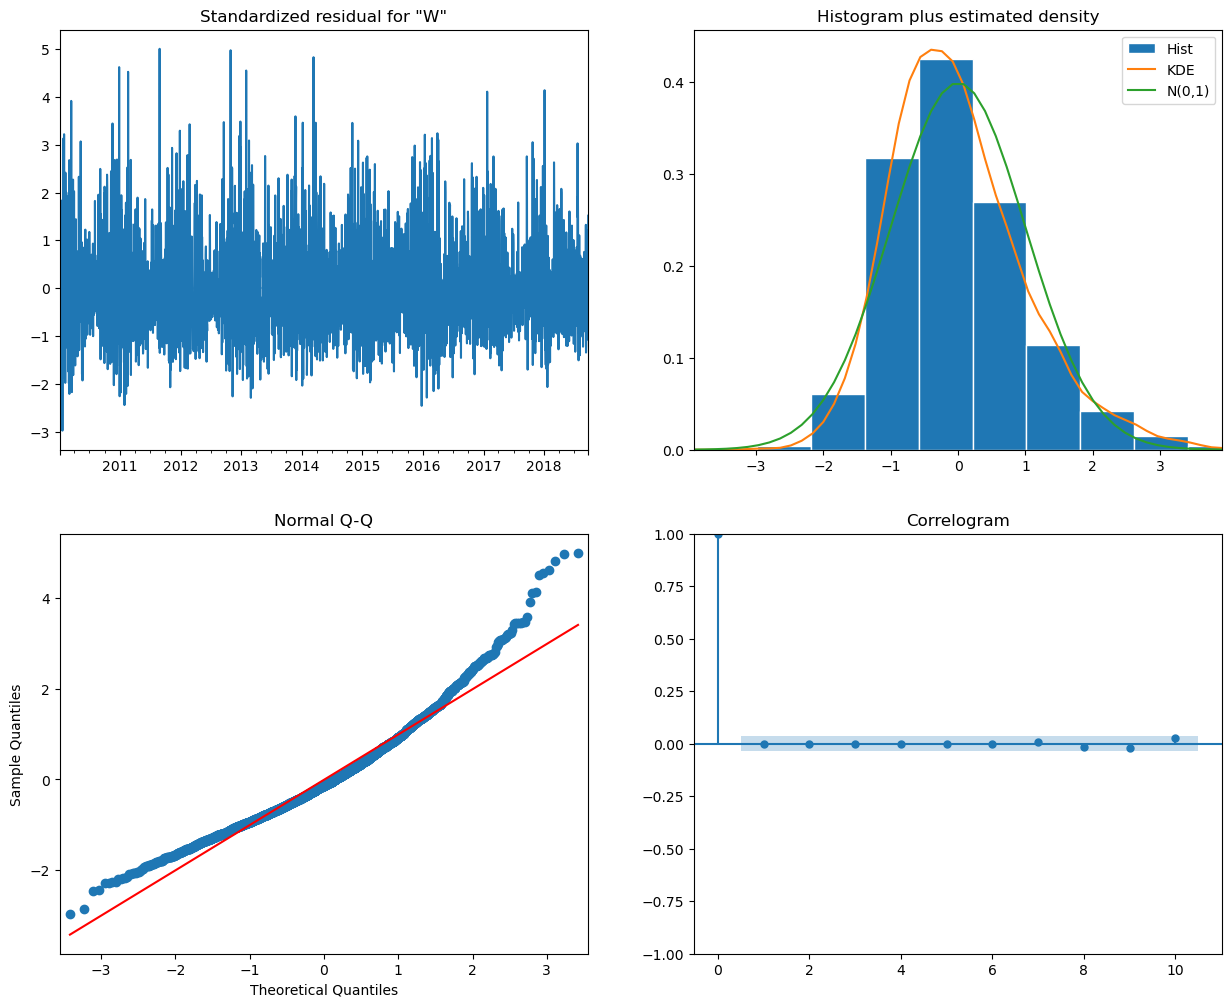

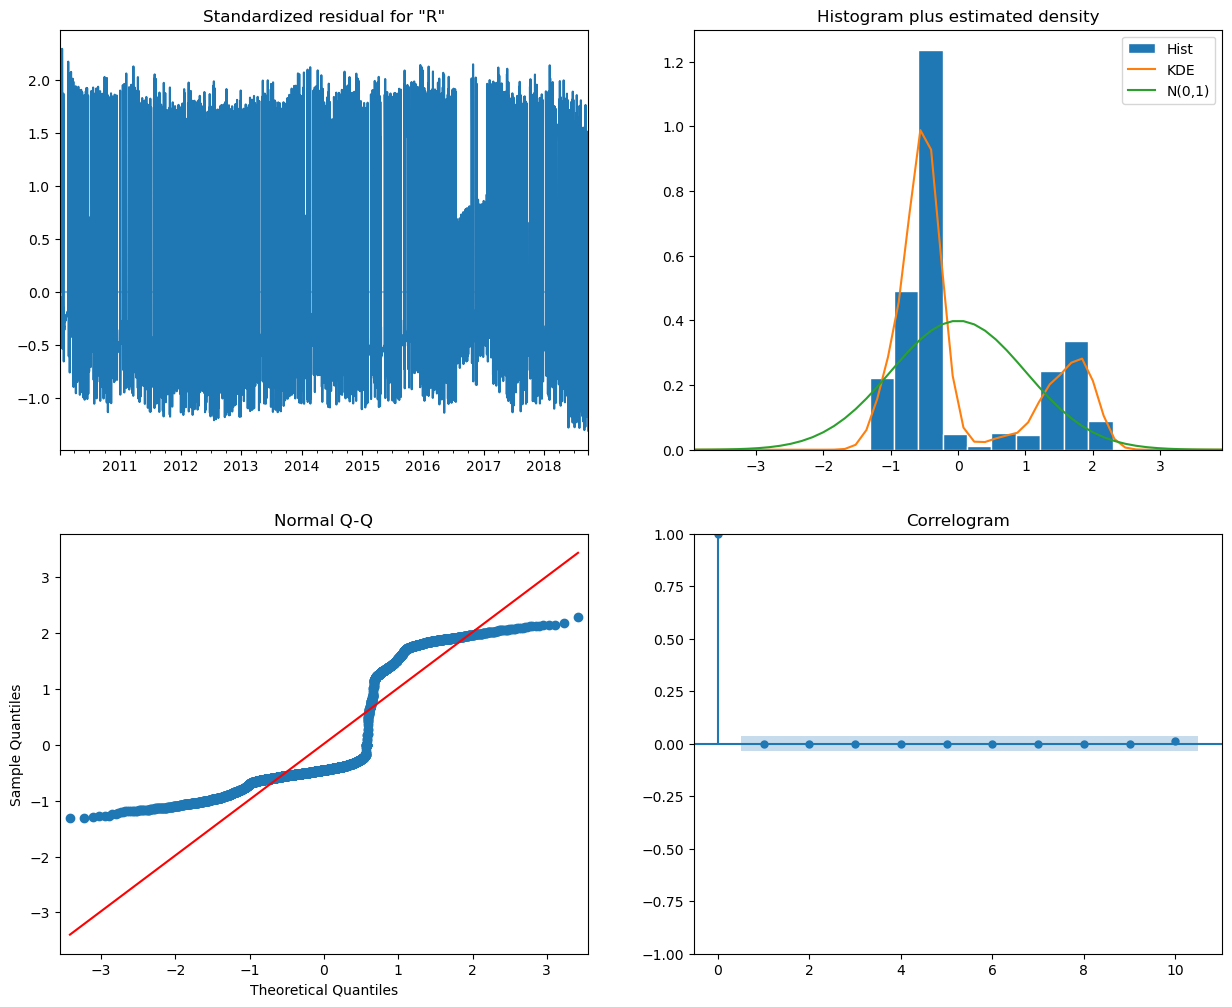

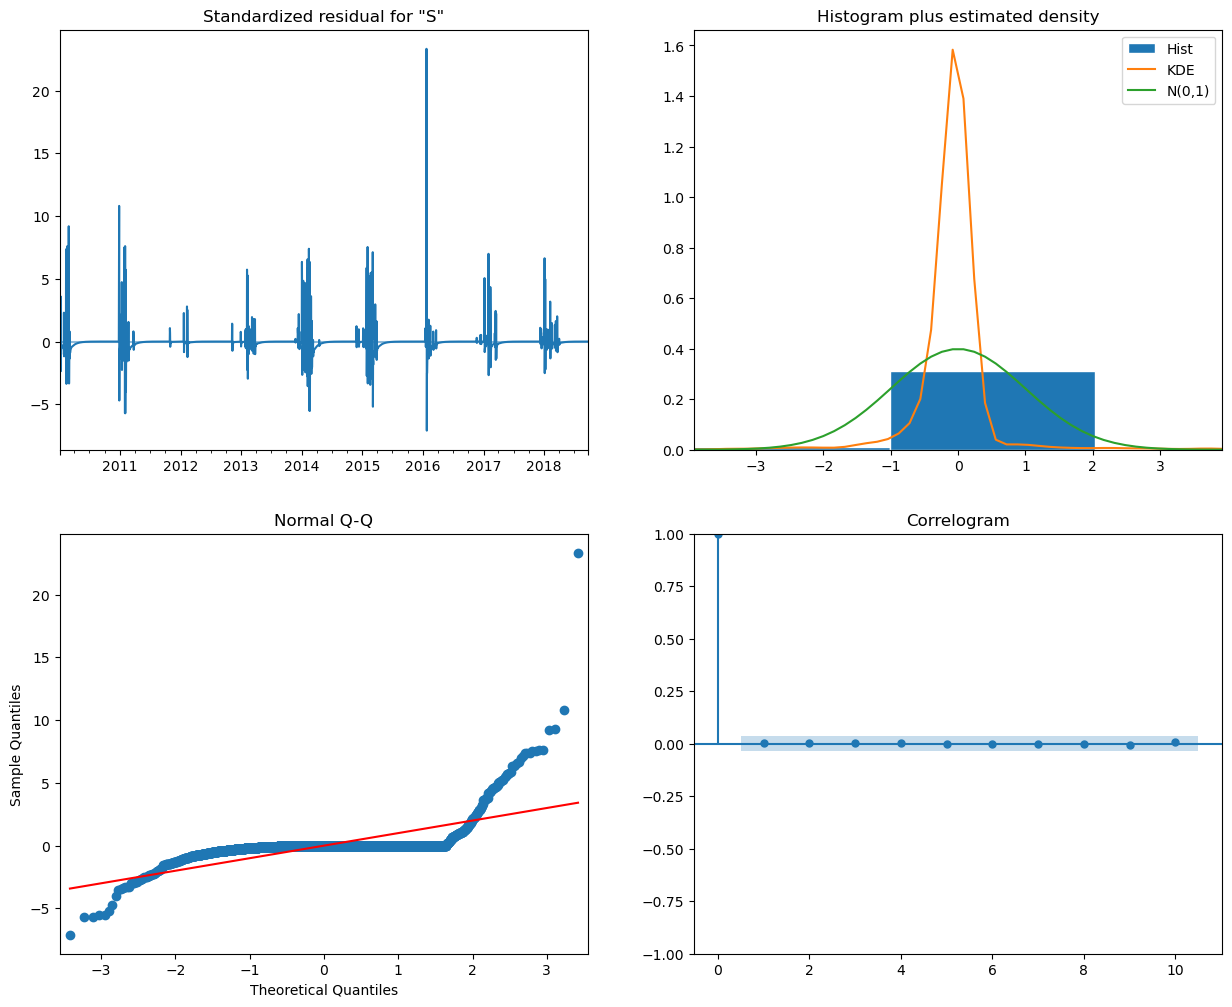

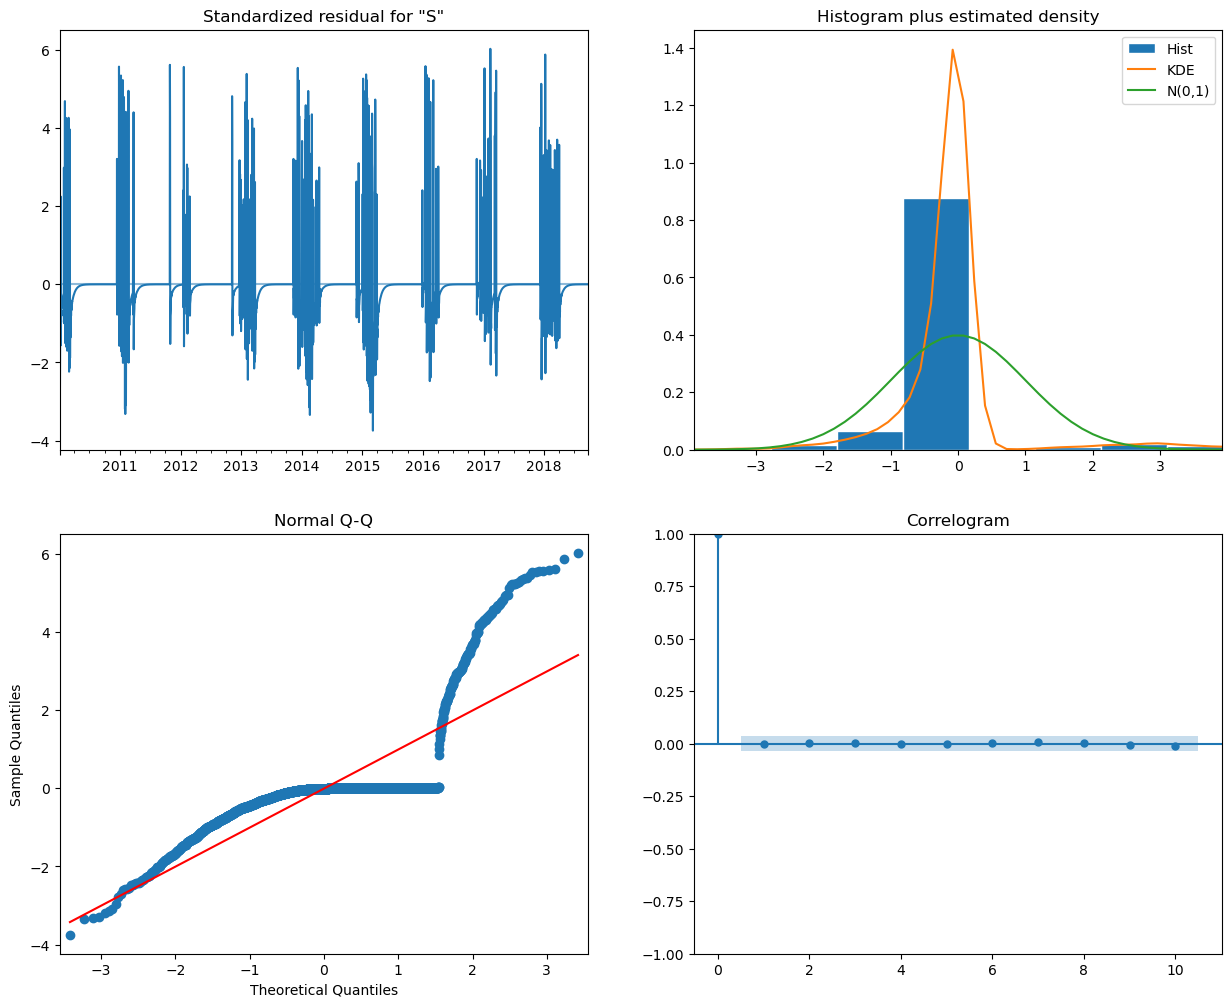

In [128]:
num_folds = 5

for i in cols:
    print(f"======================================={i}=======================================")
    rmse = []
    mape = []
    absolute_errors = []
    for j in range(num_folds):
        train_data = train_portion[i][1:-(49 * (num_folds-j))]
        val_data = train_portion[i][(-49 * (num_folds-j))-1: -49 * (num_folds-j-1)-1]

        model = ARIMA(train_data, order = order[i])
        model_fit = model.fit(method_kwargs={"warn_convergence": False})
        
        predictions = model_fit.get_forecast(49)

        prediction = predictions.predicted_mean
        prediction_range = predictions.conf_int(alpha=0.05)
        deviation = (prediction - prediction_range.iloc[:,-1])/2

        rmse.append(mean_squared_error(prediction.values, list(val_data)))
        mape.append(mean_absolute_percentage_error(prediction.values, list(val_data)))
        absolute_errors.append(mean_absolute_percentage_error(prediction.values, list(val_data)))
        
    rmse = np.array(rmse)
    mape = np.array(mape)
    absolute_errors = np.array(absolute_errors)

    # plt.plot(range(len(val_data)), val_data.values)
    # plt.plot(range(len(val_data)), prediction.values)
    # plt.show()
    model_fit.plot_diagnostics(figsize=(15, 12))

    print(f'Average RMSE: {np.mean(rmse)}')
    print(f'Average MAPE: {np.mean(mape)}')
    print(f'Average Absolute error: {np.mean(absolute_errors)}')

    with open(f'{i}-predictions.txt', 'w+') as f:
        f.write(str(model_fit.summary()))

    print()


Text(0.5, 1.0, 'Rain_median')

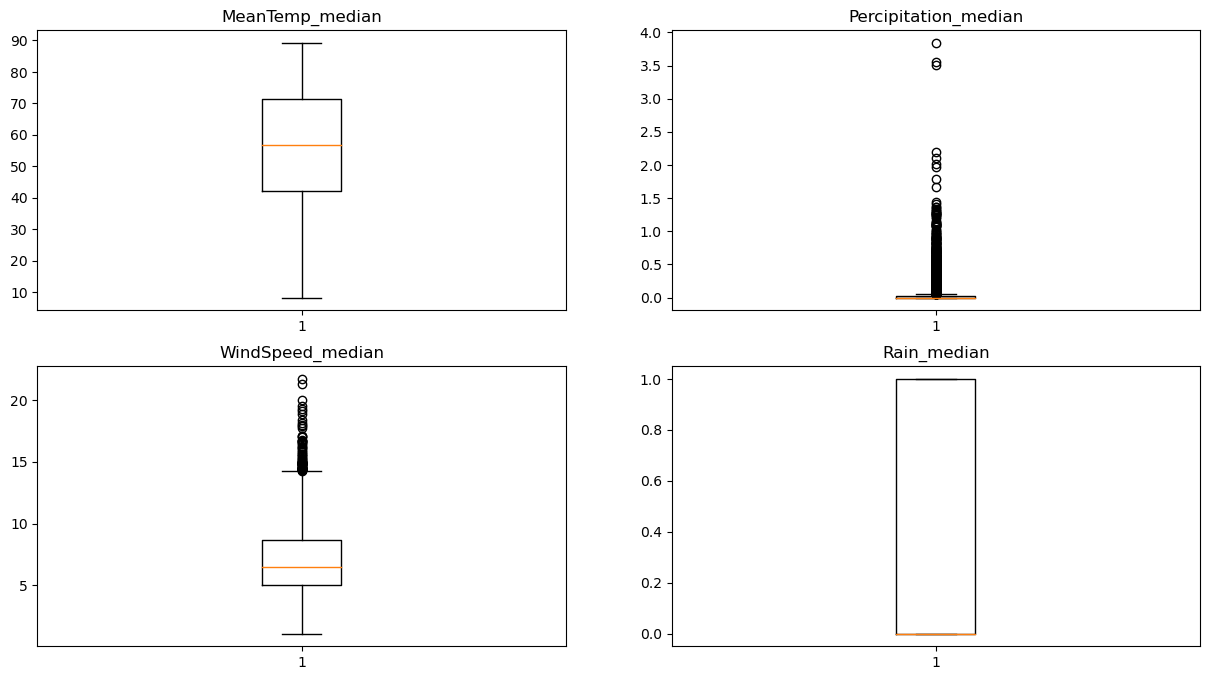

In [129]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,8))

ax1.set_title(f'{cols[0]}')
ax1.boxplot(df_weather.loc[:, cols[0]])

ax2.boxplot(df_weather.loc[:, cols[1]])
ax2.set_title(f'{cols[1]}')

ax3.set_title(f'{cols[2]}')
ax3.boxplot(df_weather.loc[:, cols[2]])

ax4.boxplot(df_weather.loc[:, cols[3]])
ax4.set_title(f'{cols[3]}')

Based on the error values, range of values for each weather based column, histogram density plots and Q-Q plots, we can say that the 2 features which we can predict with confidence are: <br>

1. Temperature
2. WindSpeed

Getting temperature and wind speed predictions by fitting the models to the entire training data

Note: We calculate the standard deviation in temperature using the estimates of the confidence interval

In [130]:
temperature_column = cols[0]

train_data = train_portion[temperature_column]

model = ARIMA(train_data, order = order[temperature_column])
model_fit = model.fit(method_kwargs={"warn_convergence": False})

predictions = model_fit.get_forecast(49)

prediction = predictions.predicted_mean
prediction_range = predictions.conf_int(alpha=0.05)
deviation = (prediction - prediction_range.iloc[:,-1])/2
deviation = abs(deviation)

In [131]:
temperature_predictions = list(train_portion[temperature_column].values[list(train_portion.index).index(pd.Timestamp('2016-01-01')):]) + list(prediction)
temperature_deviation = list(train_portion['MeanTemp_std'].values[list(train_portion.index).index(pd.Timestamp('2016-01-01')):]) + list(deviation)

In [132]:
temperature_predictions_2019 = model_fit.get_forecast(56)

prediction_2019 = temperature_predictions_2019.predicted_mean
prediction_range_2019 = temperature_predictions_2019.conf_int(alpha=0.05)
deviation_2019 = (prediction_2019 - prediction_range_2019.iloc[:,-1])/2
deviation_2019 = abs(deviation_2019)

In [133]:
engineered_dataset = pd.DataFrame()
engineered_dataset['Date'] = final['Date']
engineered_dataset['Count'] = final['Count']
engineered_dataset['Date'] = final['Y-M-d']
engineered_dataset

Date  Count
0    2016-01-01   2780
1    2016-01-02   3060
2    2016-01-03   3095
3    2016-01-04   5963
4    2016-01-05   8111
...         ...    ...
1091 2018-12-27   4733
1092 2018-12-28   4294
1093 2018-12-29   3492
1094 2018-12-30   3500
1095 2018-12-31   4029

[1096 rows x 2 columns]

In [134]:
temperature = pd.DataFrame()
temperature['Date'] = engineered_dataset['Date'].unique()
temperature['DailyMeanTemp'] = temperature_predictions
temperature['DailyTempStd'] = temperature_deviation

In [135]:
engineered_dataset = pd.merge(engineered_dataset, temperature, on = 'Date', how = 'left')
engineered_dataset

Date  Count  DailyMeanTemp  DailyTempStd
0    2016-01-01   2780      41.250000      0.758068
1    2016-01-02   3060      36.700000      0.700476
2    2016-01-03   3095      38.850000      1.294218
3    2016-01-04   5963      32.200000      1.141490
4    2016-01-05   8111      19.000000      0.430891
...         ...    ...            ...           ...
1091 2018-12-27   4733      47.500116     12.504621
1092 2018-12-28   4294      47.500168     12.604379
1093 2018-12-29   3492      47.500127     12.703358
1094 2018-12-30   3500      47.500159     12.801569
1095 2018-12-31   4029      47.500135     12.899035

[1096 rows x 4 columns]

Engineered dataset with just mean and standard deviation of temperature

In [136]:
# engineered_dataset.to_csv('engineered_dataset.csv', index = False)

In [137]:
wind_column = 'WindSpeed_median'

train_data = train_portion[wind_column]

model = ARIMA(train_data, order = order[wind_column])
model_fit = model.fit(method_kwargs={"warn_convergence": False})

predictions = model_fit.get_forecast(49)

prediction = predictions.predicted_mean
prediction_range = predictions.conf_int(alpha=0.05)
deviation = (prediction - prediction_range.iloc[:,-1])/2
deviation = abs(deviation)

In [138]:
wind_predictions = list(train_portion[wind_column].values[list(train_portion.index).index(pd.Timestamp('2016-01-01')):]) + list(prediction)
wind_deviation = list(train_portion['WindSpeed_std'].values[list(train_portion.index).index(pd.Timestamp('2016-01-01')):]) + list(deviation)

In [139]:
wind_predictions_2019 = model_fit.get_forecast(56)

wind_prediction_2019 = wind_predictions_2019.predicted_mean
wind_prediction_range_2019 = wind_predictions_2019.conf_int(alpha=0.05)
wind_deviation_2019 = (wind_prediction_2019 - wind_prediction_range_2019.iloc[:,-1])/2
wind_deviation_2019 = abs(wind_deviation_2019)

In [140]:
wind = pd.DataFrame()
wind['Date'] = engineered_dataset['Date'].unique()
wind['WindSpeedMean'] = wind_predictions
wind['WindSpeedStd'] = wind_deviation

In [141]:
engineered_dataset = pd.merge(engineered_dataset, wind, on = 'Date', how = 'left')
engineered_dataset

Date  Count  DailyMeanTemp  DailyTempStd  WindSpeedMean  \
0    2016-01-01   2780      41.250000      0.758068       6.950000   
1    2016-01-02   3060      36.700000      0.700476       7.350000   
2    2016-01-03   3095      38.850000      1.294218       6.950000   
3    2016-01-04   5963      32.200000      1.141490       8.650000   
4    2016-01-05   8111      19.000000      0.430891       8.850000   
...         ...    ...            ...           ...            ...   
1091 2018-12-27   4733      47.500116     12.504621       8.197538   
1092 2018-12-28   4294      47.500168     12.604379       8.204367   
1093 2018-12-29   3492      47.500127     12.703358       8.198090   
1094 2018-12-30   3500      47.500159     12.801569       8.203860   
1095 2018-12-31   4029      47.500135     12.899035       8.198557   

      WindSpeedStd  
0         5.291755  
1         5.628736  
2         5.036434  
3         6.466838  
4         6.807178  
...            ...  
1091      2.853350  
1092      2.855998  
1093      2.858558  
1094      2.861195  
1095      2.863756  

[1096 rows x 6 columns]

Engineered dataset with wind speed

In [142]:
engineered_dataset.to_csv('engineered_dataset_with_wind.csv', index = False)

In [143]:
future_exogenous = pd.DataFrame()
future_exogenous['WindSpeedMean'] = wind_prediction_2019
future_exogenous['WindSpeedStd'] = wind_deviation_2019
future_exogenous['DailyMeanTemp'] = prediction_2019
future_exogenous['DailyTempStd'] = deviation_2019
print(len(future_exogenous))
future_exogenous.to_csv('future_values.csv', index = False)

56


Creating another CSV which we will use to check for causality later on. We have use boroughs as well, to check account for fixed effects and time dummies.

In [144]:
df_311 = df_311.groupby(['Y-M-d', 'Borough']).agg(Count = ('City', 'count'))
df_311 = df_311.reset_index()
df_311_borough_weather = pd.merge(df_311, temperature, left_on = 'Y-M-d', right_on = 'Date', how = 'left')
df_311_borough_weather

Y-M-d        Borough  Count       Date  DailyMeanTemp  DailyTempStd
0    2016-01-01          BRONX    689 2016-01-01      41.250000      0.758068
1    2016-01-01       BROOKLYN    858 2016-01-01      41.250000      0.758068
2    2016-01-01      MANHATTAN    558 2016-01-01      41.250000      0.758068
3    2016-01-01         QUEENS    606 2016-01-01      41.250000      0.758068
4    2016-01-01  STATEN ISLAND     69 2016-01-01      41.250000      0.758068
...         ...            ...    ...        ...            ...           ...
6571 2018-12-31       BROOKLYN   1382 2018-12-31      47.500135     12.899035
6572 2018-12-31      MANHATTAN    652 2018-12-31      47.500135     12.899035
6573 2018-12-31         QUEENS    939 2018-12-31      47.500135     12.899035
6574 2018-12-31  STATEN ISLAND    213 2018-12-31      47.500135     12.899035
6575 2018-12-31    Unspecified     14 2018-12-31      47.500135     12.899035

[6576 rows x 6 columns]

In [145]:
df_311_borough_weather.to_csv('311_borough_weather.csv', index = False)

## Merging Dataset (Weekly Level)

Reading data from the checkpoints from before

Instead of aggregating the data on a daily level, we aggregrate the same on a weekly basis

In [146]:
df_weather = pd.read_csv('weather_data_cleaned.csv')
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather['YearWeek'] = df_weather['Date'].apply(lambda x: x.strftime('%Y%U'))

In [147]:
df_calls_daily = pd.read_csv('daily_calls_with_weather.csv')
del df_calls_daily['Date']
del df_calls_daily['MeanTemp']

df_calls_daily['Y-M-d'] = pd.to_datetime(df_calls_daily['Y-M-d'])
df_calls_daily['YearWeek'] = df_calls_daily['Y-M-d'].apply(lambda x: x.strftime('%Y%U'))

In [148]:
df_calls_daily = df_calls_daily.groupby('Y-M-d').agg({'Count': 'sum', 'YearWeek': 'unique'}) 

In [149]:
df_calls_daily = df_calls_daily.reset_index()
df_calls_daily['YearWeek'] = df_calls_daily['YearWeek'].apply(lambda x: x[0])

We now plot the distribution of the weather features on a weekly aggregated format

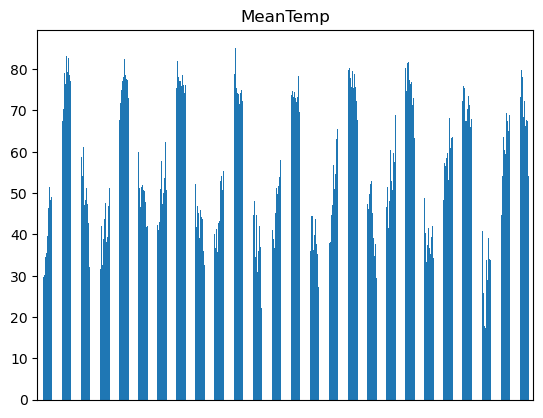

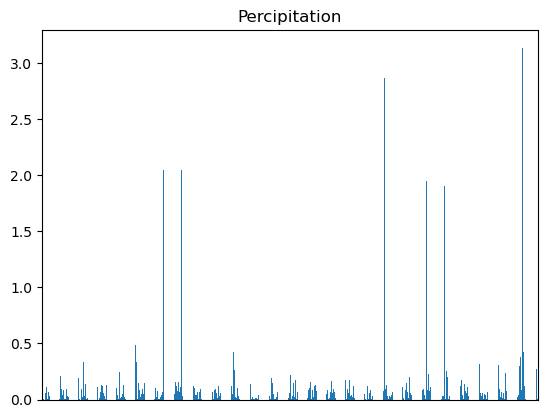

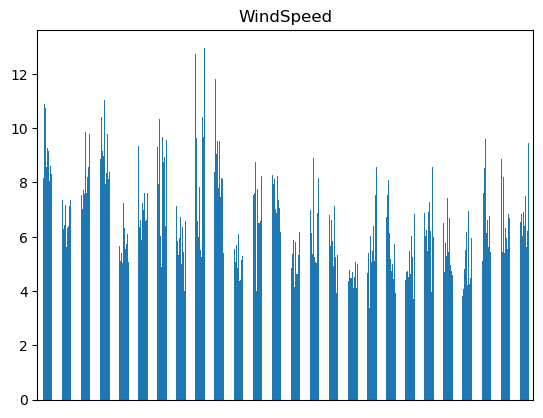

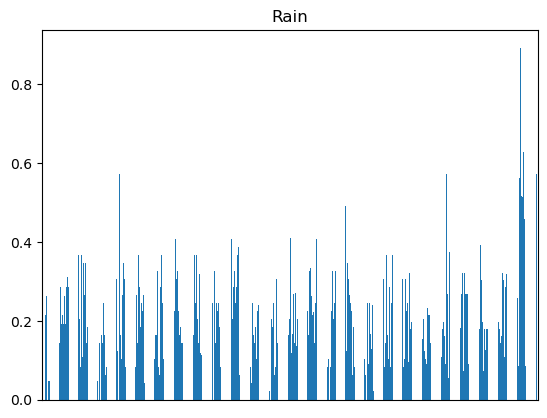

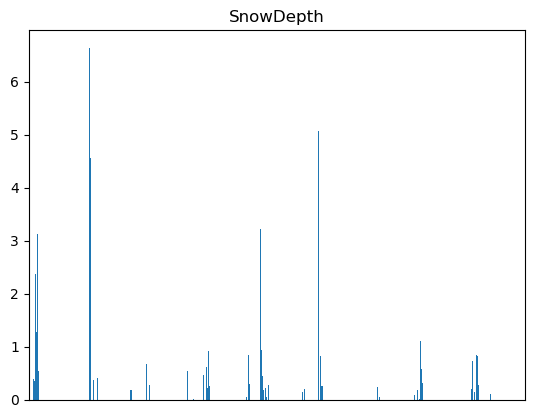

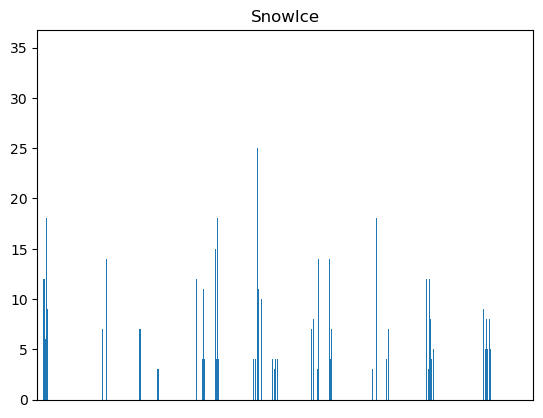

In [150]:
weather_cols = ['MeanTemp', 'Percipitation', 'WindSpeed', 'Rain', 'SnowDepth', 'SnowIce']
for i in weather_cols:
    if i == 'SnowIce':
        df_weather_temp = df_weather.groupby(['YearWeek']).agg({i: 'sum'}).reset_index()
    else:
        df_weather_temp = df_weather.groupby(['YearWeek']).agg({i: 'mean'}).reset_index()

    df_weather_temp.sort_values(['YearWeek'], inplace = True)
    df_weather_temp[i].plot(kind = 'bar')
    plt.xticks(np.arange(len(df_weather_temp), 12.0))
    plt.title(i)
    plt.show()

In [151]:
agg_cols = {
    'MeanTemp' : ['median', 'std'],
    'Percipitation' : ['median', 'std'],
    'WindSpeed' : ['median', 'std'],
    'Rain' : ['median', 'std'],
    'SnowDepth' : ['median', 'std'],
    'SnowIce' : ['sum']
}

df_weather = df_weather.groupby(['YearWeek']).agg(agg_cols)
df_weather.columns = ["_".join(i) for i in df_weather.columns]
df_weather = df_weather.reset_index()

In [152]:
final = pd.merge(df_calls_daily, df_weather, on = 'YearWeek', how = 'left')
final

Y-M-d  Count YearWeek  MeanTemp_median  MeanTemp_std  \
0    2016-01-01  16680   201600             39.0      2.501030   
1    2016-01-02  18360   201600             39.0      2.501030   
2    2016-01-03  18570   201601             36.8      7.771757   
3    2016-01-04  35778   201601             36.8      7.771757   
4    2016-01-05  48666   201601             36.8      7.771757   
...         ...    ...      ...              ...           ...   
1091 2018-12-27   4733   201851              NaN           NaN   
1092 2018-12-28   4294   201851              NaN           NaN   
1093 2018-12-29   3492   201851              NaN           NaN   
1094 2018-12-30   3500   201852              NaN           NaN   
1095 2018-12-31   4029   201852              NaN           NaN   

      Percipitation_median  Percipitation_std  WindSpeed_median  \
0                      0.0           0.025746              6.95   
1                      0.0           0.025746              6.95   
2                      0.0           0.000000              4.75   
3                      0.0           0.000000              4.75   
4                      0.0           0.000000              4.75   
...                    ...                ...               ...   
1091                   NaN                NaN               NaN   
1092                   NaN                NaN               NaN   
1093                   NaN                NaN               NaN   
1094                   NaN                NaN               NaN   
1095                   NaN                NaN               NaN   

      WindSpeed_std  Rain_median  Rain_std  SnowDepth_median  SnowDepth_std  \
0          5.211526          0.0  0.000000               0.0            0.0   
1          5.211526          0.0  0.000000               0.0            0.0   
2          4.719816          0.0  0.210707               0.0            0.0   
3          4.719816          0.0  0.210707               0.0            0.0   
4          4.719816          0.0  0.210707               0.0            0.0   
...             ...          ...       ...               ...            ...   
1091            NaN          NaN       NaN               NaN            NaN   
1092            NaN          NaN       NaN               NaN            NaN   
1093            NaN          NaN       NaN               NaN            NaN   
1094            NaN          NaN       NaN               NaN            NaN   
1095            NaN          NaN       NaN               NaN            NaN   

      SnowIce_sum  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
...           ...  
1091          NaN  
1092          NaN  
1093          NaN  
1094          NaN  
1095          NaN  

[1096 rows x 14 columns]

Finding weeks for which we do not have the weather information

In [153]:
null_dates = final[final['MeanTemp_median'].isnull()]['YearWeek'].unique()
print(null_dates)

['201846' '201847' '201848' '201849' '201850' '201851' '201852']


Perform the same ADF test again and decide whether or not to perform first differencing based on the p-values

ADF Statistic on the entire dataset: -10.690607781872012
p-value: 3.7344615296954506e-19
Critical Values:
	1%: -3.444932949082776
	5%: -2.867969899953726
	10%: -2.57019489663276
ADF Statistic on the entire dataset: -6.319203697510393
p-value: 3.096004850261277e-08
Critical Values:
	1%: -3.444965543297668
	5%: -2.8679842369272976
	10%: -2.5702025382716047


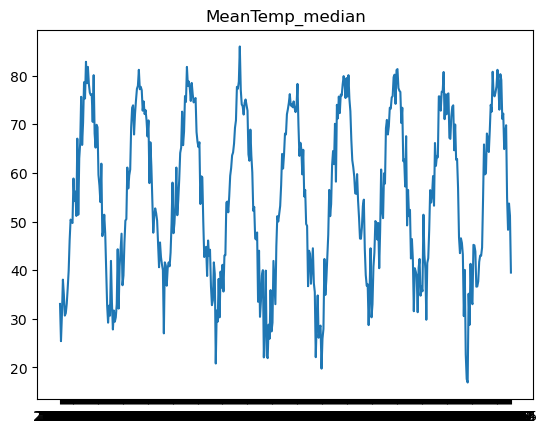

ADF Statistic on the entire dataset: 0.5926244490012599
p-value: 0.9874324166085993
Critical Values:
	1%: -3.444900499925237
	5%: -2.8679556266351653
	10%: -2.570187288941969
ADF Statistic on the entire dataset: -3.404298553625563
p-value: 0.01081320414208431
Critical Values:
	1%: -3.444965543297668
	5%: -2.8679842369272976
	10%: -2.5702025382716047


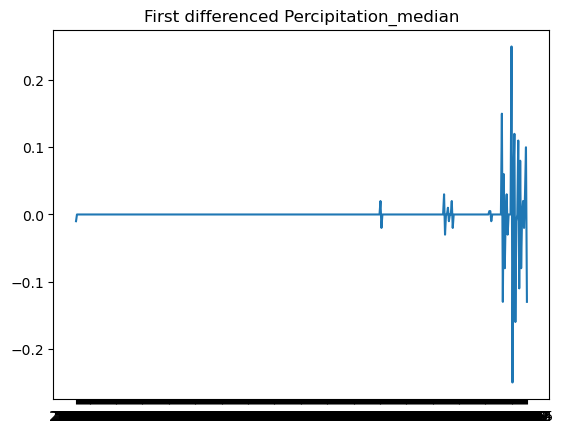

ADF Statistic on the entire dataset: -3.897811016491682
p-value: 0.0020510160105628107
Critical Values:
	1%: -3.4446148284445153
	5%: -2.8678299626609314
	10%: -2.5701203107928157
ADF Statistic on the entire dataset: -11.94714609889746
p-value: 4.403054105887727e-22
Critical Values:
	1%: -3.4446148284445153
	5%: -2.8678299626609314
	10%: -2.5701203107928157


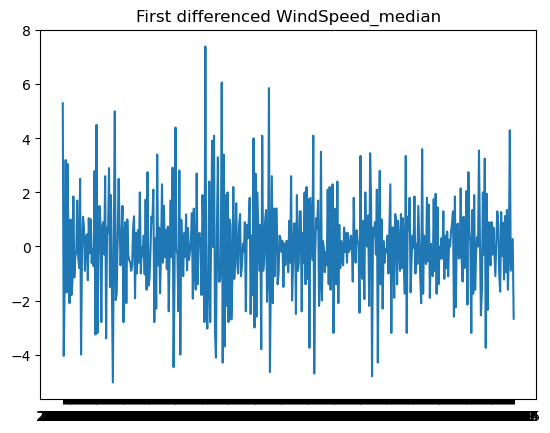

ADF Statistic on the entire dataset: -1.063155888360803
p-value: 0.7295391290675182
Critical Values:
	1%: -3.444932949082776
	5%: -2.867969899953726
	10%: -2.57019489663276
ADF Statistic on the entire dataset: -5.831989162104051
p-value: 3.955428971354333e-07
Critical Values:
	1%: -3.444932949082776
	5%: -2.867969899953726
	10%: -2.57019489663276


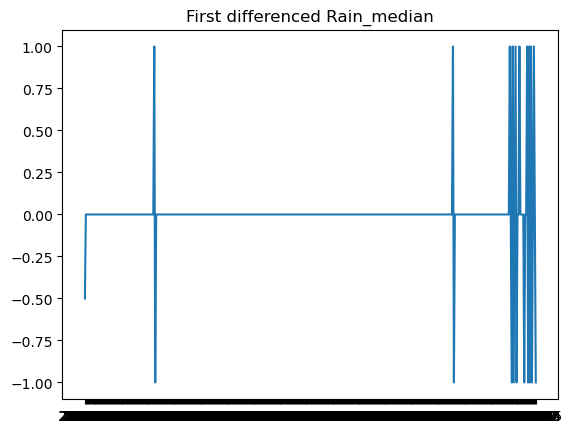

ADF Statistic on the entire dataset: -13.730640975534538
p-value: 1.1418867549239223e-25
Critical Values:
	1%: -3.4444002781824477
	5%: -2.867735576537528
	10%: -2.57007000456571
ADF Statistic on the entire dataset: -11.569868901065927
p-value: 3.1209847025294164e-21
Critical Values:
	1%: -3.4446773373329576
	5%: -2.8678574606780654
	10%: -2.5701349669405404


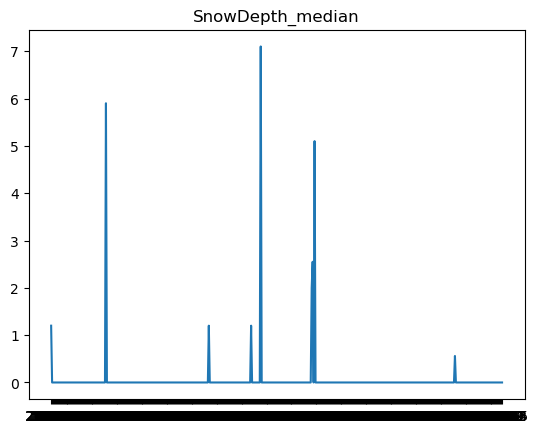

ADF Statistic on the entire dataset: -7.017701362016268
p-value: 6.666401608271999e-10
Critical Values:
	1%: -3.4444305322234365
	5%: -2.8677488864580885
	10%: -2.5700770984781443
ADF Statistic on the entire dataset: -13.25587167518684
p-value: 8.590398733783163e-25
Critical Values:
	1%: -3.4445220811896657
	5%: -2.8677891615873192
	10%: -2.5700985643950656


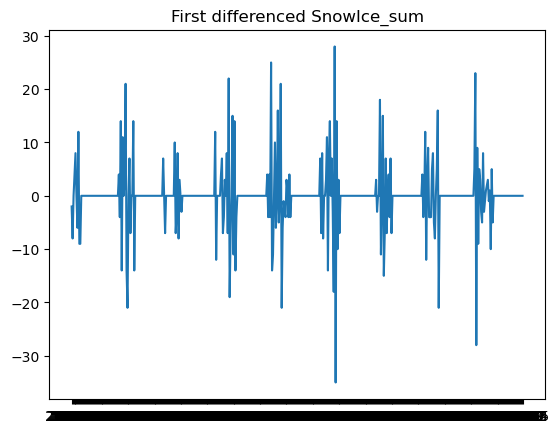

In [154]:
cols = ['MeanTemp_median', 'Percipitation_median', 'WindSpeed_median', 'Rain_median', 'SnowDepth_median', 'SnowIce_sum']

train_portion = df_weather[~df_weather['YearWeek'].isin(null_dates)]
train_portion.set_index('YearWeek', inplace = True)

for i in cols:
    
    first_diff = train_portion[i].diff()[1:]


    result = adfuller(train_portion[i])
    print('ADF Statistic on the entire dataset: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


    result_diff = adfuller(first_diff)
    print('ADF Statistic on the entire dataset: {}'.format(result_diff[0]))
    print('p-value: {}'.format(result_diff[1]))
    print('Critical Values:')
    for key, value in result_diff[4].items():
        print('\t{}: {}'.format(key, value))


    if result_diff[1] > result[1]:
        plt.plot(train_portion[i])
        plt.title(i)
        plt.show()
    else:
        plt.plot(first_diff)
        plt.title(f'First differenced {i}')
        plt.show()

After having a good understanding of the features to do perform a first level differencing on, we plot the ACF and PACF plots for each 

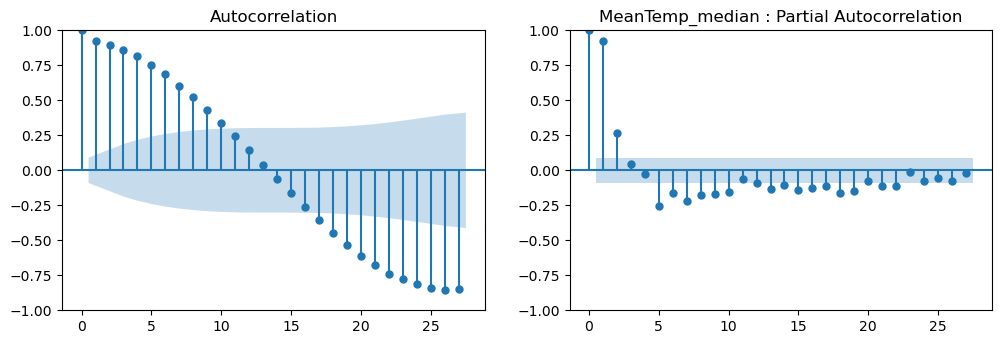

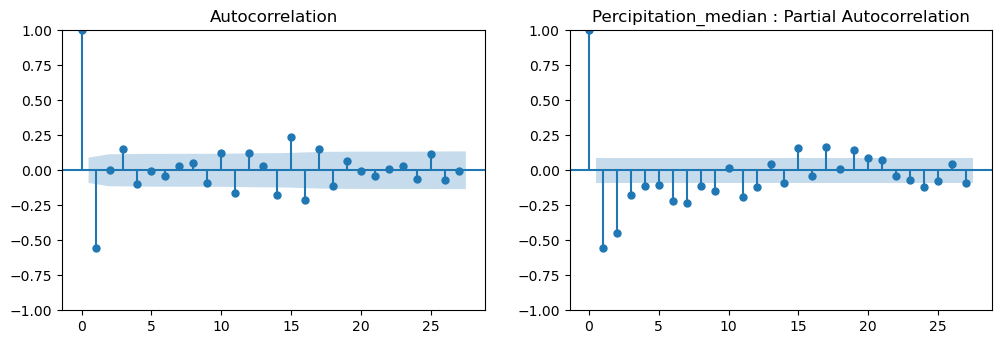

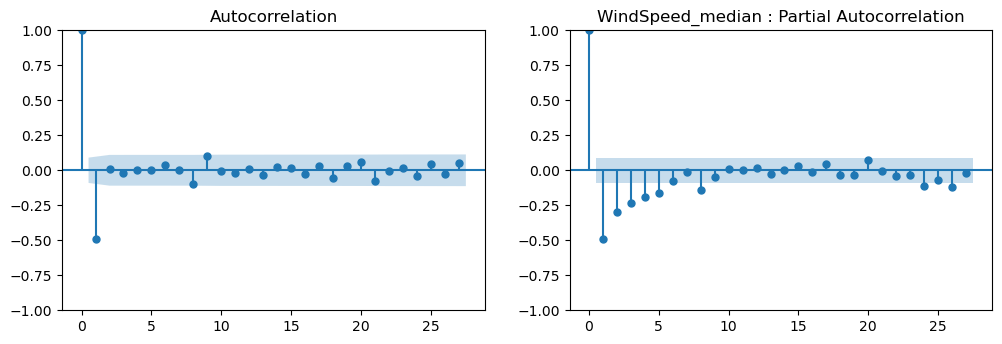

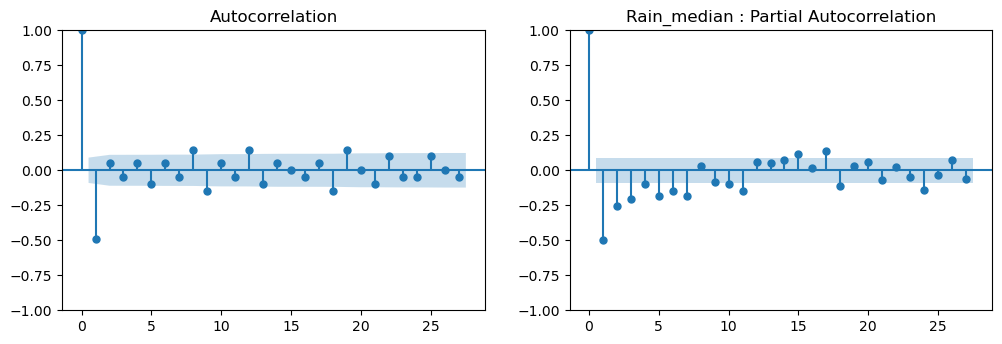

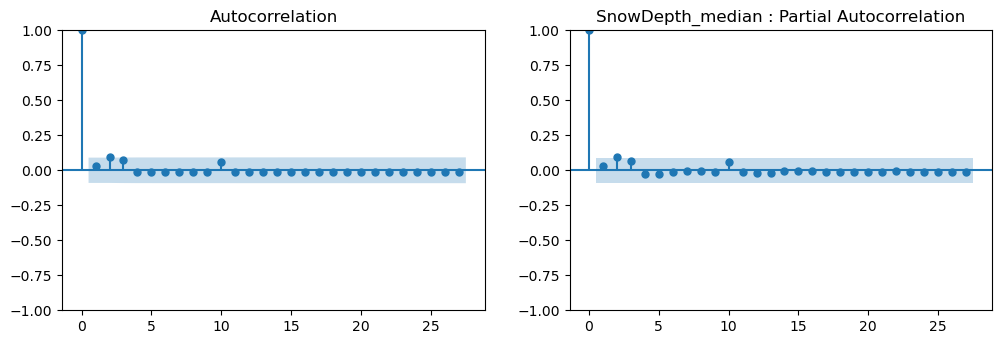

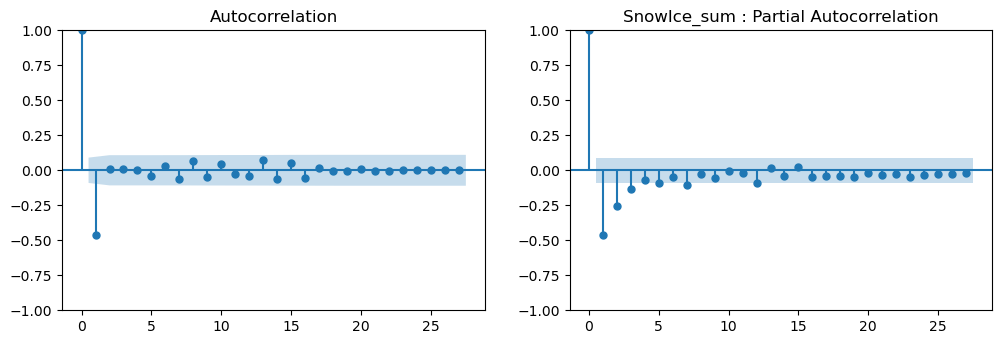

In [155]:
differencing = ['Percipitation_median', 'WindSpeed_median', 'Rain_median', 'SnowIce_sum']

for i in cols:

    if i in differencing:
        first_diff = train_portion[i].diff()[1:]
    else:
        first_diff = train_portion[i]
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(2,2,1)
    fig = sm.graphics.tsa.plot_acf(first_diff, ax=ax1)
    ax2 = fig.add_subplot(2,2,2)
    fig = sm.graphics.tsa.plot_pacf(first_diff, ax=ax2)
    ax2.set_title(f'{i} : Partial Autocorrelation')

In [156]:
order = {
    'MeanTemp_median': (2,0,10),
    'Percipitation_median': (4,1,1),
    'WindSpeed_median': (5,1,1),
    'Rain_median': (7,1,1),
    'SnowDepth_median': (2,0,4),
    'SnowIce_sum': (3,1,1)
}

In [157]:
train_portion

MeanTemp_median  MeanTemp_std  Percipitation_median  \
YearWeek                                                        
201000              33.05      2.702524                  0.01   
201001              25.40      4.269384                  0.00   
201002              30.90      6.786858                  0.00   
201003              38.05      2.953456                  0.00   
201004              34.95     10.988860                  0.00   
...                   ...           ...                   ...   
201841              54.90      4.153251                  0.02   
201842              48.30      3.650238                  0.00   
201843              53.70      5.937607                  0.03   
201844              51.20      3.758661                  0.13   
201845              39.50      2.536730                  0.00   

          Percipitation_std  WindSpeed_median  WindSpeed_std  Rain_median  \
YearWeek                                                                    
201000             0.117808             6.150       6.073358          0.5   
201001             0.011033            11.450       4.158050          0.0   
201002             0.000000             7.400       2.790138          0.0   
201003             0.162331             6.050       3.391351          0.0   
201004             0.306543             9.250       4.899607          0.0   
...                     ...               ...            ...          ...   
201841             0.031294            10.000       3.255460          0.0   
201842             0.219009             9.100       4.554973          0.0   
201843             0.171984             8.800       3.346631          1.0   
201844             0.316918             9.075       2.296277          1.0   
201845             0.011180             6.400       4.047008          0.0   

          Rain_std  SnowDepth_median  SnowDepth_std  SnowIce_sum  
YearWeek                                                          
201000    0.522233               1.2       3.139448         10.0  
201001    0.000000               0.0       1.719932          8.0  
201002    0.000000               0.0       0.000000          0.0  
201003    0.415300               0.0       0.000000          0.0  
201004    0.445001               0.0       1.279440          4.0  
...            ...               ...            ...          ...  
201841    0.502096               0.0       0.000000          0.0  
201842    0.443440               0.0       0.000000          0.0  
201843    0.502096               0.0       0.000000          0.0  
201844    0.502096               0.0       0.000000          0.0  
201845    0.000000               0.0       0.000000          0.0  

[470 rows x 11 columns]

Calculate multicollinearity using VIF

In [158]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = cols
  
vif_train_portion = train_portion.loc[:, cols]

vif_data["VIF"] = [variance_inflation_factor(vif_train_portion.values, i)
                          for i in range(len(cols))]
  
print(vif_data)

                feature       VIF
0       MeanTemp_median  6.514540
1  Percipitation_median  1.887852
2      WindSpeed_median  7.847371
3           Rain_median  1.926902
4      SnowDepth_median  1.633242
5           SnowIce_sum  2.408795


In [159]:
vif_data = pd.DataFrame()
subset_cols = ['MeanTemp_median', 'Percipitation_median', 'Rain_median', 'SnowDepth_median', 'SnowIce_sum']
vif_data["feature"] = subset_cols
vif_train_portion = vif_train_portion.loc[:, subset_cols]

vif_data["VIF"] = [variance_inflation_factor(vif_train_portion.values, i)
                          for i in range(len(subset_cols))]

print(vif_data)                          

                feature       VIF
0       MeanTemp_median  1.109764
1  Percipitation_median  1.886503
2           Rain_median  1.926514
3      SnowDepth_median  1.522580
4           SnowIce_sum  1.592920


Removing WindSpeed_median as it expresses high multicollinearity

In [160]:
import warnings
warnings.simplefilter("ignore")
cols.remove('WindSpeed_median')

Developed a cross-validated ARIMA model and used it to make future predictions


=======================================MeanTemp_median=======================================
Average RMSE: 31.307978625683045
Average MAPE: 0.07819760412536177

=======================================Percipitation_median=======================================
Average RMSE: 0.004500113182130228
Average MAPE: 140.9971352209496

=======================================Rain_median=======================================
Average RMSE: 0.2514731014163335
Average MAPE: 18.615099566970535

=======================================SnowDepth_median=======================================
Average RMSE: 0.0053401744318362495
Average MAPE: 1.0

=======================================SnowIce_sum=======================================
Average RMSE: 4.556602828179949
Average MAPE: 0.9439890702973626



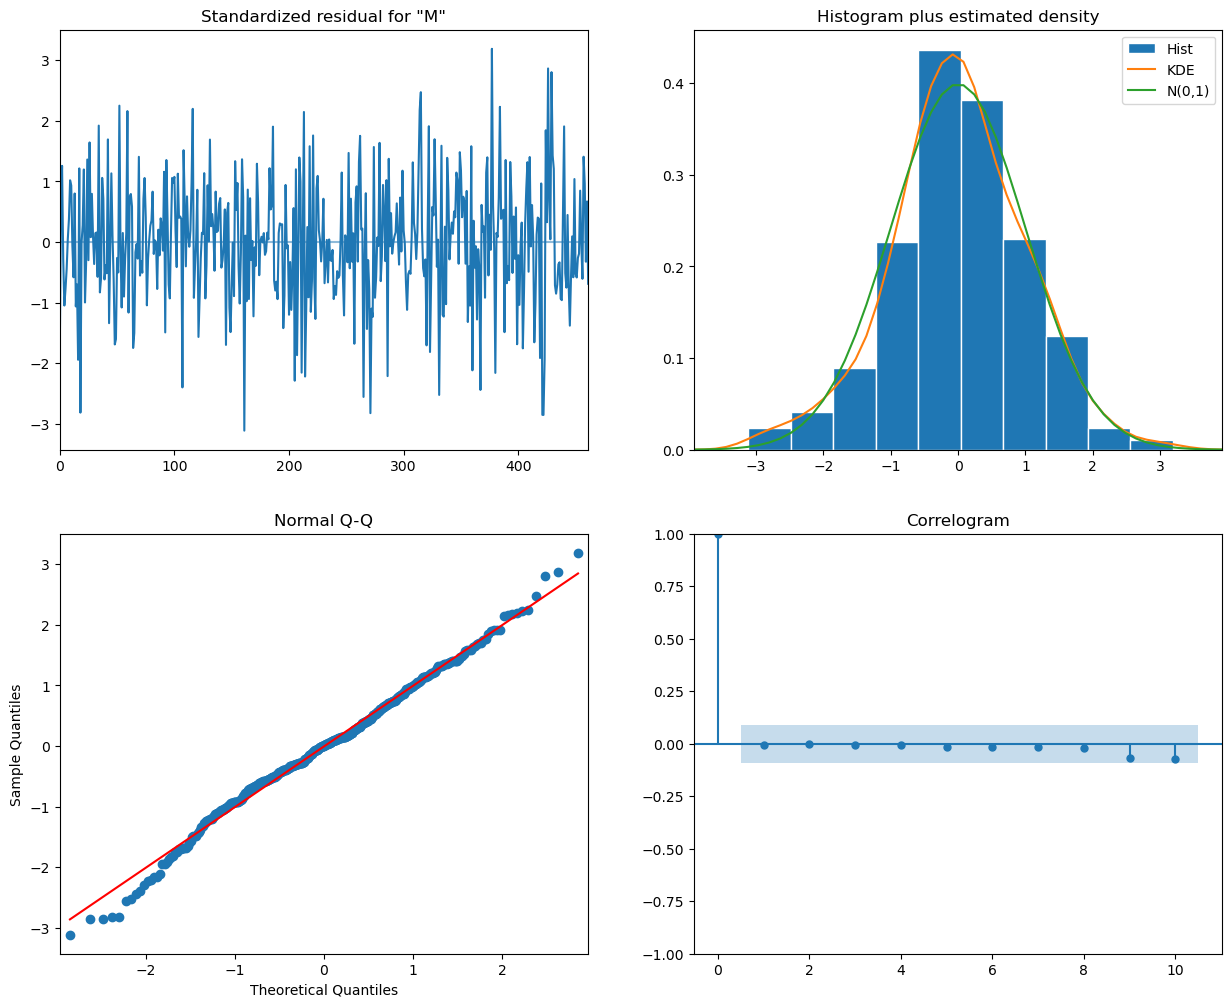

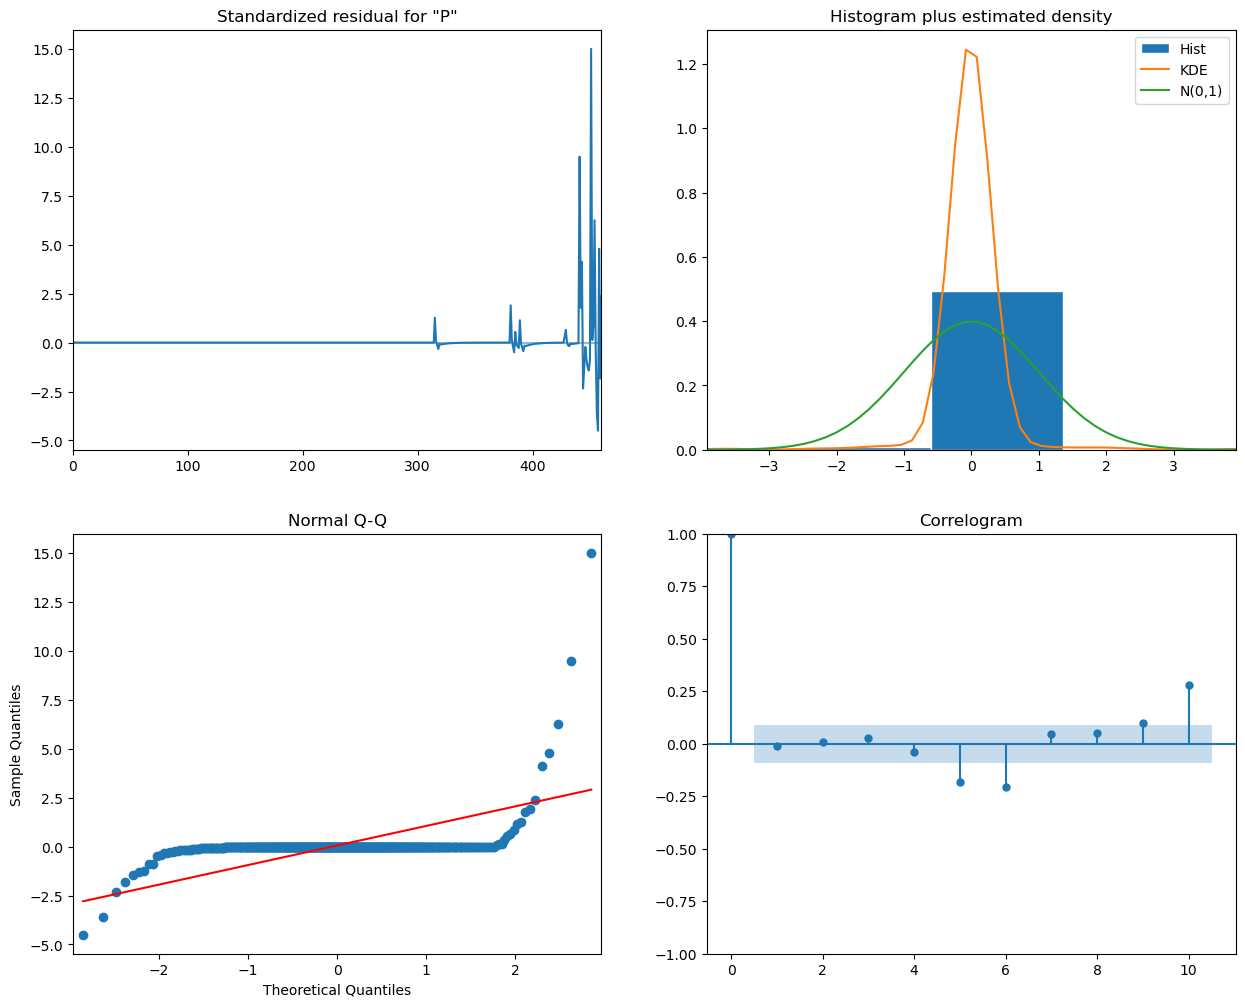

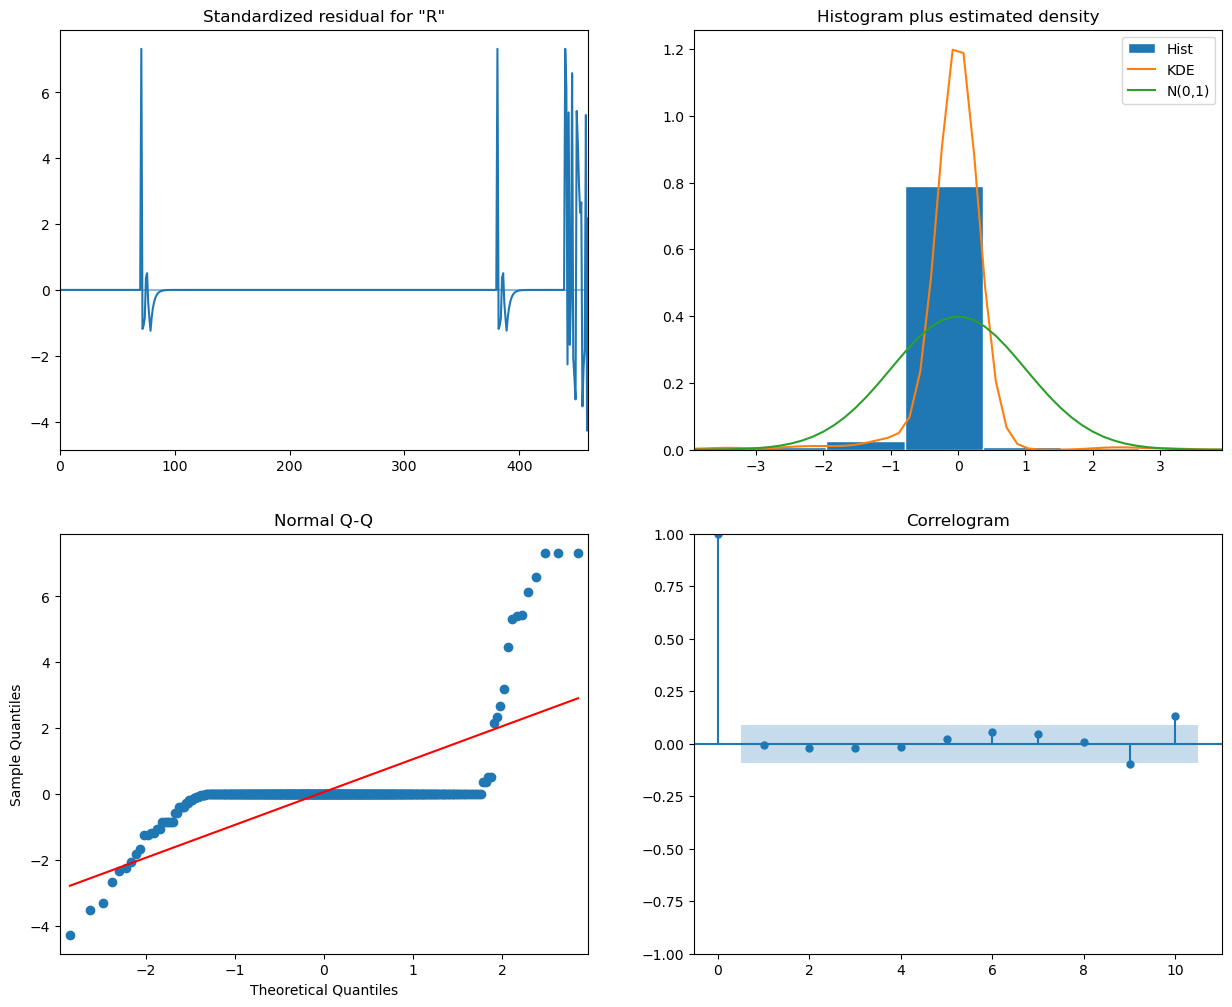

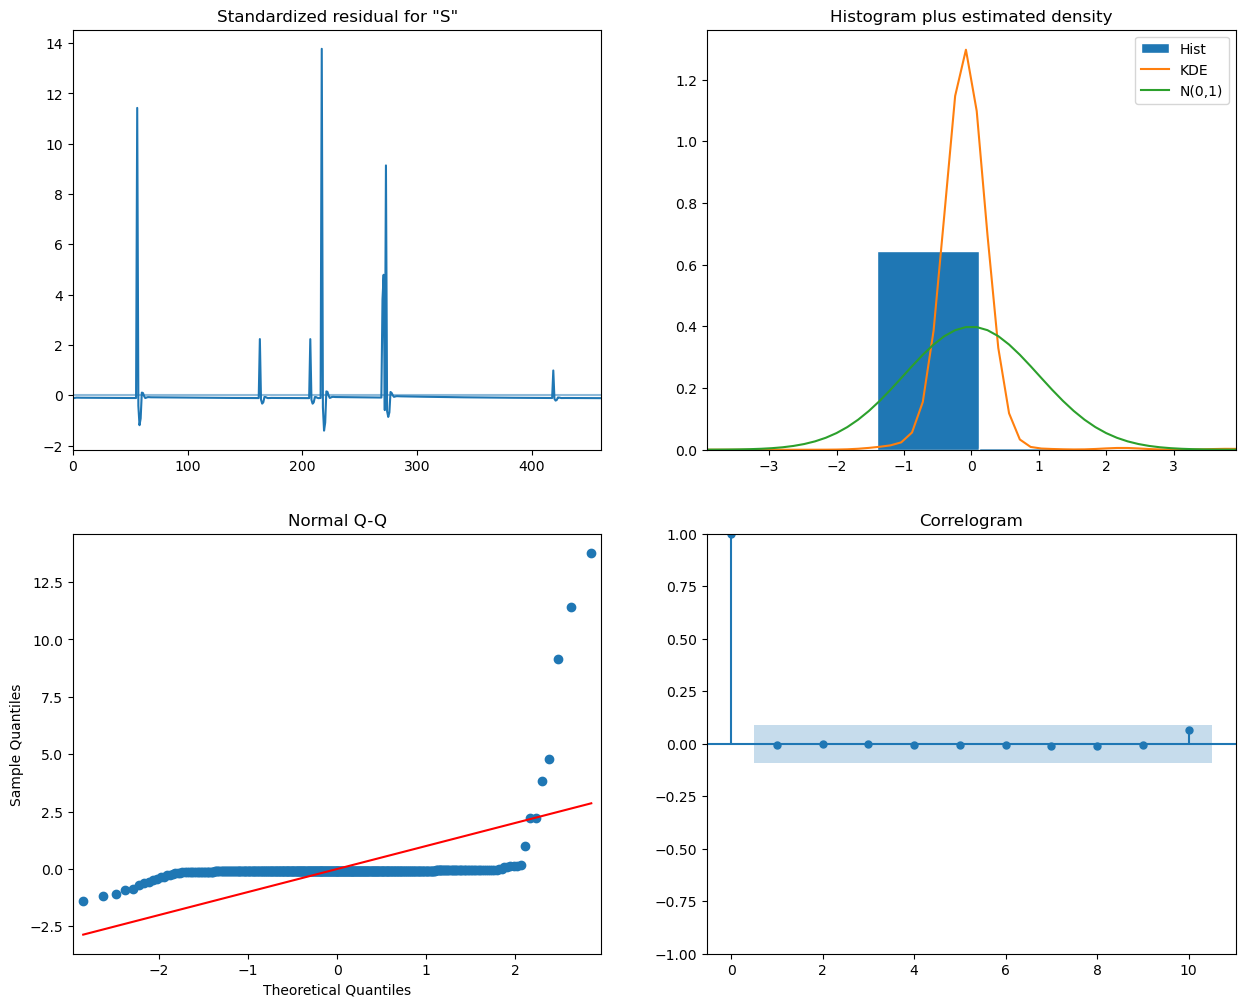

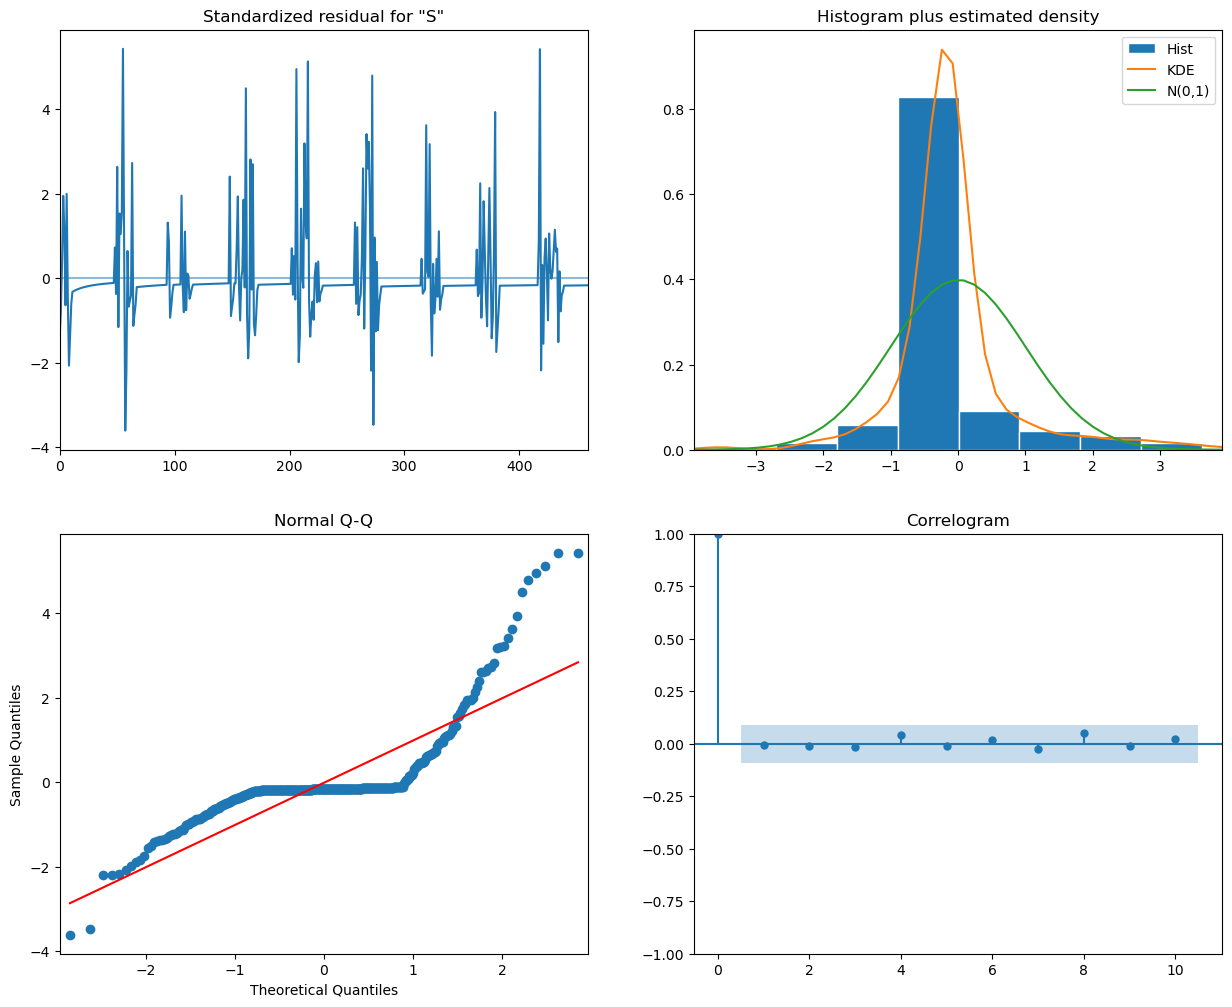

In [161]:
num_folds = 5

for i in cols:
    print(f"======================================={i}=======================================")
    rmse = []
    mape = []
    for j in range(num_folds):
        train_data = train_portion[i][1:-(7 * (num_folds-j))]
        val_data = train_portion[i][(-7 * (num_folds-j))-1: -7 * (num_folds-j-1)-1]

        model = ARIMA(train_data, order = order[i])
        model_fit = model.fit(method_kwargs={"warn_convergence": False})
        
        predictions = model_fit.get_forecast(7)

        prediction = predictions.predicted_mean
        prediction_range = predictions.conf_int(alpha=0.05)
        deviation = (prediction - prediction_range.iloc[:,-1])/2

        rmse.append(mean_squared_error(prediction, list(val_data)))
        mape.append(mean_absolute_percentage_error(prediction, list(val_data)))

    rmse = np.array(rmse)
    mape = np.array(mape)

    model_fit.plot_diagnostics(figsize=(15, 12))

    print(f'Average RMSE: {np.mean(rmse)}')
    print(f'Average MAPE: {np.mean(mape)}')

    print()


We make predictions for 7 weeks by predicting the average temperature for each week

In [162]:
temperature_column = cols[0]

train_data = train_portion[temperature_column]

model = ARIMA(train_data, order = order[temperature_column])
model_fit = model.fit(method_kwargs={"warn_convergence": False})

predictions = model_fit.get_forecast(7)

prediction = predictions.predicted_mean
prediction_range = predictions.conf_int(alpha=0.05)
deviation = (prediction - prediction_range.iloc[:,-1])/2
deviation = abs(deviation)

In [163]:
temperature_predictions = list(train_portion[temperature_column].values[list(train_portion.index).index('201600'):]) + list(prediction)
temperature_deviation = list(train_portion['MeanTemp_std'].values[list(train_portion.index).index('201600'):]) + list(deviation)

In [164]:
engineered_dataset = pd.DataFrame()
engineered_dataset['YearWeek'] = final['YearWeek']
engineered_dataset['Count'] = final['Count']
engineered_dataset['Date'] = final['Y-M-d']
engineered_dataset

YearWeek  Count       Date
0      201600  16680 2016-01-01
1      201600  18360 2016-01-02
2      201601  18570 2016-01-03
3      201601  35778 2016-01-04
4      201601  48666 2016-01-05
...       ...    ...        ...
1091   201851   4733 2018-12-27
1092   201851   4294 2018-12-28
1093   201851   3492 2018-12-29
1094   201852   3500 2018-12-30
1095   201852   4029 2018-12-31

[1096 rows x 3 columns]

In [165]:
temperature = pd.DataFrame()
temperature['YearWeek'] = engineered_dataset['YearWeek'].unique()
temperature['WeekMeanTemp'] = temperature_predictions
temperature['WeekTempStd'] = temperature_deviation

In [166]:
engineered_dataset = pd.merge(engineered_dataset, temperature, on = 'YearWeek', how = 'left')
engineered_dataset

YearWeek  Count       Date  WeekMeanTemp  WeekTempStd
0      201600  16680 2016-01-01     39.000000     2.501030
1      201600  18360 2016-01-02     39.000000     2.501030
2      201601  18570 2016-01-03     36.800000     7.771757
3      201601  35778 2016-01-04     36.800000     7.771757
4      201601  48666 2016-01-05     36.800000     7.771757
...       ...    ...        ...           ...          ...
1091   201851   4733 2018-12-27     33.853557     5.144074
1092   201851   4294 2018-12-28     33.853557     5.144074
1093   201851   3492 2018-12-29     33.853557     5.144074
1094   201852   3500 2018-12-30     33.068500     5.202969
1095   201852   4029 2018-12-31     33.068500     5.202969

[1096 rows x 5 columns]

In [167]:
engineered_dataset.to_csv('engineered_dataset_weekly.csv', index = False)

We also make predictions for the 8th week, to account for the exogenous variable used for predicting the future

In [168]:
future_predictions = model_fit.get_forecast(8)

In [169]:
future_prediction_values = future_predictions.predicted_mean
future_prediction_range = future_predictions.conf_int(alpha=0.05)
future_prediction_deviation = (future_prediction_values - future_prediction_range.iloc[:,-1])/2
future_prediction_deviation = abs(future_prediction_deviation)

In [170]:
future_prediction_data = pd.DataFrame()
future_prediction_data['WeekMeanTemp'] = future_prediction_values
future_prediction_data['WeekTempStd'] = future_prediction_deviation

Saving another checkpoint

In [171]:
future_prediction_data.to_csv('future_prediction_weekly_data.csv', index = False)